In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import IterableDataset, DataLoader
from matplotlib import pyplot as plt
from typing import Tuple, Optional, Any
import math
from torch import Tensor
from einops import rearrange
from diffusers import DDPMScheduler
from torchvision import transforms, datasets
from tqdm import tqdm
from IPython.display import clear_output
import einops
from torch.utils.data.dataset import Dataset
from dataclasses import dataclass
from typing import List, Union, Dict, Any, Optional, BinaryIO
from PIL import Image, ImageColor, ImageDraw, ImageFont, UnidentifiedImageError
import abc  # Abstract base class
import numpy as np
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers.models.unets.unet_2d_condition import UNet2DConditionModel
from diffusers import DDPMScheduler, DDPMPipeline
from diffusers import DDPMScheduler, DDPMPipeline
from datasets import load_dataset
import requests
from io import BytesIO
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading
from accelerate import Accelerator
from IPython.display import clear_output


/home/doshlom4/torch114/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache() # Clear cacheimport torch

num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")

Number of GPUs: 1


In [3]:
import sys
print("Python interpreter:", sys.executable)


Python interpreter: /home/doshlom4/torch114/bin/python3.9


In [4]:
import subprocess
import re

def get_gpu_names_nvidia_smi():
    try:
        # Run the nvidia-smi command to list GPUs in a human-readable format
        # -L option lists GPUs with their UUID and name
        command = "nvidia-smi -L"
        output = subprocess.check_output(command, shell=True, text=True)

        gpu_names = []
        # Regular expression to find GPU name (e.g., "GPU 0: NVIDIA A100-SXM4-40GB (UUID: ...)")
        # We want to capture everything inside the parentheses before the UUID
        # pattern = r"GPU \d+: (.*?)\s+\(UUID:" # This works but is less specific
        pattern = r"GPU \d+: (.*?)\s+\(UUID: GPU-[0-9a-fA-F-]+"
        
        for line in output.splitlines():
            match = re.search(pattern, line)
            if match:
                gpu_names.append(match.group(1).strip())
        
        return gpu_names
    except FileNotFoundError:
        print("Error: 'nvidia-smi' command not found. Ensure NVIDIA drivers are installed and in your PATH.")
        return []
    except subprocess.CalledProcessError as e:
        print(f"Error executing nvidia-smi: {e}")
        return []

# Example Usage:
gpu_names = get_gpu_names_nvidia_smi()

if gpu_names:
    print("Detected GPU(s):")
    for i, name in enumerate(gpu_names):
        print(f"  GPU {i}: {name}")
else:
    print("No NVIDIA GPUs found or could not retrieve names.")

# You can also get more detailed information, e.g., using --query-gpu
def get_gpu_details_nvidia_smi():
    try:
        # Query specific attributes: index, name, total_memory, uuid
        command = "nvidia-smi --query-gpu=index,gpu_name,memory.total,uuid --format=csv,noheader"
        output = subprocess.check_output(command, shell=True, text=True)

        gpu_details = []
        for line in output.strip().split('\n'):
            parts = [p.strip() for p in line.split(',')]
            if len(parts) == 4:
                gpu_details.append({
                    "index": int(parts[0]),
                    "name": parts[1],
                    "total_memory": parts[2],
                    "uuid": parts[3]
                })
        return gpu_details
    except FileNotFoundError:
        print("Error: 'nvidia-smi' command not found.")
        return []
    except subprocess.CalledProcessError as e:
        print(f"Error executing nvidia-smi: {e}")
        return []

print("\nDetailed GPU Information:")
details = get_gpu_details_nvidia_smi()
if details:
    for gpu in details:
        print(f"  Index: {gpu['index']}, Name: {gpu['name']}, Memory: {gpu['total_memory']}, UUID: {gpu['uuid']}")
else:
    print("Could not retrieve detailed GPU information.")

Detected GPU(s):
  GPU 0: NVIDIA A100 80GB PCIe

Detailed GPU Information:
  Index: 0, Name: NVIDIA A100 80GB PCIe, Memory: 80994 MiB, UUID: GPU-43762dfe-db1c-c542-ef45-1f6bad9a6e34


In [5]:
import torch
print(f"Is CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

Is CUDA available: True
CUDA device count: 1
Current CUDA device: 0
CUDA device name: NVIDIA A100 80GB PCIe


In [6]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.3.0+cu118
True
NVIDIA A100 80GB PCIe


In [7]:
!nvidia-smi


Sun Jul 27 00:11:05 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:1A:00.0 Off |                    0 |
| N/A   35C    P0    42W / 300W |      2MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
#@title Device / CUDA / Accelerate

accelerator = Accelerator()
device = accelerator.device

device_index = accelerator.local_process_index
print(f'Using device: {device}')
print(f"Device index: {device_index}")

total = torch.cuda.get_device_properties(device_index).total_memory
reserved = torch.cuda.memory_reserved(device_index)
allocated = torch.cuda.memory_allocated(device_index)
free = reserved - allocated

print(f"Total memory: {total / 1e9:.2f} GB")
print(f"Reserved memory: {reserved / 1e9:.2f} GB")
print(f"Allocated memory: {allocated / 1e9:.2f} GB")
print(f"Free (inside reserved): {free / 1e9:.2f} GB")

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Using device: cuda
Device index: 0
Total memory: 84.93 GB
Reserved memory: 0.00 GB
Allocated memory: 0.00 GB
Free (inside reserved): 0.00 GB


In [9]:
INPUT_SIZE = 64

model = UNet2DConditionModel(
    sample_size=INPUT_SIZE,  # input resolution
    in_channels=1,  # latent channels (usually 4 if using VAE)
    out_channels=1,  # same as in_channels for DDPM
    down_block_types=[
        "CrossAttnDownBlock2D",  # uses text-conditioning attention
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
        "DownBlock2D",           # last block can omit attention
    ],
    up_block_types=[
        "UpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
    ],
    block_out_channels=[320, 640, 1280, 1280],
    layers_per_block=2,
    cross_attention_dim=512,  # CLIP text embedding size
    attention_head_dim=8,
    norm_num_groups=8
)

In [10]:
model.down_blocks[0]

CrossAttnDownBlock2D(
  (attentions): ModuleList(
    (0-1): 2 x Transformer2DModel(
      (norm): GroupNorm(8, 320, eps=1e-06, affine=True)
      (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
      (transformer_blocks): ModuleList(
        (0): BasicTransformerBlock(
          (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          (attn1): Attention(
            (to_q): Linear(in_features=320, out_features=320, bias=False)
            (to_k): Linear(in_features=320, out_features=320, bias=False)
            (to_v): Linear(in_features=320, out_features=320, bias=False)
            (to_out): ModuleList(
              (0): Linear(in_features=320, out_features=320, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
          (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          (attn2): Attention(
            (to_q): Linear(in_features=320, out_features=320, bias=False)
            (to_k): Linear(in_f

In [11]:
# vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32", use_safetensors=True).to(device)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Freeze VAE
# vae.requires_grad_(False)

# don't train the text encoder
text_encoder.requires_grad_(False)

print(f"CUDA memory allocated now: {torch.cuda.memory_allocated() / (1024**3):.2f} GB")

CUDA memory allocated now: 0.24 GB


In [12]:
TOKENIZER_MAX_LENGTH = 77
example_prompt = ["a photo of a golden retriever wearing sunglasses"]
text_input = tokenizer(example_prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
text_encoder(text_input.input_ids.to(device))[0].shape

## the following output is the size of the text embedding for one text prompt.

torch.Size([1, 77, 512])

In [13]:
num_of_params = sum([p.numel() for p in model.parameters()])
print("Number of trainable parameters in the model: " + str(f"{num_of_params:,}"))

Number of trainable parameters in the model: 853,113,921


# Color palette

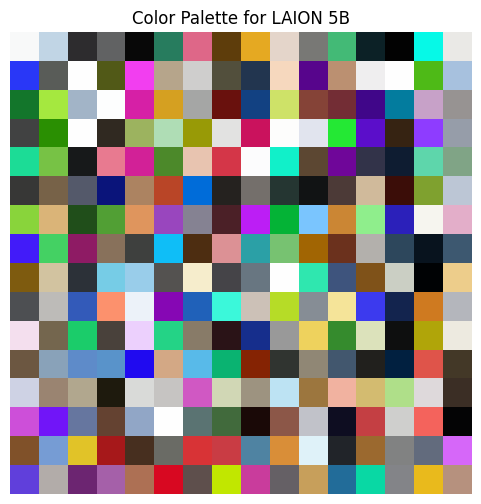

In [14]:
# Load color palette
palette = torch.tensor(np.load("../../color reduction palettes/laion2b_palette_8bit.npy"))

palette.shape# Ensure values are in [0, 1] for matplotlib

copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# Compute size for square grid
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding or change to zeros for black
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# Reshape to [H, W, 3] for image plotting
palette_image = copy_palette.view(grid_size, grid_size, 3)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette for LAION 5B")
plt.show()

In [15]:
def quantize_batch_to_palette_indices(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Quantizes each pixel in the input batch to the nearest palette color index.

    Args:
        images: Tensor of shape [B, 3, H, W], uint8, values in [0, 255]
        palette: Tensor of shape [K, 3], uint8, values in [0, 255]
        k: Number of colors in the palette

    Returns:
        Tensor of shape [B, H, W], with palette indices (0 to K-1) as int64
    """
    assert images.shape[1] == 3, "Images must be RGB"
    B, C, H, W = images.shape

    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()  # [B*H*W, 3]
    palette = palette.float()  # [K, 3]

    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)  # [B*H*W]

    indices = nearest_idx.reshape(B, H, W)  # [B, H, W]

    assert indices.min() >= 0 and indices.max() < 2 ** 8, "Indices must be in range [0, K-1]"
    indices = indices.to(torch.uint8)
    return indices

def reconstruct_from_indices(indices: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Converts quantized palette indices [B, H, W] back to RGB images using the palette [K, 3].

    Args:
        indices: Tensor of shape [B, H, W], dtype uint8 or long
        palette: Tensor of shape [K, 3], dtype uint8

    Returns:
        Tensor of shape [B, 3, H, W], dtype uint8
    """
    assert indices.dim() == 3, "Expected shape [B, H, W]"
    assert palette.dim() == 2 and palette.shape[1] == 3, "Expected palette shape [K, 3]"

    B, H, W = indices.shape
    flat_indices = indices.reshape(-1).long()  # ensure type is long
    palette = palette.to(indices.device)       # move to same device

    # Lookup RGB colors
    rgb = palette[flat_indices]  # [B*H*W, 3]

    # Reshape back to [B, 3, H, W]
    rgb = rgb.reshape(B, H, W, 3).permute(0, 3, 1, 2).contiguous()
    return rgb



# Dataset, dataloader, transforms, noise sched

In [16]:
class LaionStreamDataset(IterableDataset):
    """
    Streaming dataset. Stores a buffer of images and captions for next batch use.
    - max_items: The maximum items to store in the buffer (image, caption). Sometimes the buffer can go beyond that for performance reasons and threading, but we try to keep it to this length.
    """
    def __init__(self, transform, max_items=512, num_threads=16):
        self.dataset = load_dataset("laion/laion2B-en", streaming=True, split="train")
        self.transform = transform
        self.max_items = max_items
        self.num_threads = num_threads
        self.buffer = []

        # Shared counters
        self.lock = threading.Lock()
        self.valid_images = 0
        self.invalid_images = 0

    def download_and_process(self, example: dict) -> Tuple[Any, str]:
        """
        Given a dataset item (with URL and caption), downloads and returns the image and caption.
        Returns None on failure.
        """
        try:
            url = example["url"]
            caption = example["caption"]

            response = requests.get(url, timeout=5, stream=True)
            if response.status_code != 200 or "image" not in response.headers.get("Content-Type", ""):
                with self.lock:
                    self.invalid_images += 1
                return None

            try:
                image = Image.open(BytesIO(response.content))
                image.verify()
                image = Image.open(BytesIO(response.content)).convert("RGB")
            except (UnidentifiedImageError, OSError):
                with self.lock:
                    self.invalid_images += 1
                return None

            if self.transform:
                image = self.transform(image)
            
            with self.lock:
                self.valid_images += 1

            return image, caption

        except Exception:
            with self.lock:
                self.invalid_images += 1
            return None

    def __iter__(self):
        data_iter = iter(self.dataset)

        def fill_buffer():
            """
            Fills the buffer up to max_items using threading.
            """
            needed = self.max_items - len(self.buffer)
            if needed <= 0:
                print("Buffer is full, skipping")
                return

            examples = []
            for _ in range(needed * 2):  # Grab more to account for failures
                try:
                    examples.append(next(data_iter))
                except StopIteration:
                    break
                except Exception as e:
                    break

            with ThreadPoolExecutor(max_workers=self.num_threads) as executor:
                futures = [executor.submit(self.download_and_process, ex) for ex in examples]

                for future in as_completed(futures):
                    result = future.result()
                    if result is not None:
                        self.buffer.append(result)

                    if len(self.buffer) >= self.max_items:
                        break

            # if len(self.buffer) < self.max_items:
            #   print(f"[Warning] Buffer only filled to {len(self.buffer)} of {self.max_items} due to image download failures.")

        # Initial fill
        fill_buffer()

        while True:
            # Refill if buffer is low
            if len(self.buffer) < self.max_items // 2:
                fill_buffer()

            if not self.buffer:
                break  # Nothing more to yield

            yield self.buffer.pop(0)

        # print(f"\nFinished streaming:")
        # print(f"✅ Valid images:     {self.valid_images}")
        # print(f"❌ Invalid images:   {self.invalid_images}")

In [17]:
BATCH_SIZE = 32

class ToUint8:
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        return (image * 255).clamp(0, 255).to(torch.uint8)

image_transform = transforms.Compose([
    transforms.Resize((INPUT_SIZE, INPUT_SIZE)),
    transforms.ToTensor(),
    ToUint8(), # for quantization
])

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

dataset = LaionStreamDataset(transform=image_transform, max_items=1024, num_threads=64)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [18]:
# img, caption = next(iter(dataset))
# img = img.unsqueeze(0)
# print(f"got images: {img.shape}")
# img = quantize_batch_to_palette_indices(img, palette)
# print(img.min(), img.max(), img.shape)
# c, h, w = img.shape
# assert c == 1 and h == INPUT_SIZE and w == INPUT_SIZE

In [19]:
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))
# axes = axes.flatten()

# count = 0
# for image, caption in dataset:
#     # quantize batch of size 1
#     image = image.unsqueeze(0)
#     image = quantize_batch_to_palette_indices(image, palette)

#     # reconstruct
#     image = reconstruct_from_indices(image, palette)
#     image = image.squeeze(0)

#     image = rearrange(image, "c h w -> h w c")

#     axes[count].imshow(image)
#     axes[count].set_title(caption[:50] + "..." if len(caption) > 50 else caption, fontsize=10)
#     axes[count].axis("off")

#     count += 1
#     if count == 10:
#         break

# plt.tight_layout()
# plt.show()

In [20]:
def plot_image_batch(images: torch.Tensor, captions, max_images=8):
    """
    Plot a batch of images with shape [B, C, H, W].

    Args:
        images (torch.Tensor): Tensor of shape [B, C, H, W].
        titles (list of str, optional): Optional list of titles for each image.
        max_images (int): Max number of images to plot.
    """
    B, C, H, W = images.shape
    assert C in [1, 3], f"Expected 1 or 3 channels, got {C}"

    num_to_plot = min(B, max_images)
    fig, axes = plt.subplots(1, num_to_plot, figsize=(4 * num_to_plot, 4))

    if num_to_plot == 1:
        axes = [axes]

    for i in range(num_to_plot):
        img = images[i]

        # Convert to [H, W, C] for plotting
        if C == 1:
            img_np = img.squeeze(0).cpu().numpy()  # [H, W]
            axes[i].imshow(img_np, cmap='gray')
        else:
            if img.dtype == torch.float:
                img = (img * 255).clamp(0, 255).to(torch.uint8)
            img_np = rearrange(img, "c h w -> h w c").cpu().numpy()
            axes[i].imshow(img_np)

        axes[i].set_title(captions[i], fontsize=10)

        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


In [21]:
# Training params
num_epochs = 1
learning_rate = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Accelerate using multi-GPU (or a single GPU)
model, optimizer, dataset = accelerator.prepare(model, optimizer, dataset)

Epoch 1/1: 0it [00:00, ?it/s]/home/doshlom4/torch114/lib/python3.9/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


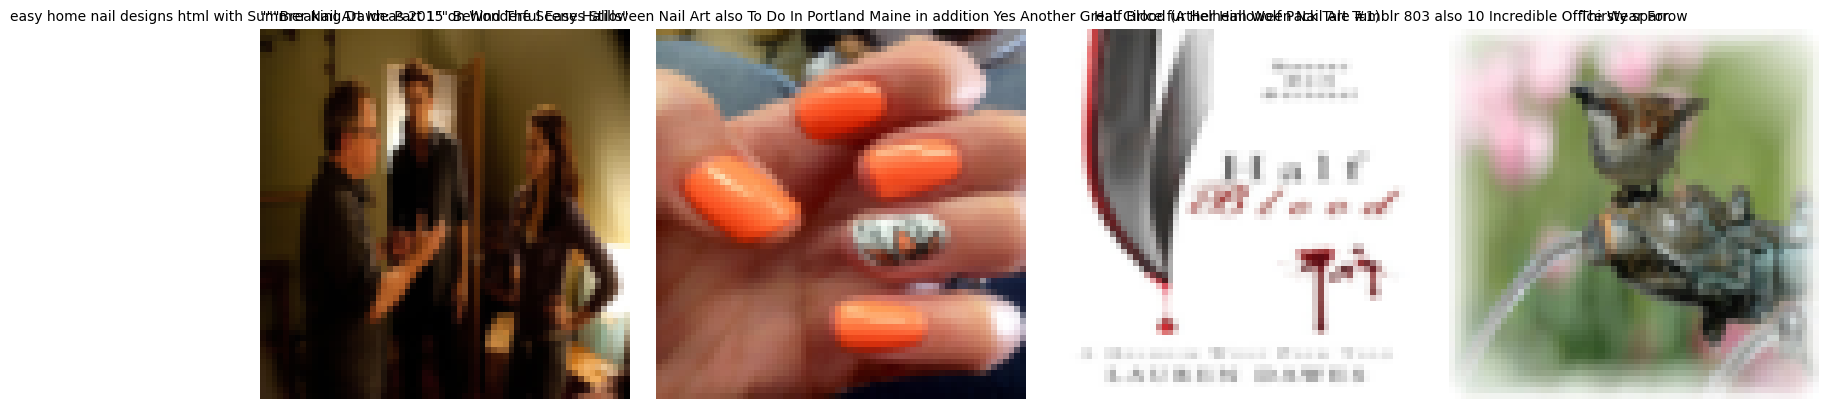

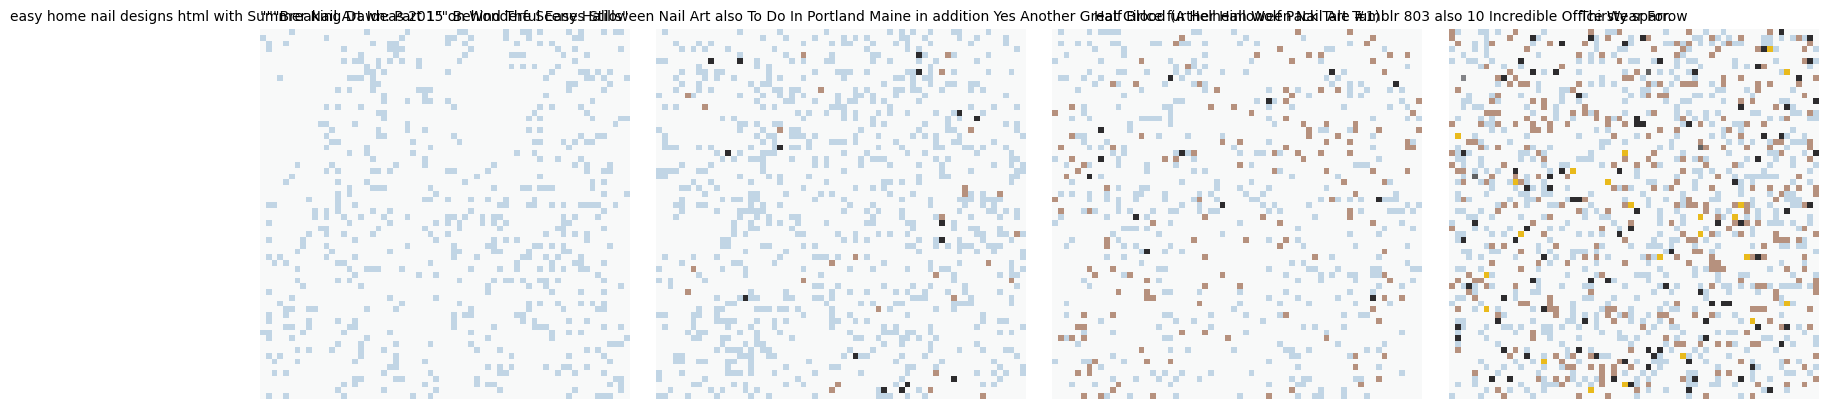

Predicting noise...
predicted noise
loss: 1.1130990982055664


Epoch 1/1: 1it [00:37, 37.15s/it, Loss=1.1131, Total Images=32, Steps=1]

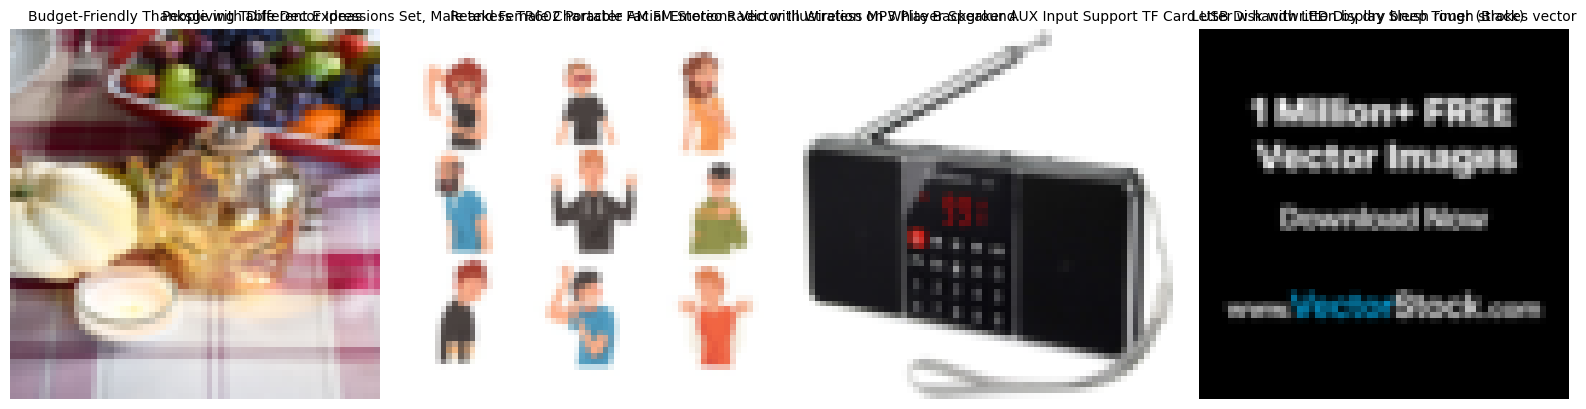

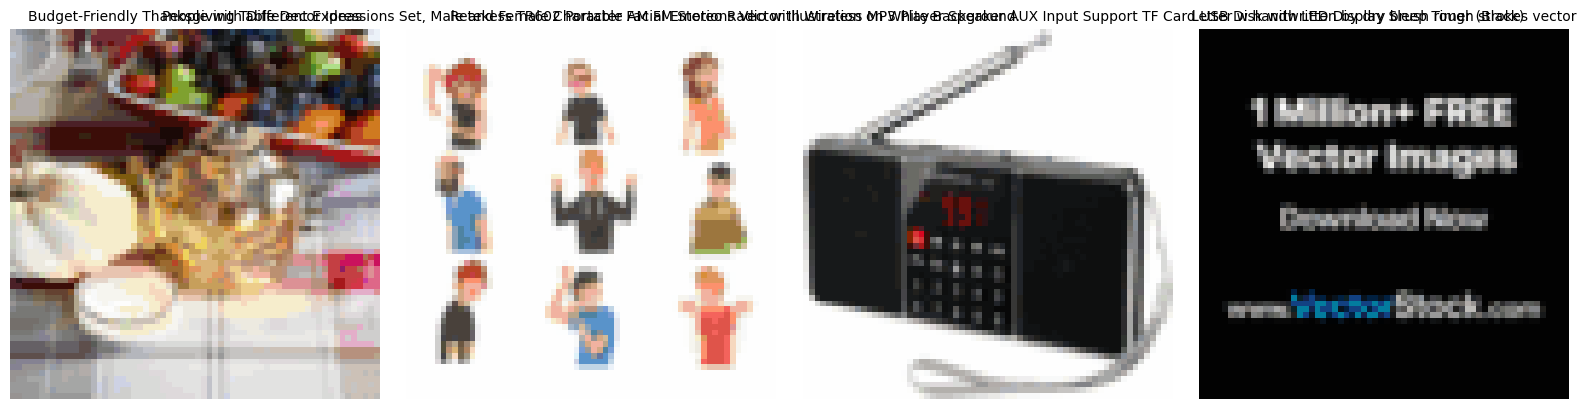

Predicting noise...
predicted noise
loss: 3.2547190189361572


Epoch 1/1: 2it [00:40, 17.50s/it, Loss=3.2547, Total Images=64, Steps=2]

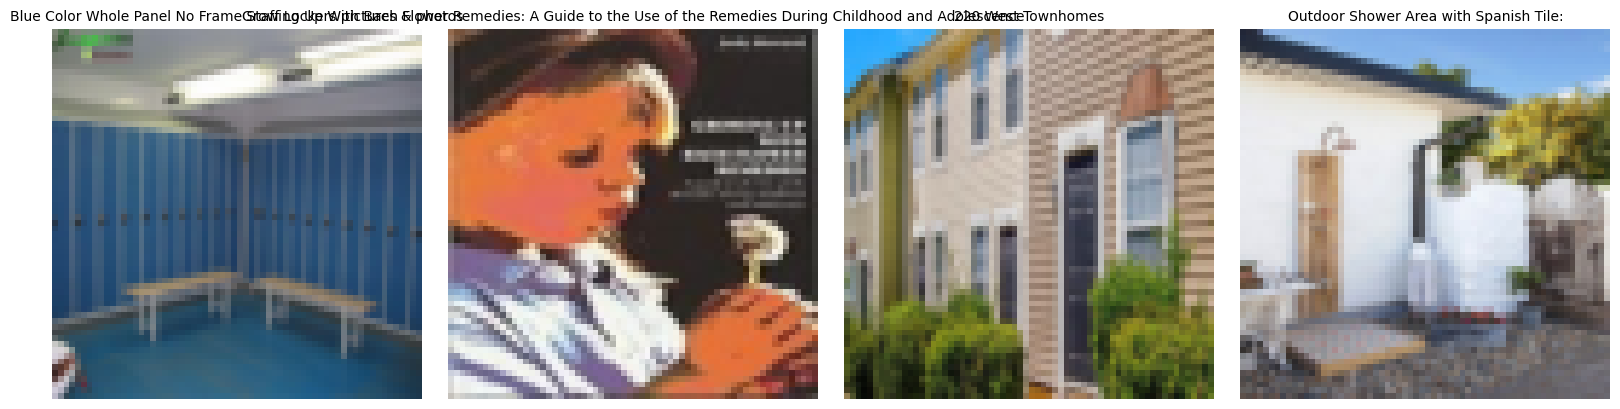

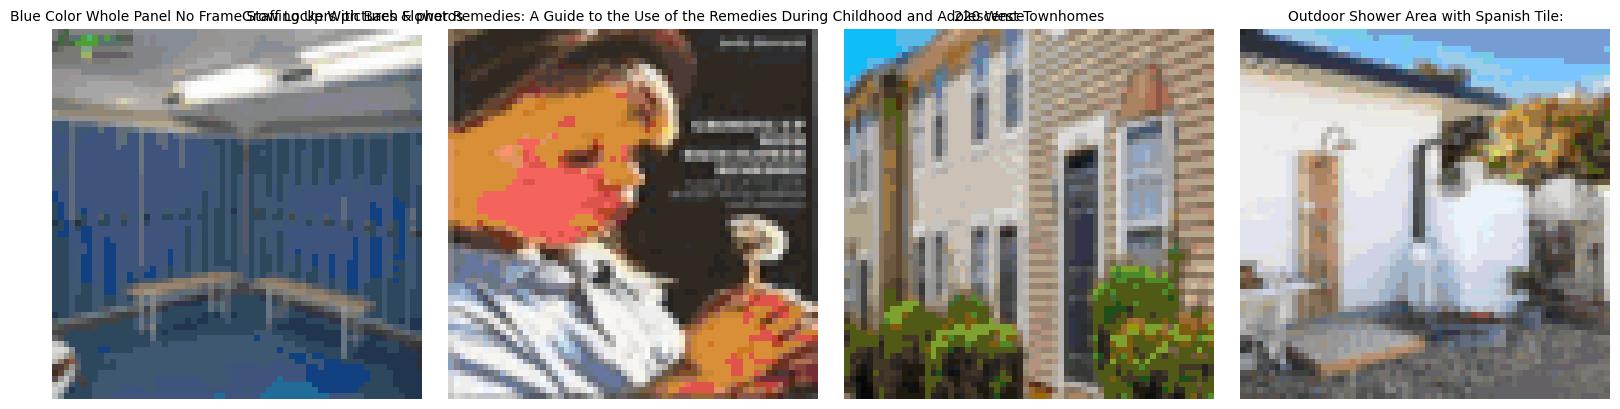

Predicting noise...
predicted noise
loss: 8.037795066833496


Epoch 1/1: 3it [00:44, 11.20s/it, Loss=8.0378, Total Images=96, Steps=3]

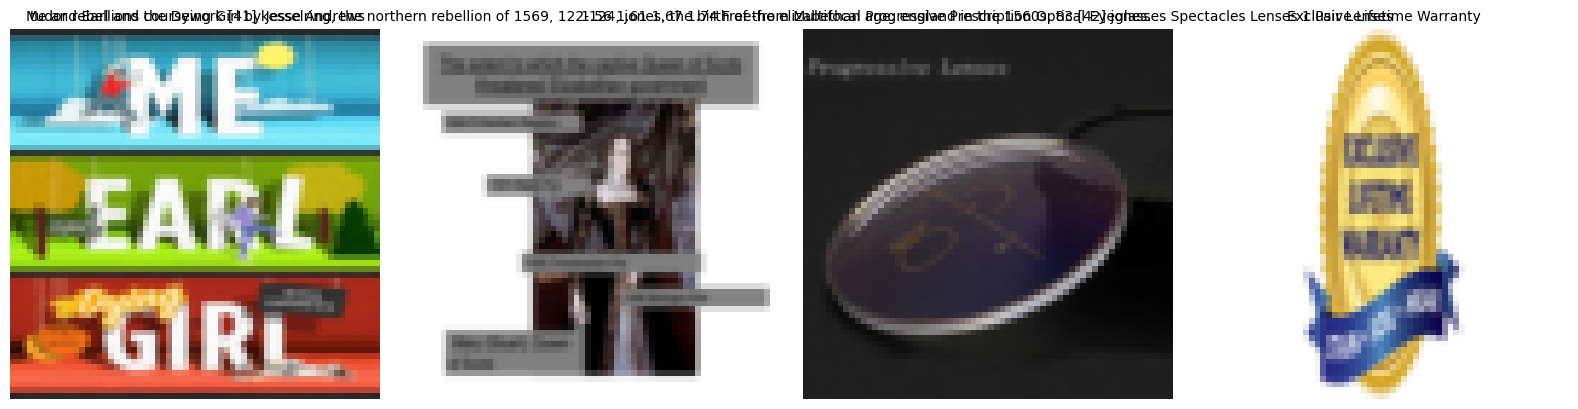

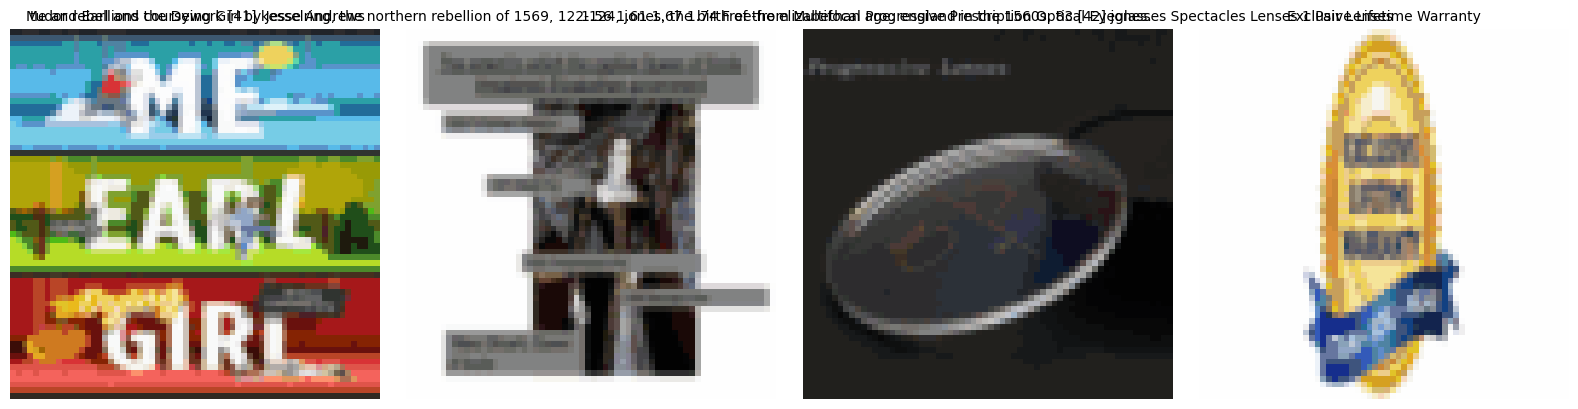

Predicting noise...
predicted noise
loss: 1.0131263732910156


Epoch 1/1: 4it [00:48,  8.26s/it, Loss=1.0131, Total Images=128, Steps=4]

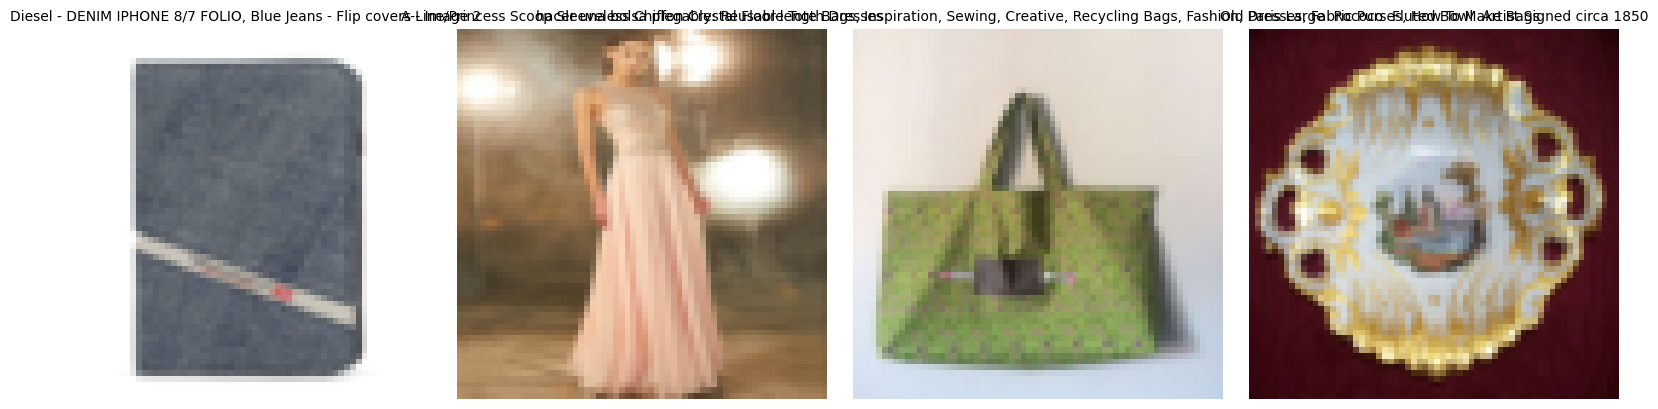

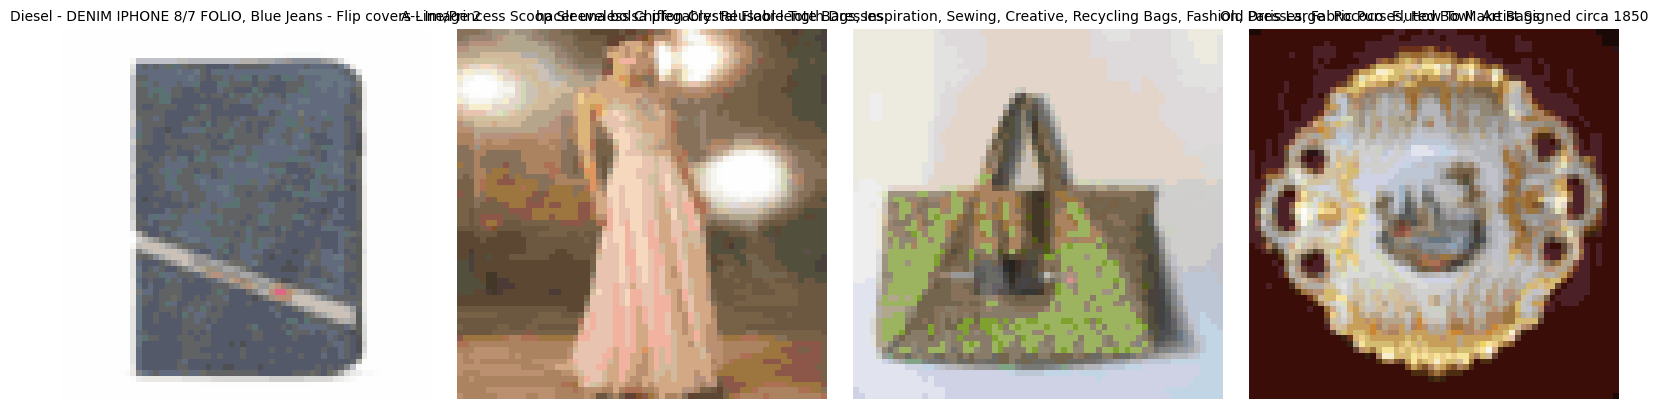

Predicting noise...
predicted noise
loss: 1.6454448699951172


Epoch 1/1: 5it [00:52,  6.69s/it, Loss=1.6454, Total Images=160, Steps=5]

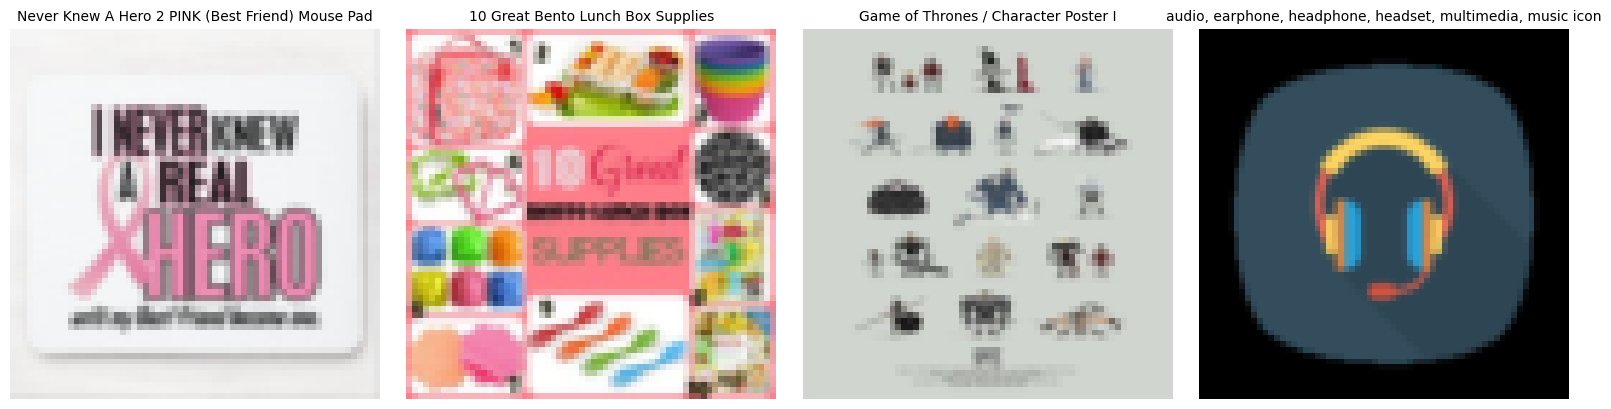

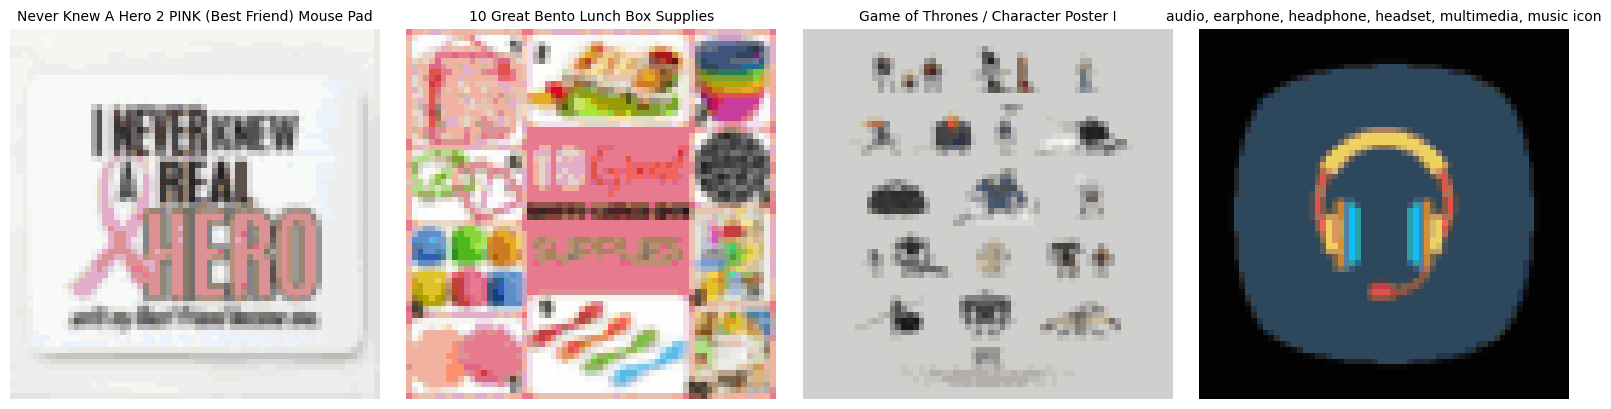

Predicting noise...
predicted noise
loss: 1.1807645559310913


Epoch 1/1: 6it [00:55,  5.67s/it, Loss=1.1808, Total Images=192, Steps=6]

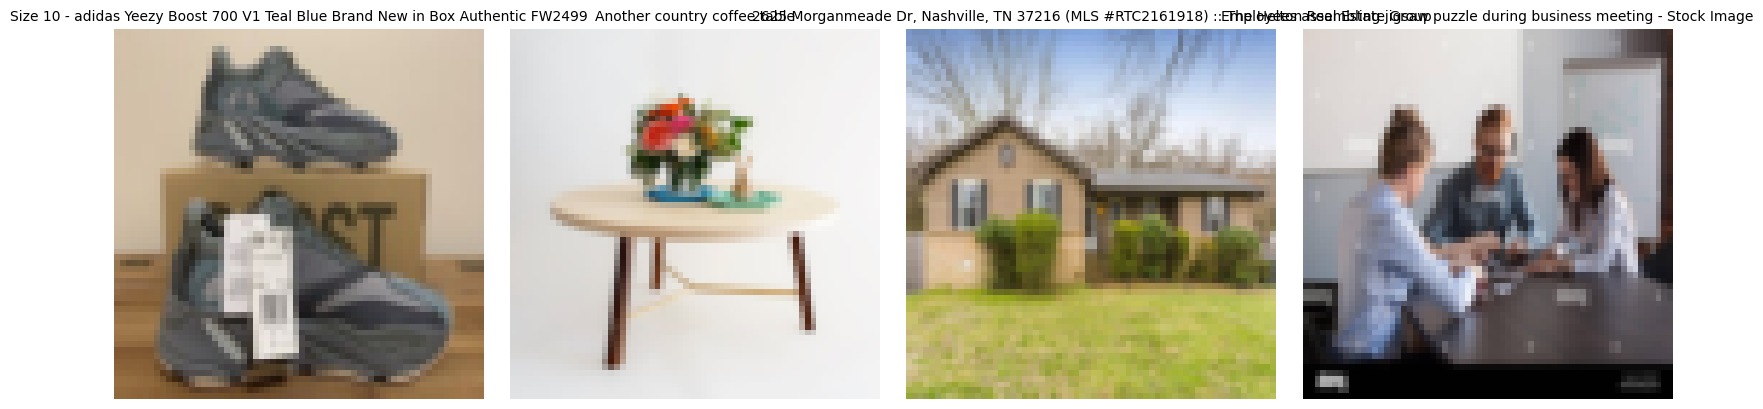

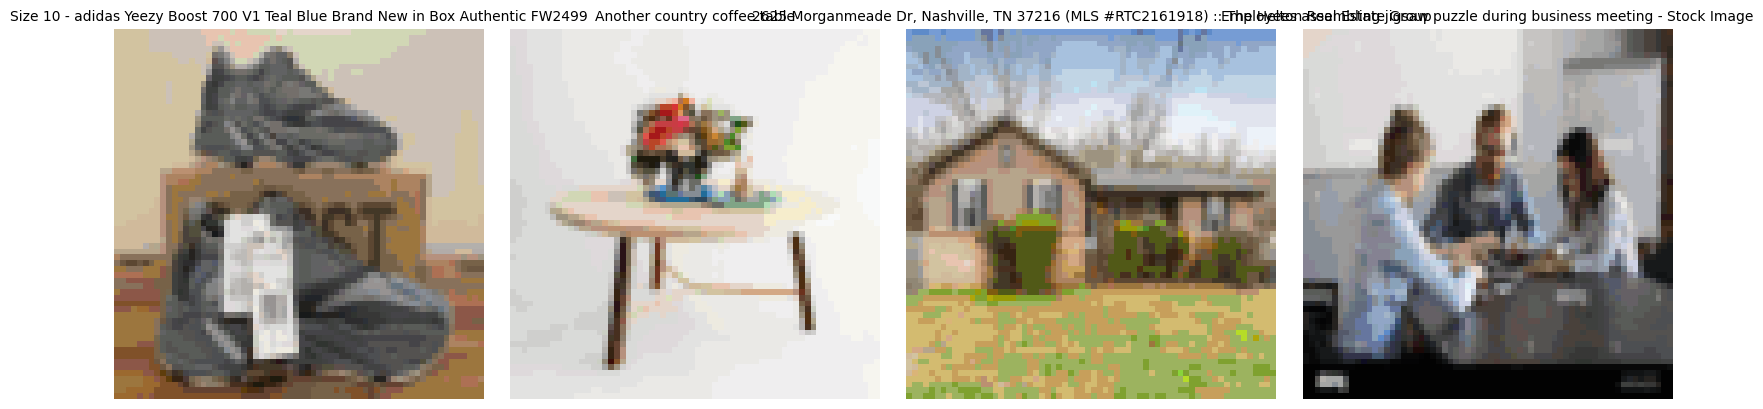

Predicting noise...
predicted noise
loss: 0.9966127276420593


Epoch 1/1: 7it [00:59,  5.03s/it, Loss=0.9966, Total Images=224, Steps=7]

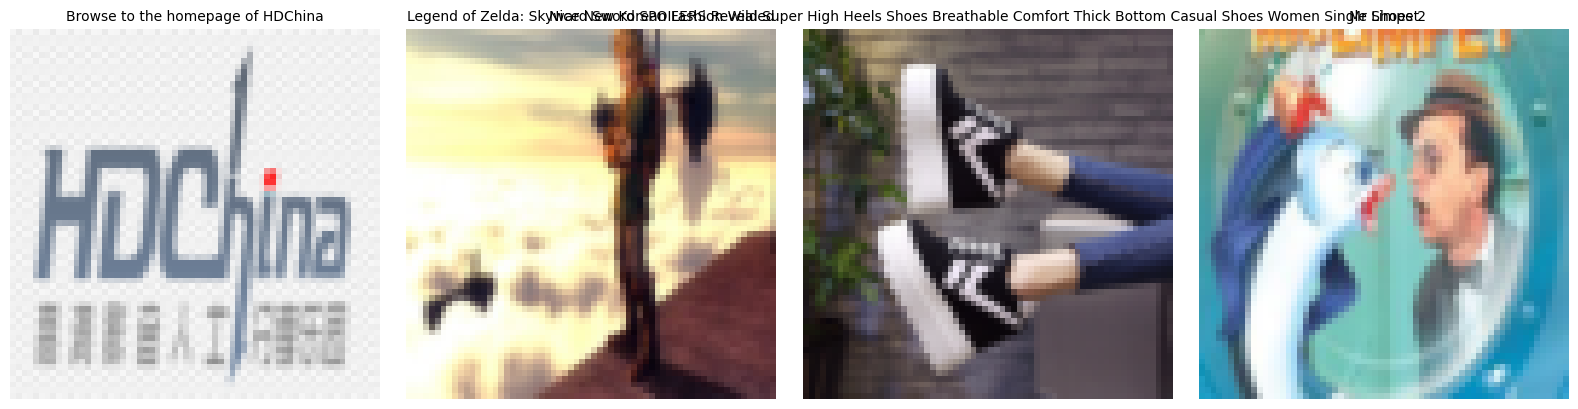

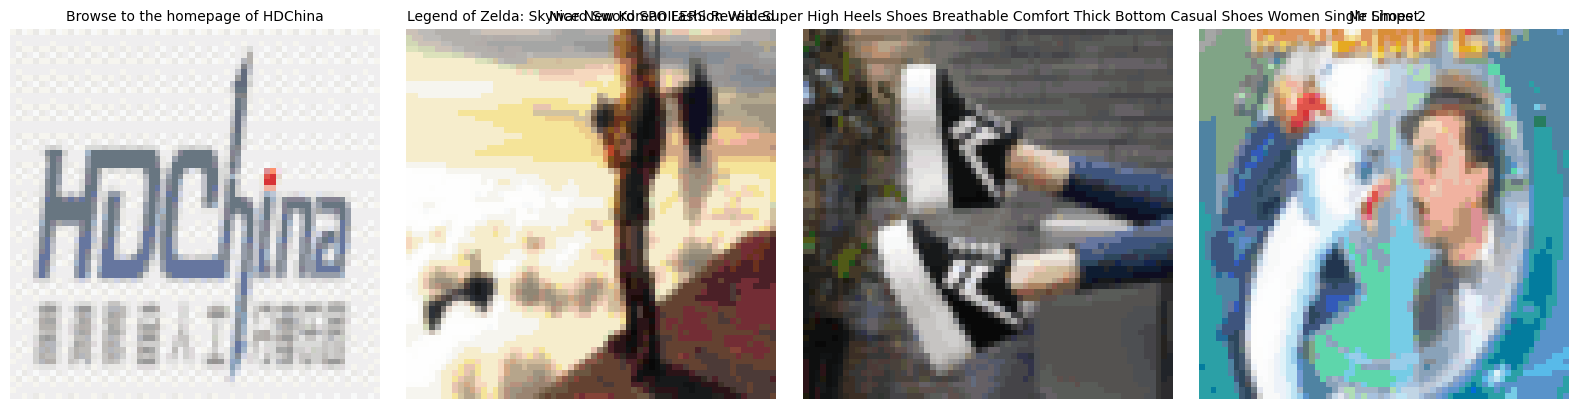

Predicting noise...
predicted noise
loss: 1.114515781402588


Epoch 1/1: 8it [01:03,  4.61s/it, Loss=1.1145, Total Images=256, Steps=8]

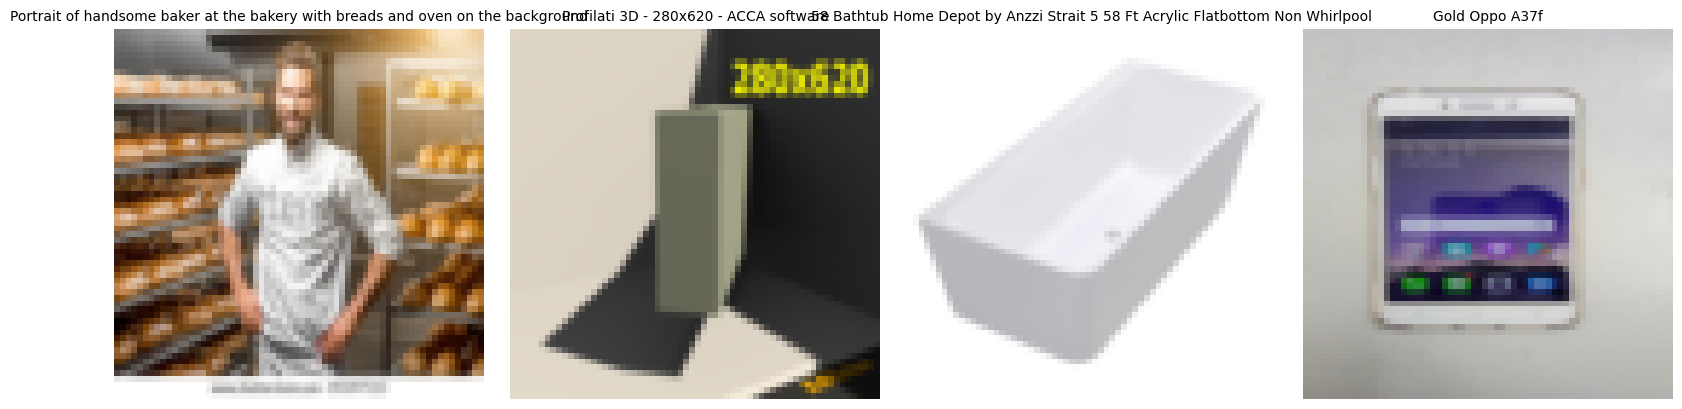

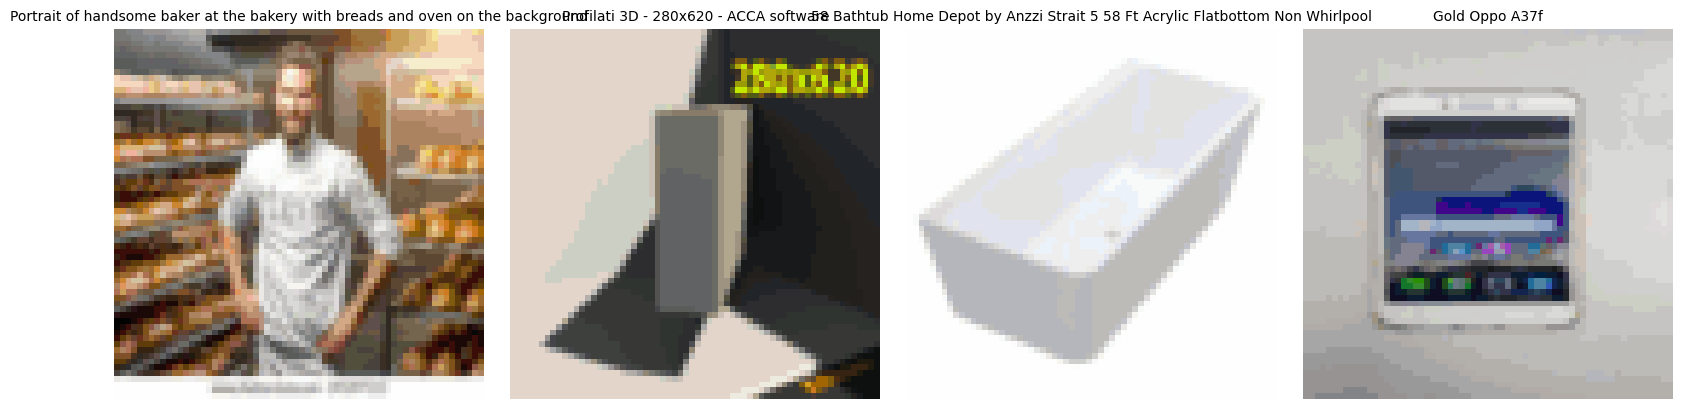

Predicting noise...
predicted noise
loss: 1.1020957231521606


Epoch 1/1: 9it [01:07,  4.33s/it, Loss=1.1021, Total Images=288, Steps=9]

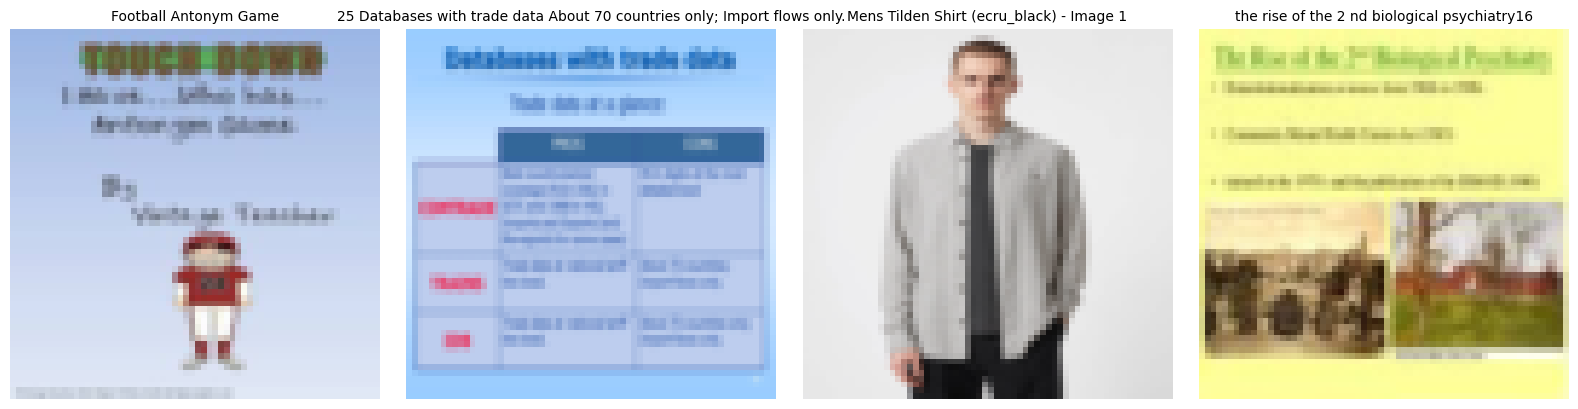

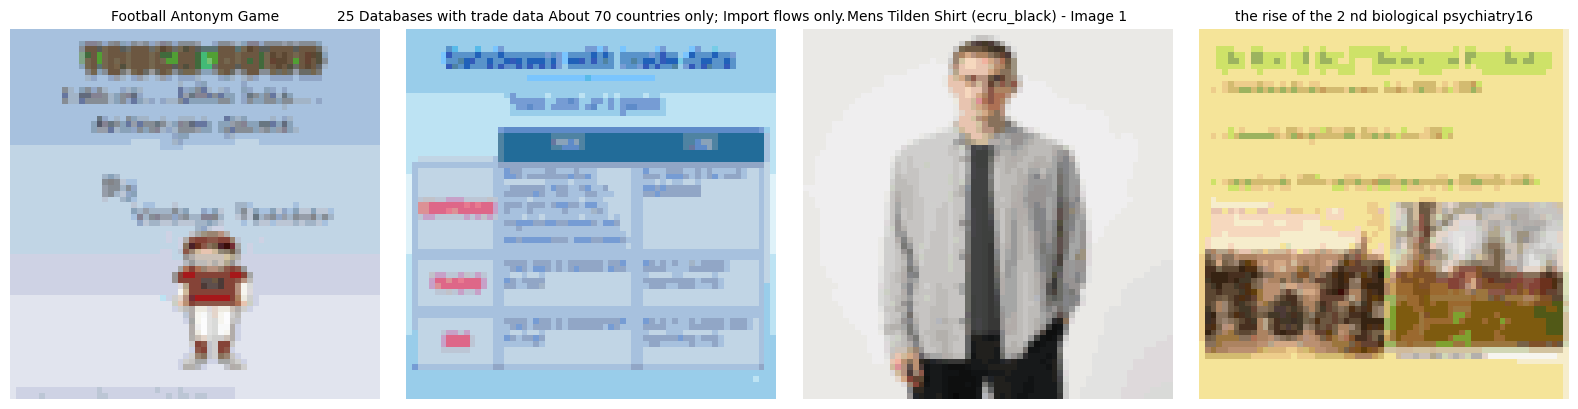

Predicting noise...
predicted noise
loss: 1.0291838645935059


Epoch 1/1: 10it [01:10,  4.13s/it, Loss=1.0292, Total Images=320, Steps=10]

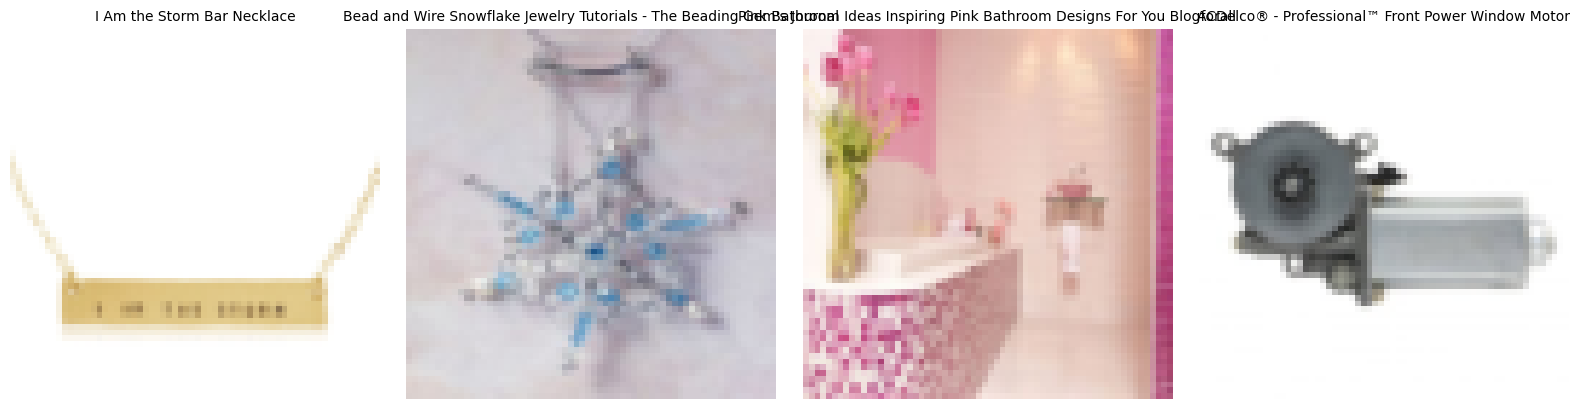

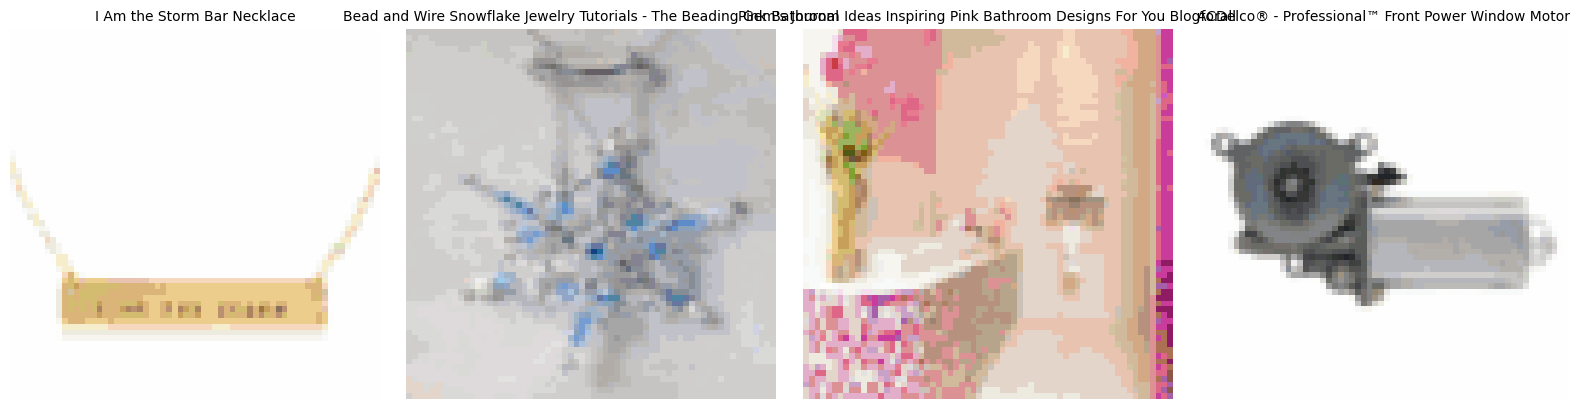

Predicting noise...
predicted noise
loss: 1.0025755167007446


Epoch 1/1: 11it [01:14,  4.06s/it, Loss=1.0026, Total Images=352, Steps=11]

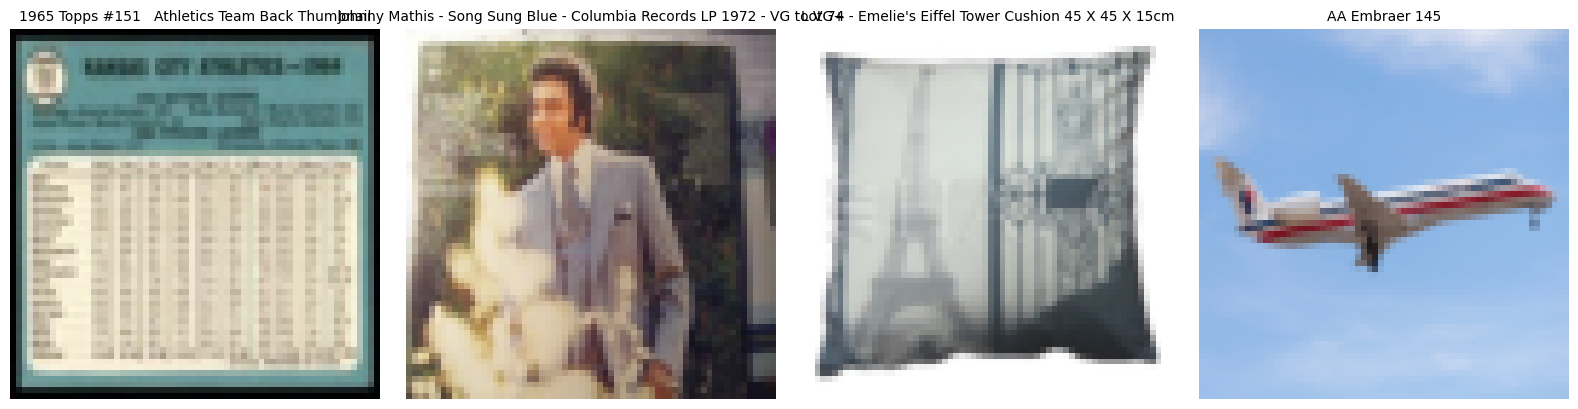

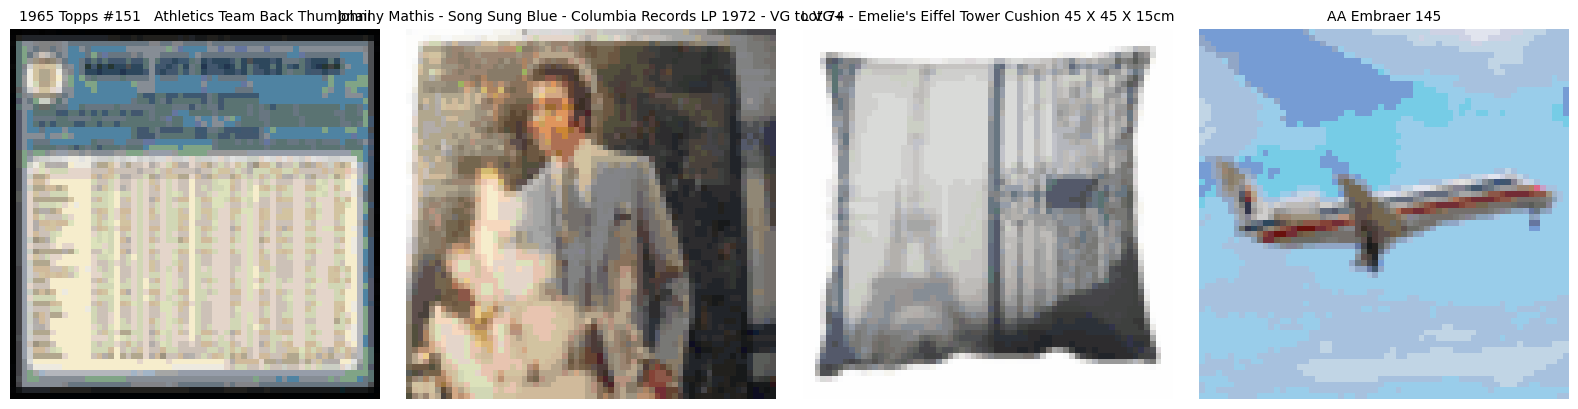

Predicting noise...
predicted noise
loss: 1.0649625062942505


Epoch 1/1: 12it [01:18,  3.95s/it, Loss=1.0650, Total Images=384, Steps=12]

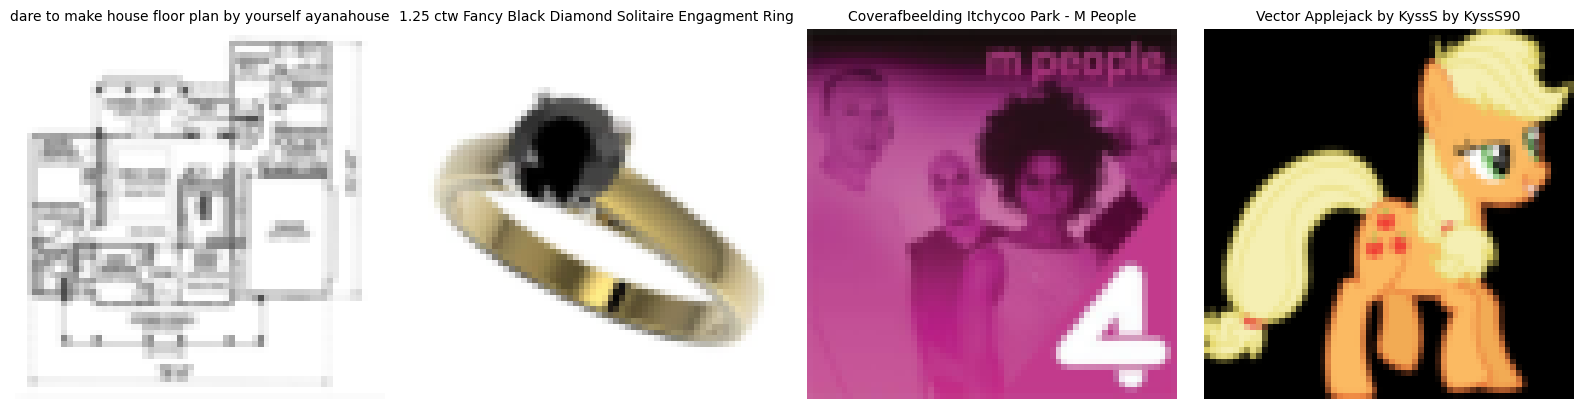

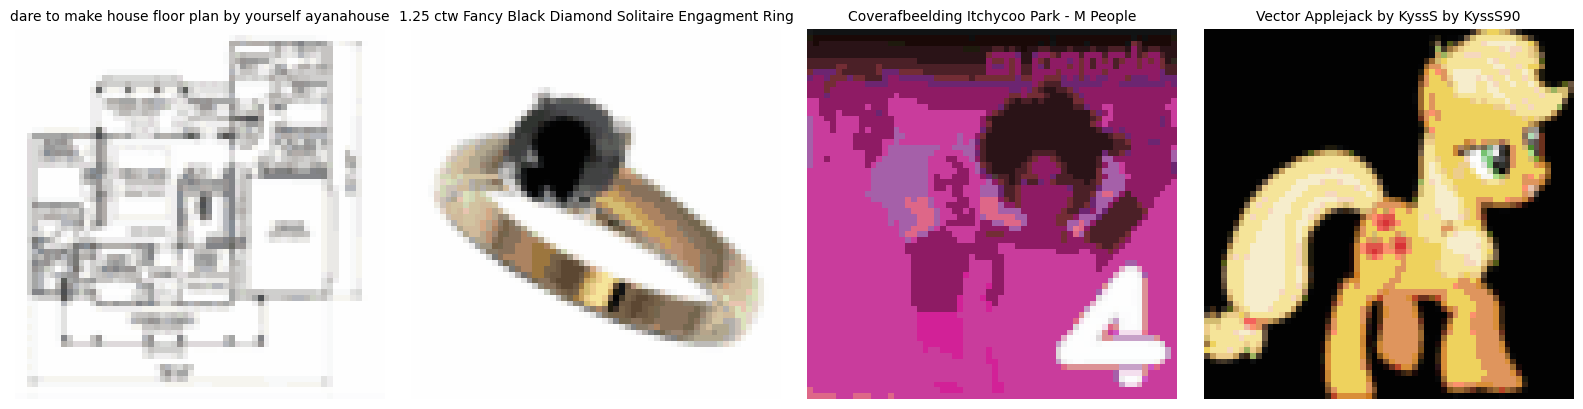

Predicting noise...
predicted noise
loss: 1.1036866903305054


Epoch 1/1: 13it [01:22,  3.89s/it, Loss=1.1037, Total Images=416, Steps=13]

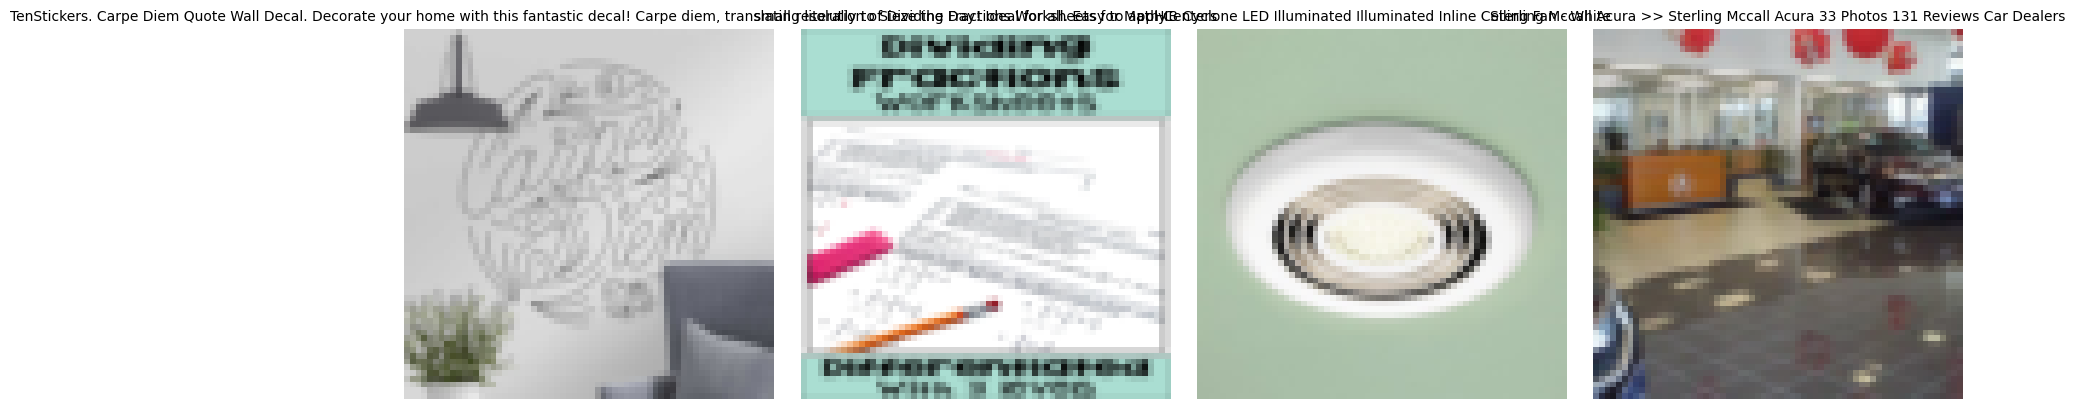

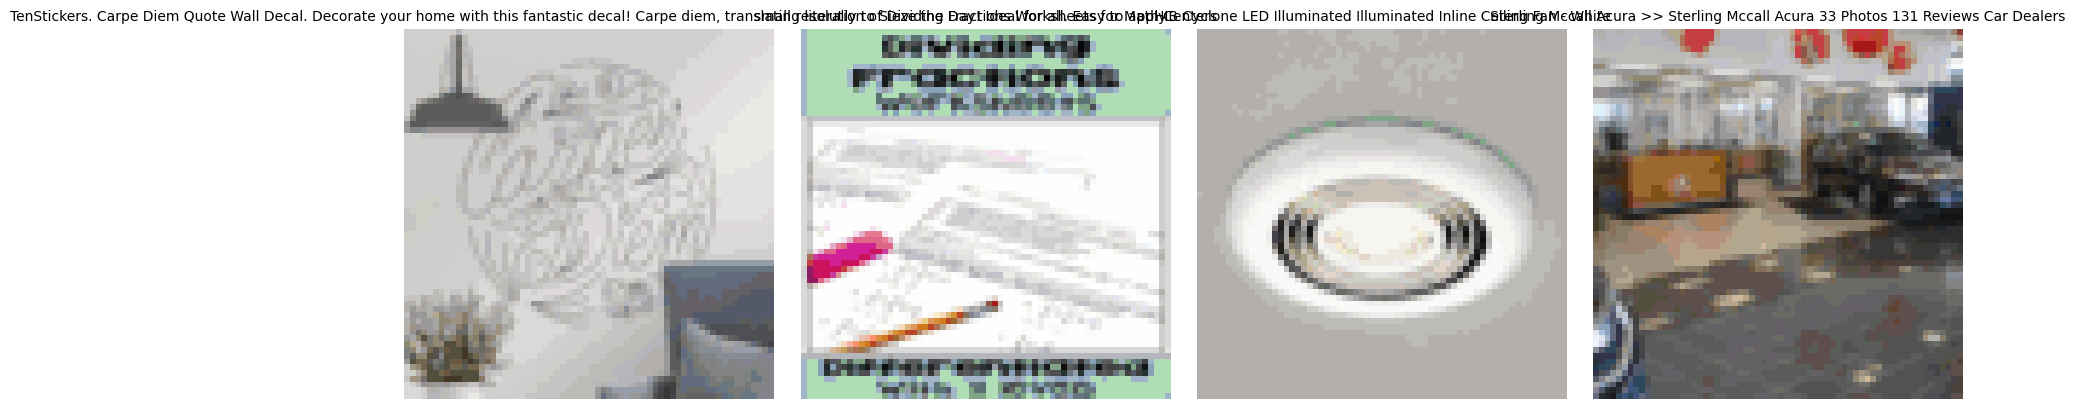

Predicting noise...
predicted noise
loss: 1.0503791570663452


Epoch 1/1: 14it [01:25,  3.86s/it, Loss=1.0504, Total Images=448, Steps=14]

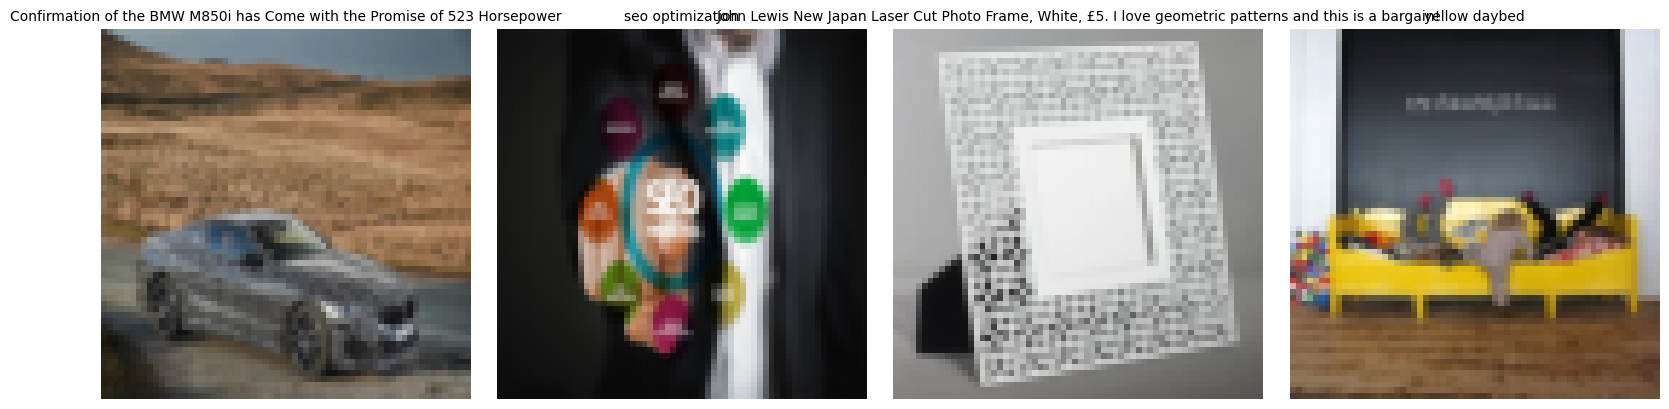

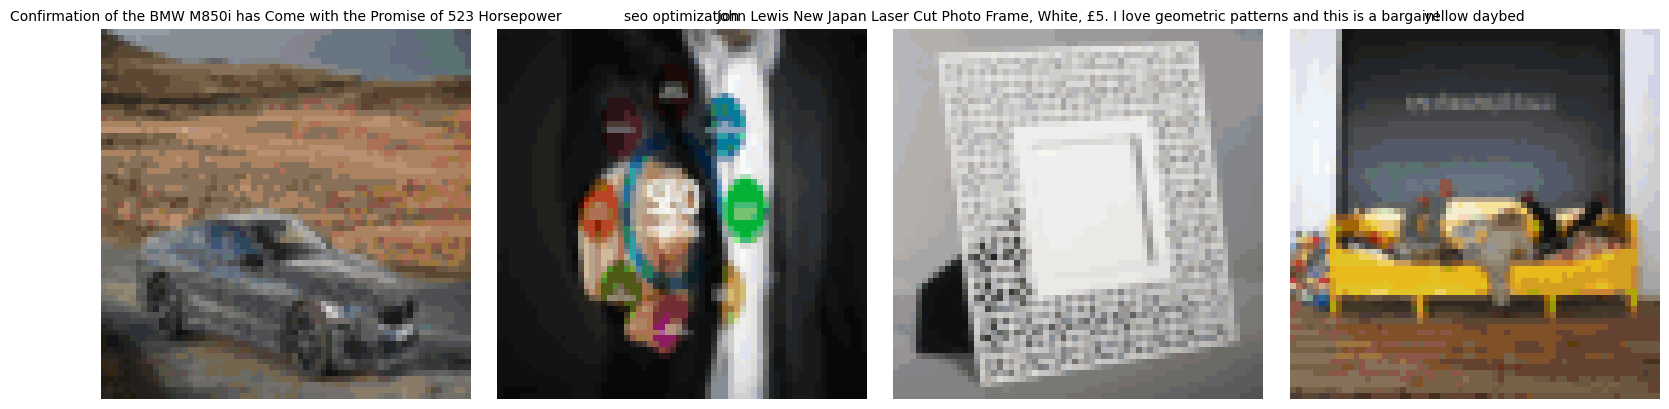

Predicting noise...
predicted noise
loss: 0.997382402420044


Epoch 1/1: 15it [01:29,  3.81s/it, Loss=0.9974, Total Images=480, Steps=15]

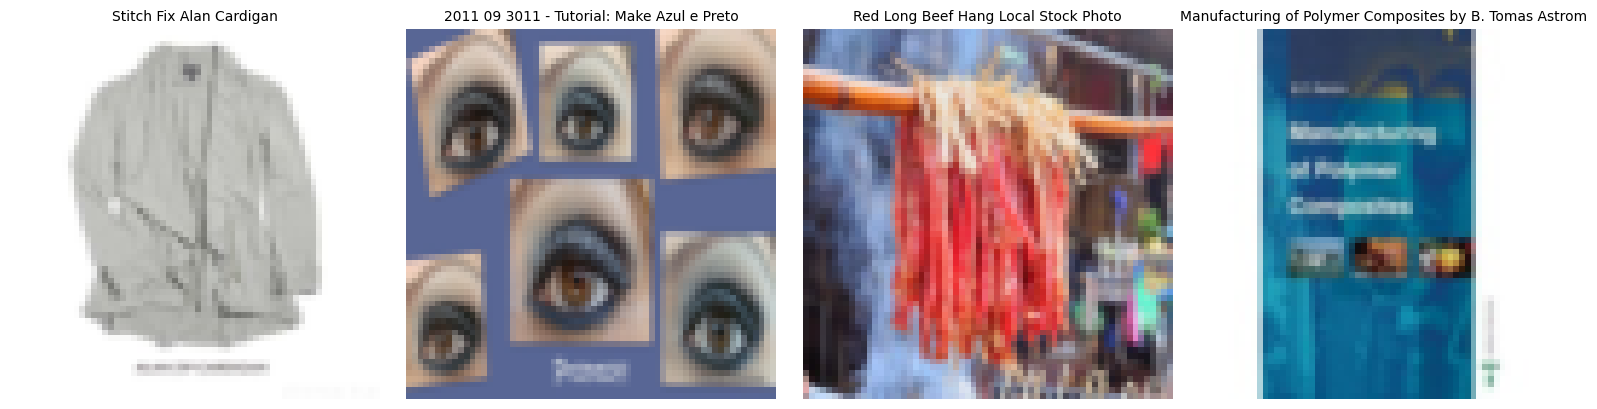

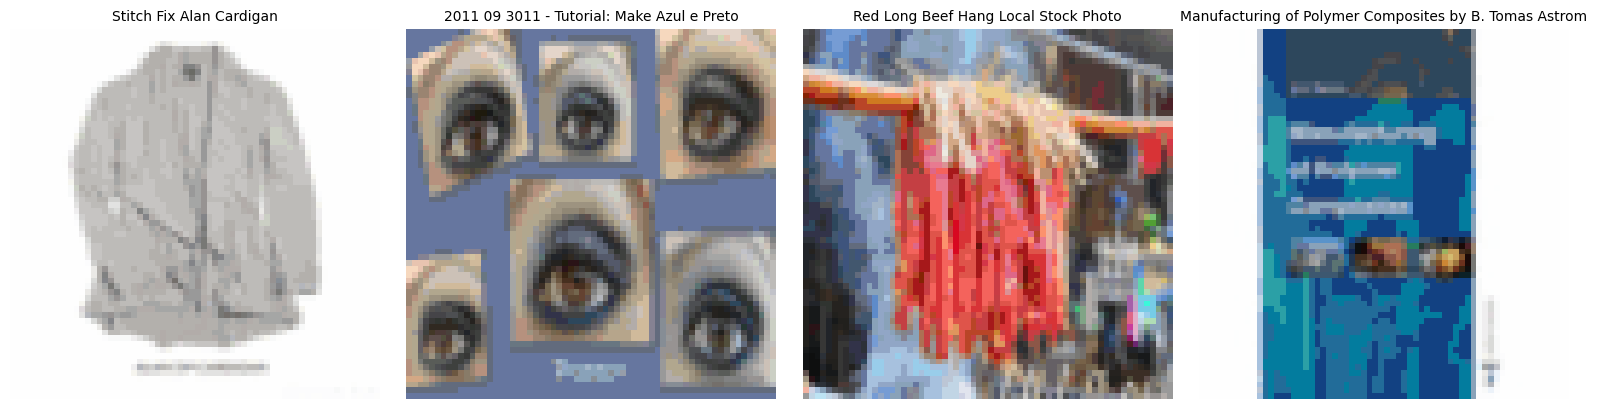

Predicting noise...
predicted noise
loss: 1.0112638473510742


Epoch 1/1: 16it [01:33,  3.83s/it, Loss=1.0113, Total Images=512, Steps=16]

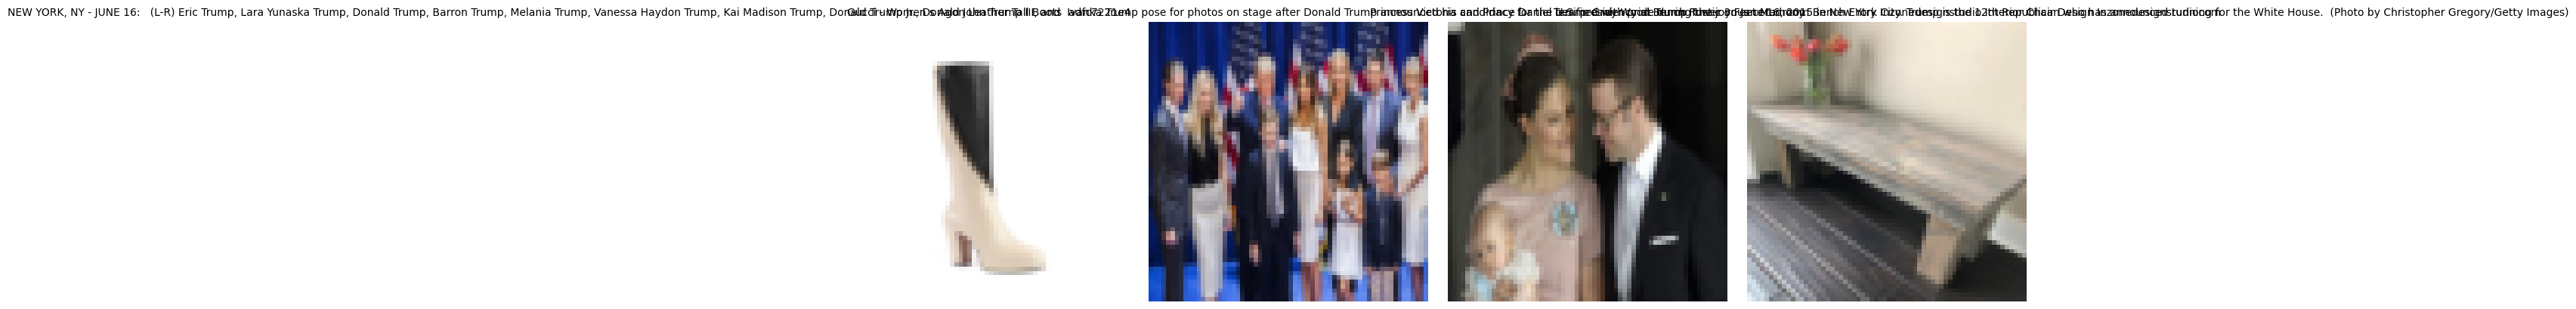

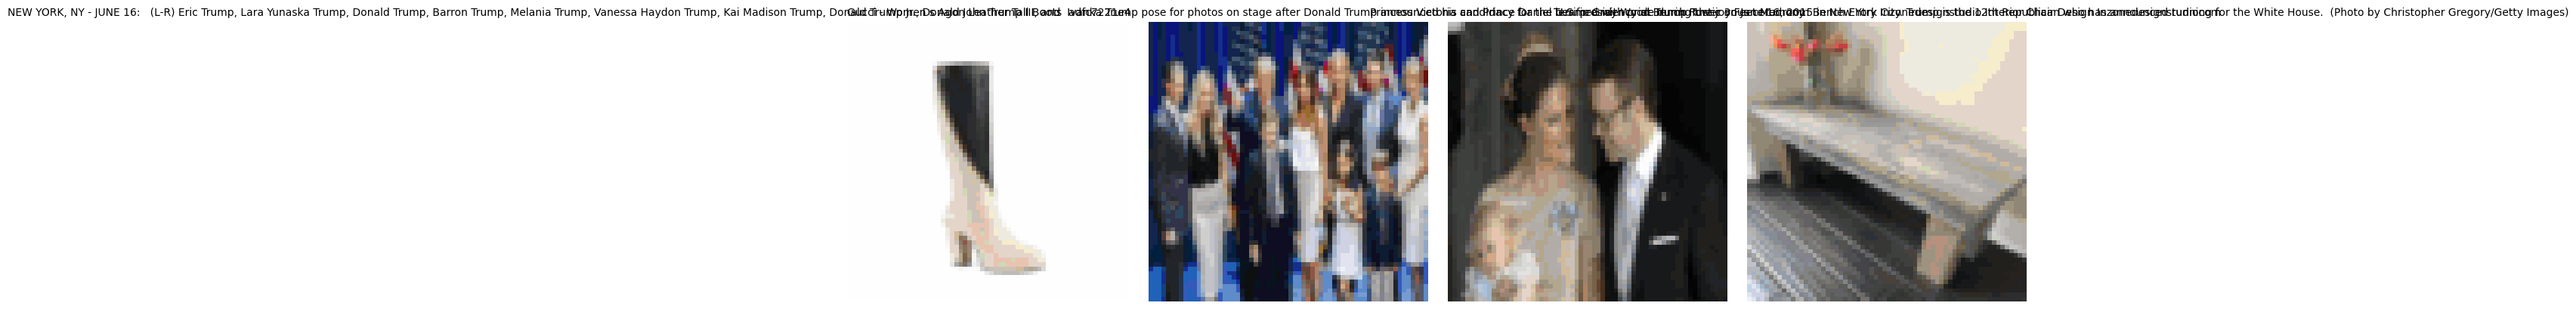

Predicting noise...
predicted noise
loss: 1.0489962100982666


Epoch 1/1: 17it [01:51,  7.95s/it, Loss=1.0490, Total Images=544, Steps=17]

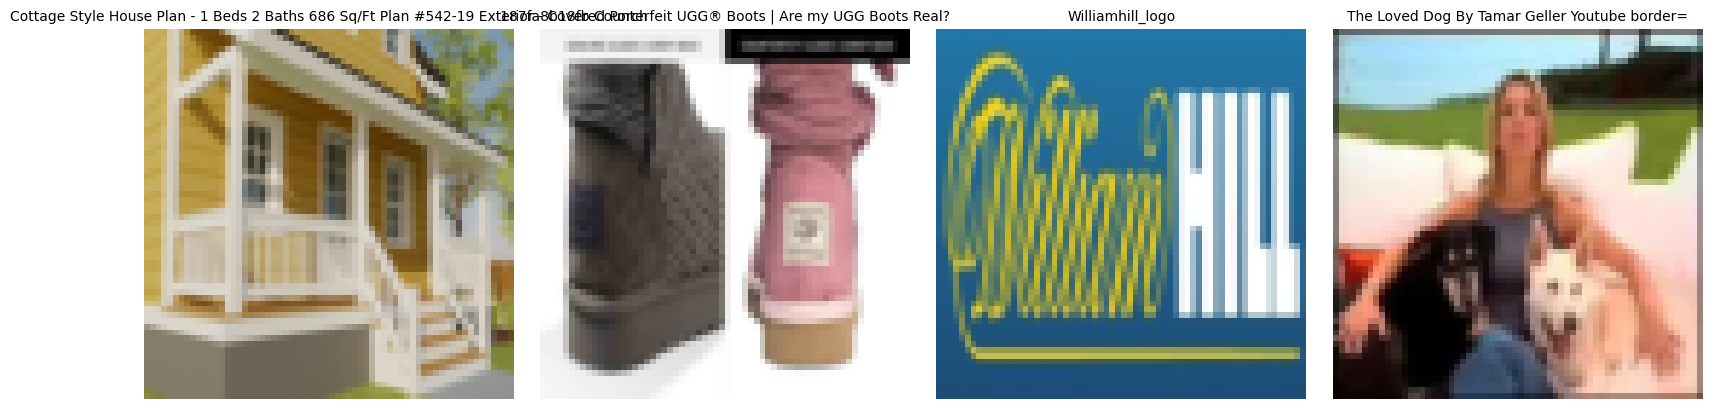

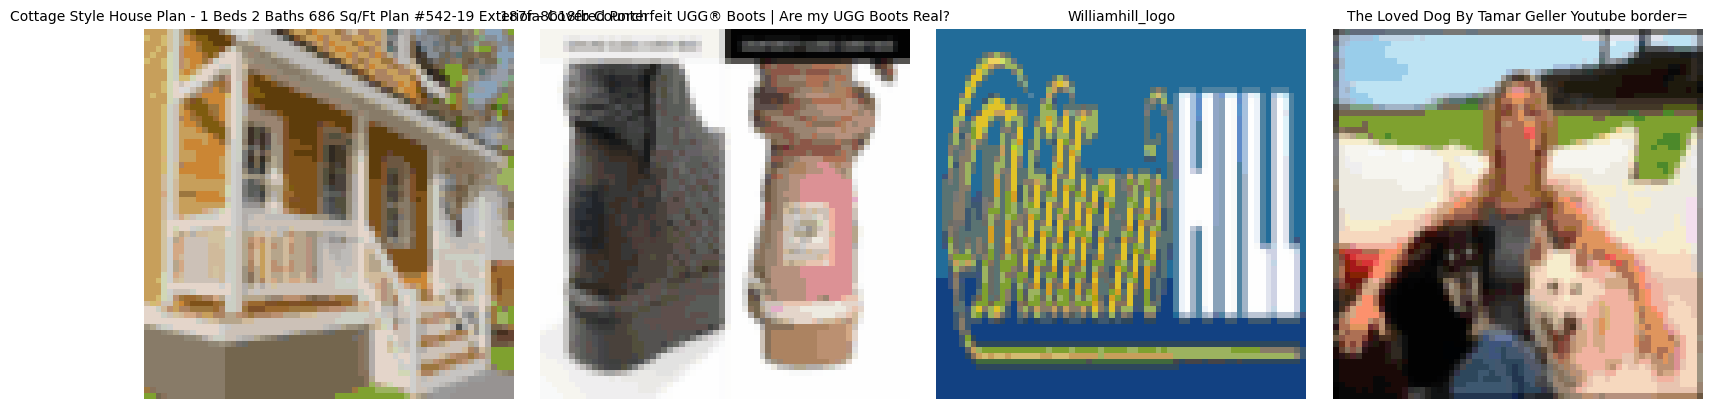

Predicting noise...
predicted noise
loss: 1.050550937652588


Epoch 1/1: 18it [01:54,  6.68s/it, Loss=1.0506, Total Images=576, Steps=18]

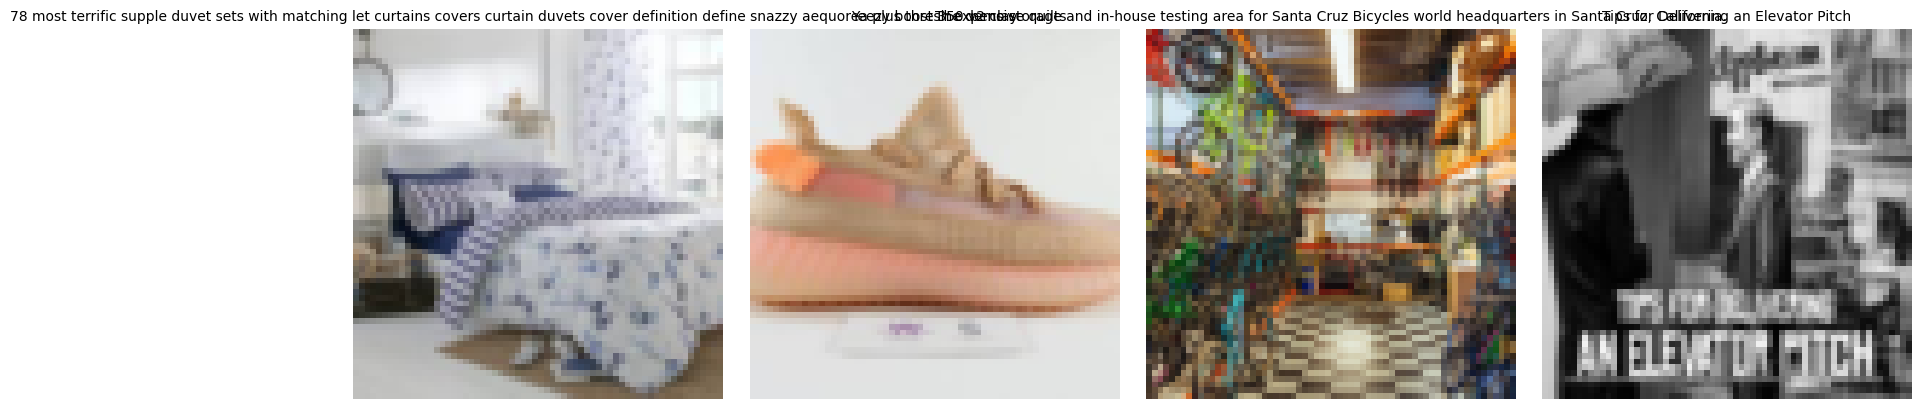

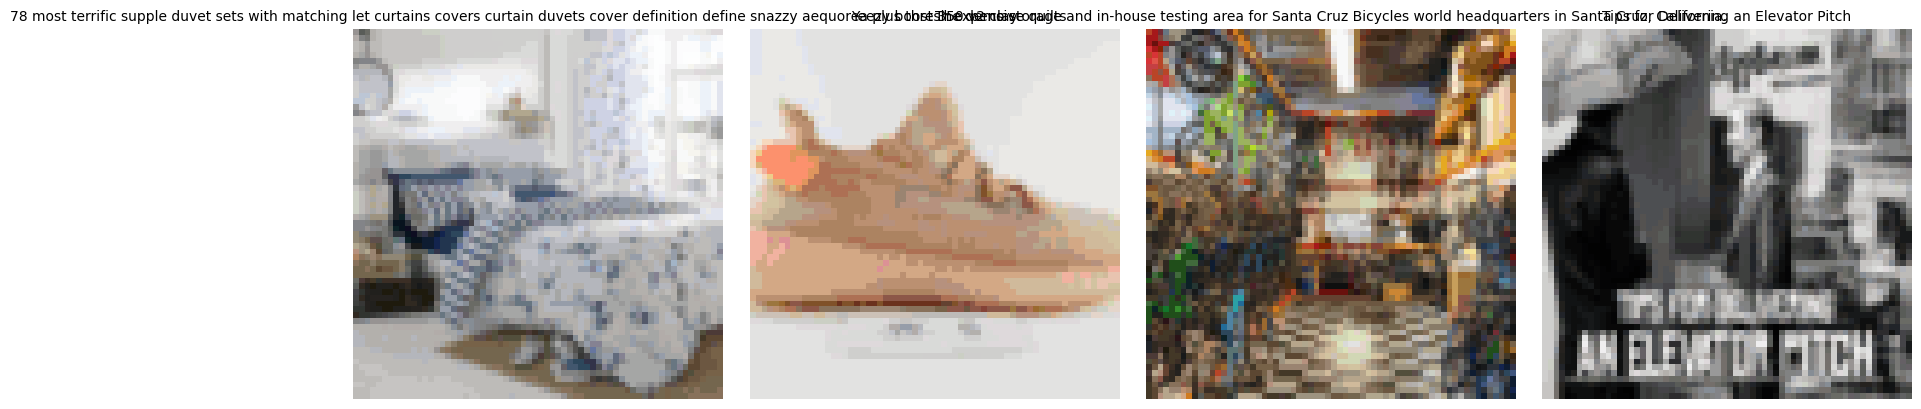

Predicting noise...
predicted noise
loss: 1.0270293951034546


Epoch 1/1: 19it [01:58,  5.85s/it, Loss=1.0270, Total Images=608, Steps=19]

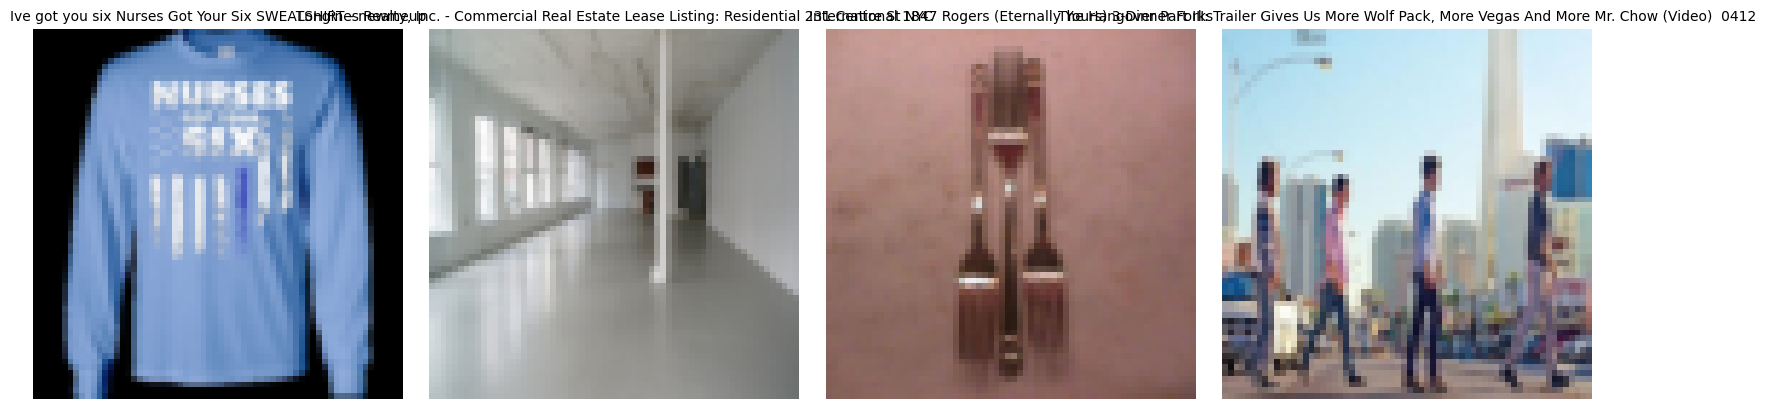

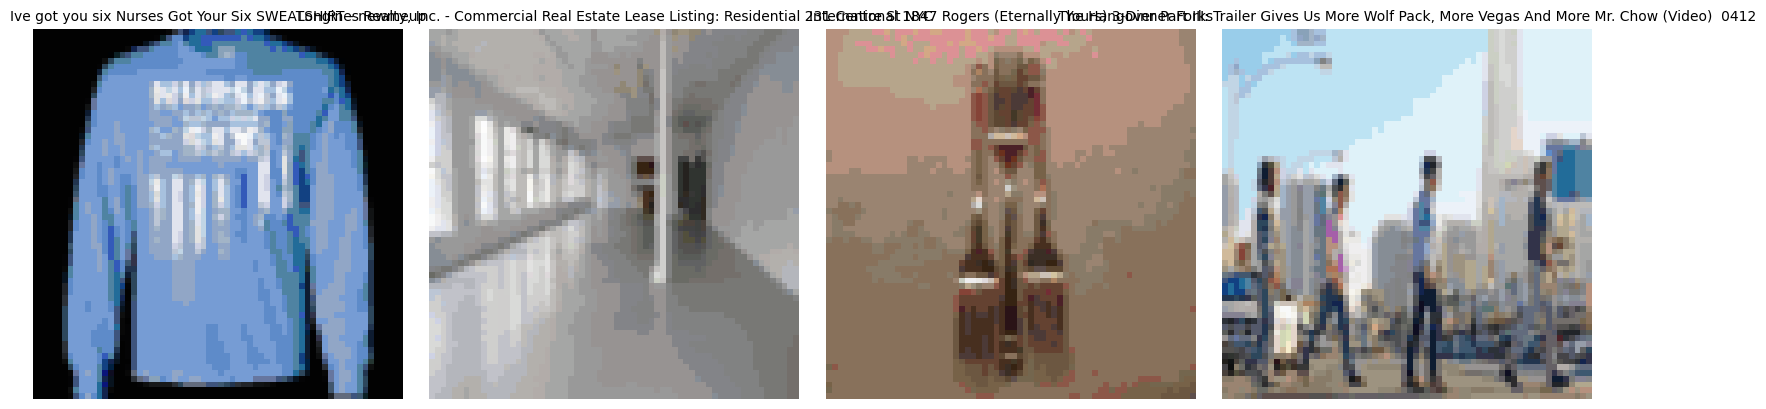

Predicting noise...
predicted noise
loss: 1.0014281272888184


Epoch 1/1: 20it [02:02,  5.22s/it, Loss=1.0014, Total Images=640, Steps=20]

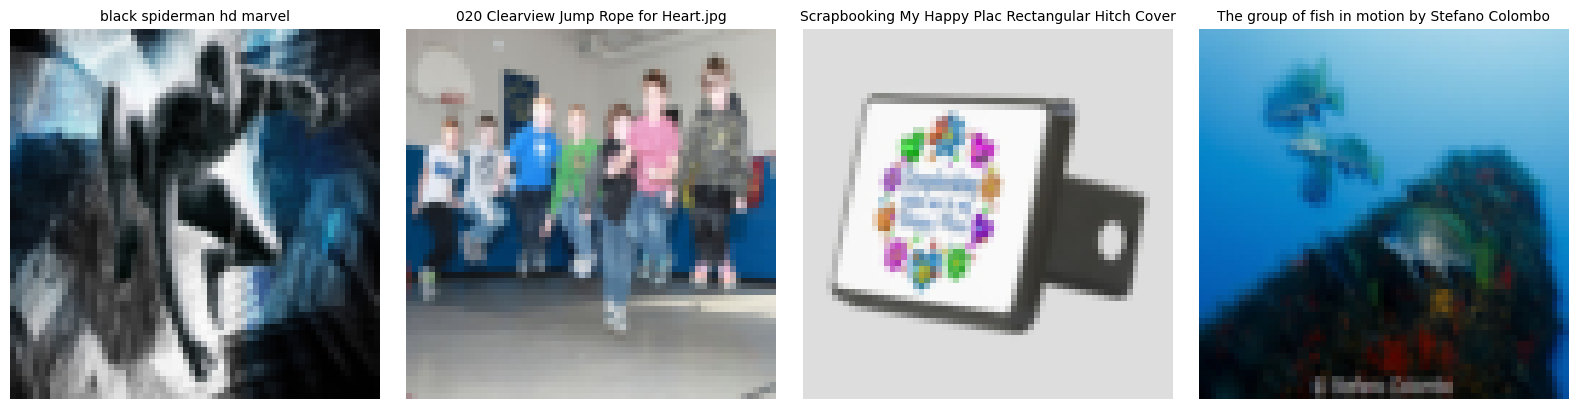

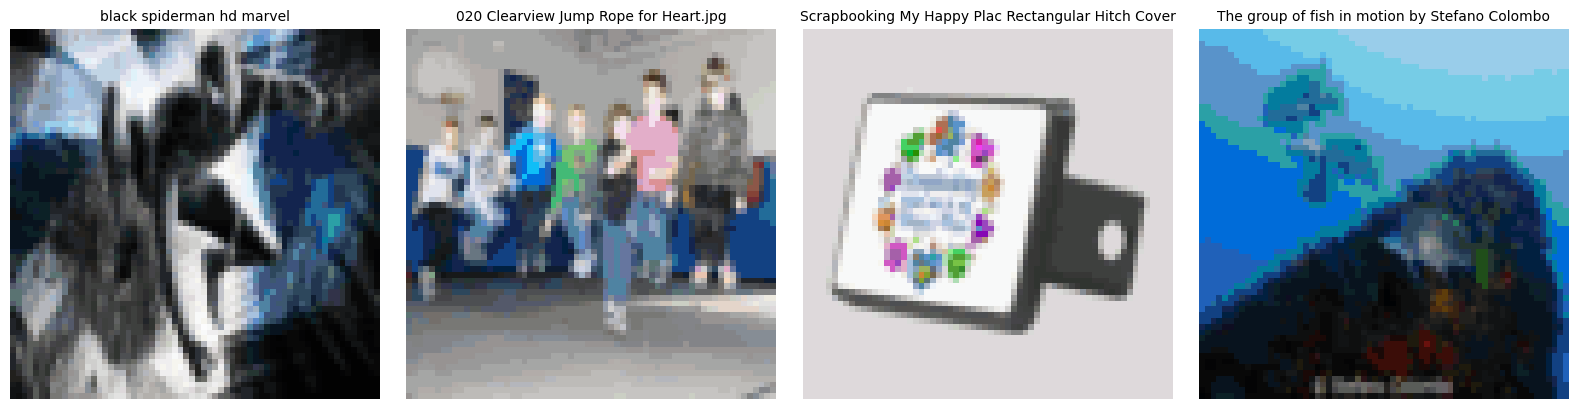

Predicting noise...
predicted noise
loss: 1.0082707405090332


Epoch 1/1: 21it [02:06,  4.77s/it, Loss=1.0083, Total Images=672, Steps=21]

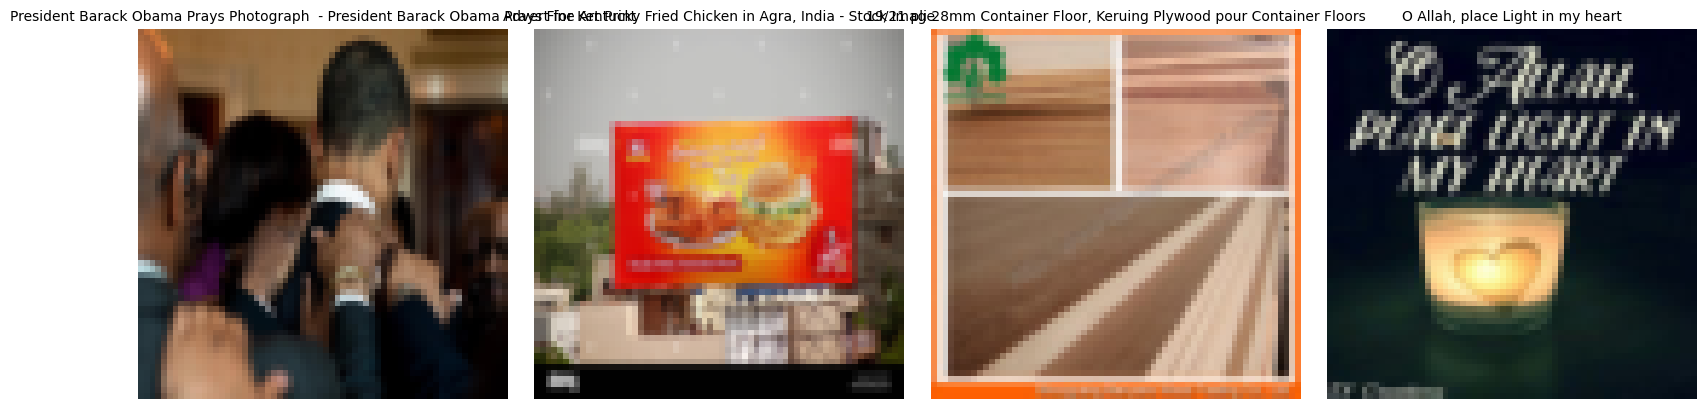

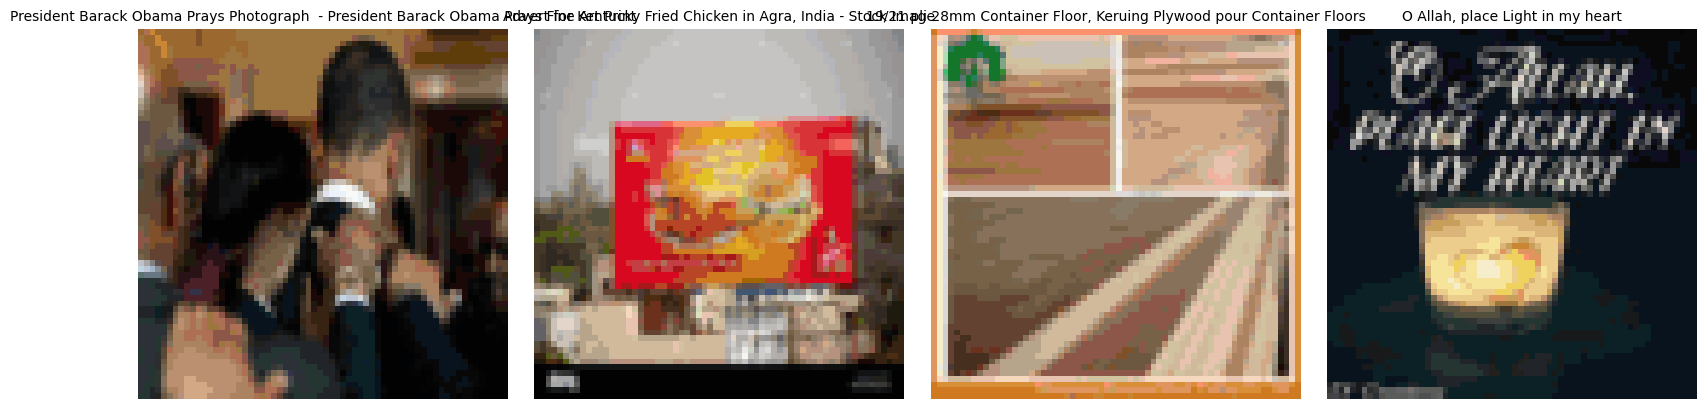

Predicting noise...
predicted noise
loss: 1.0268616676330566


Epoch 1/1: 22it [02:09,  4.46s/it, Loss=1.0269, Total Images=704, Steps=22]

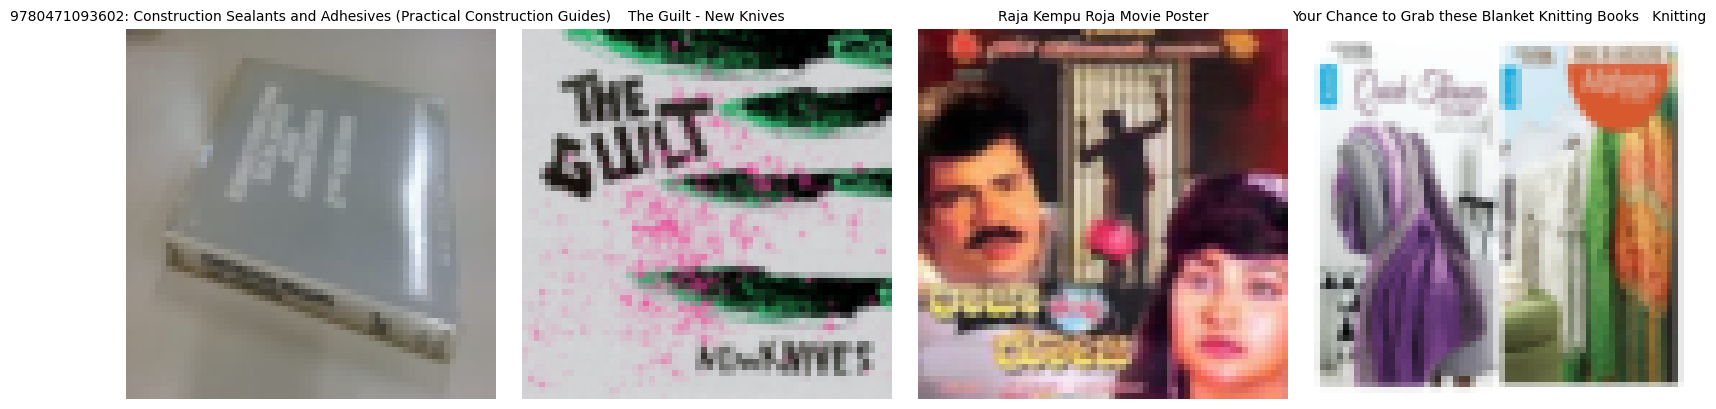

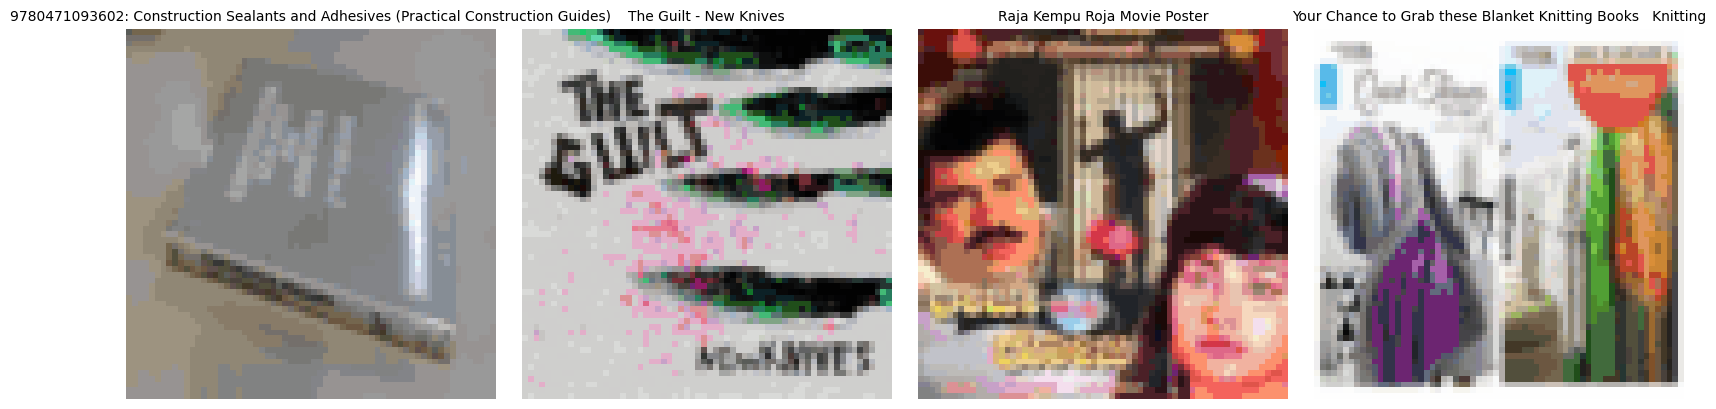

Predicting noise...
predicted noise
loss: 1.0342559814453125


Epoch 1/1: 23it [02:13,  4.24s/it, Loss=1.0343, Total Images=736, Steps=23]

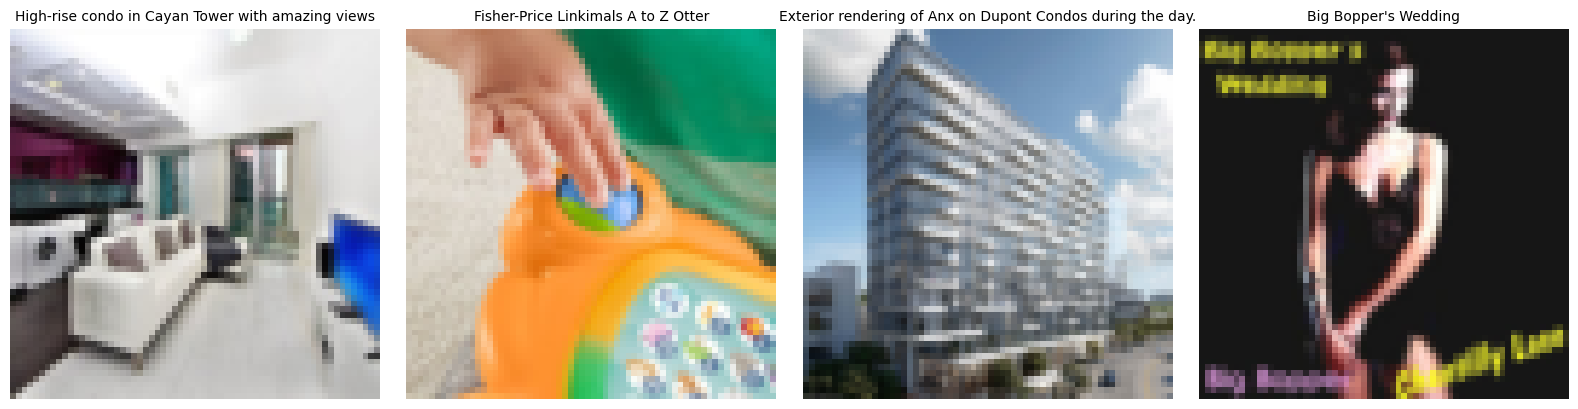

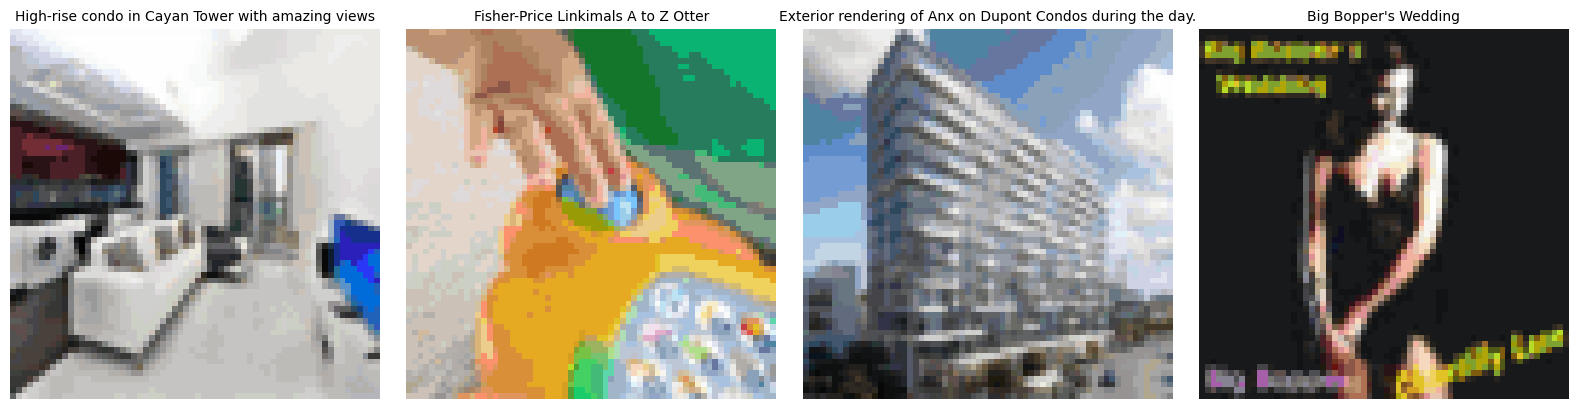

Predicting noise...
predicted noise
loss: 1.0170155763626099


Epoch 1/1: 24it [02:17,  4.08s/it, Loss=1.0170, Total Images=768, Steps=24]

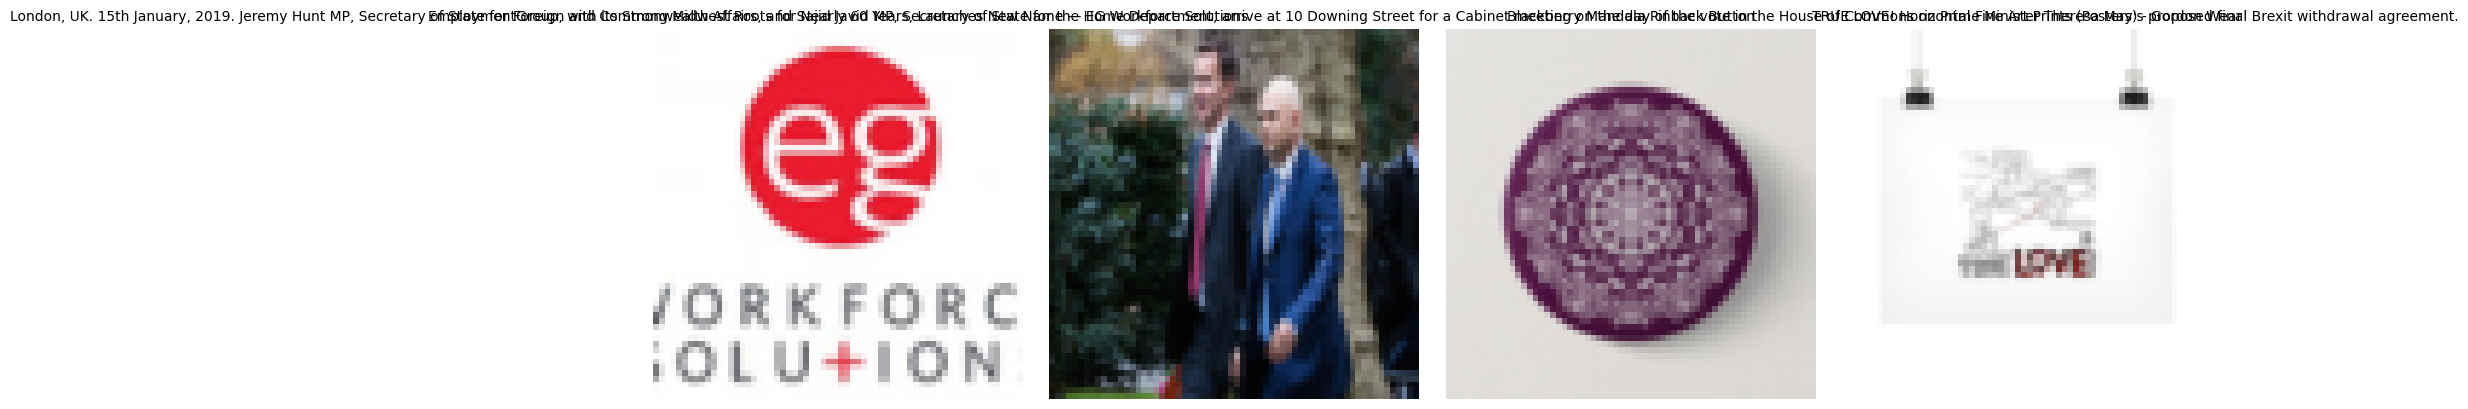

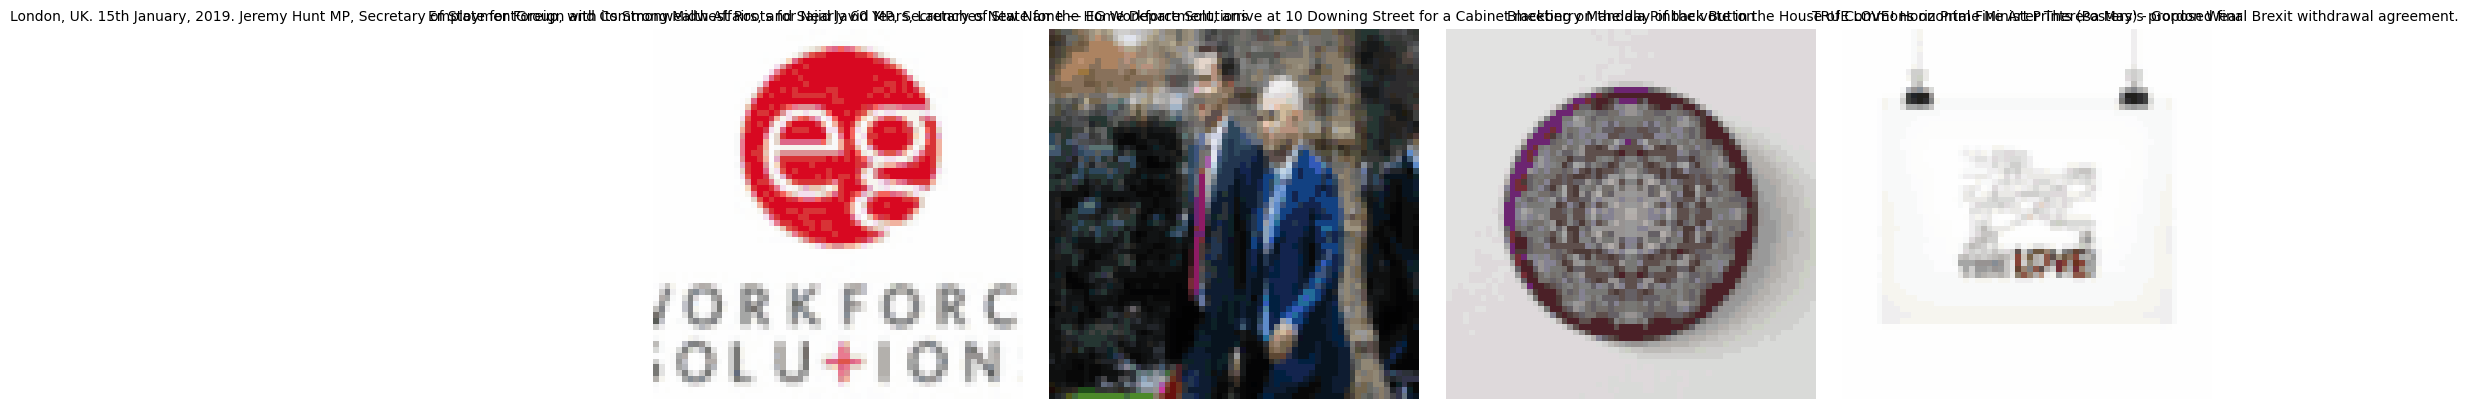

Predicting noise...
predicted noise
loss: 1.000880241394043


Epoch 1/1: 25it [02:21,  4.02s/it, Loss=1.0009, Total Images=800, Steps=25]

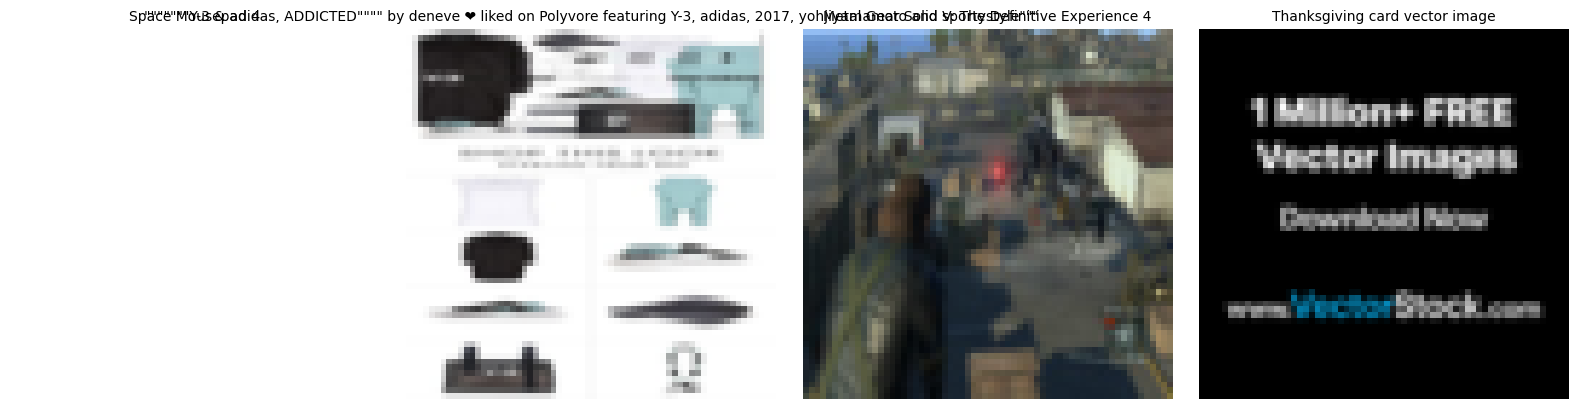

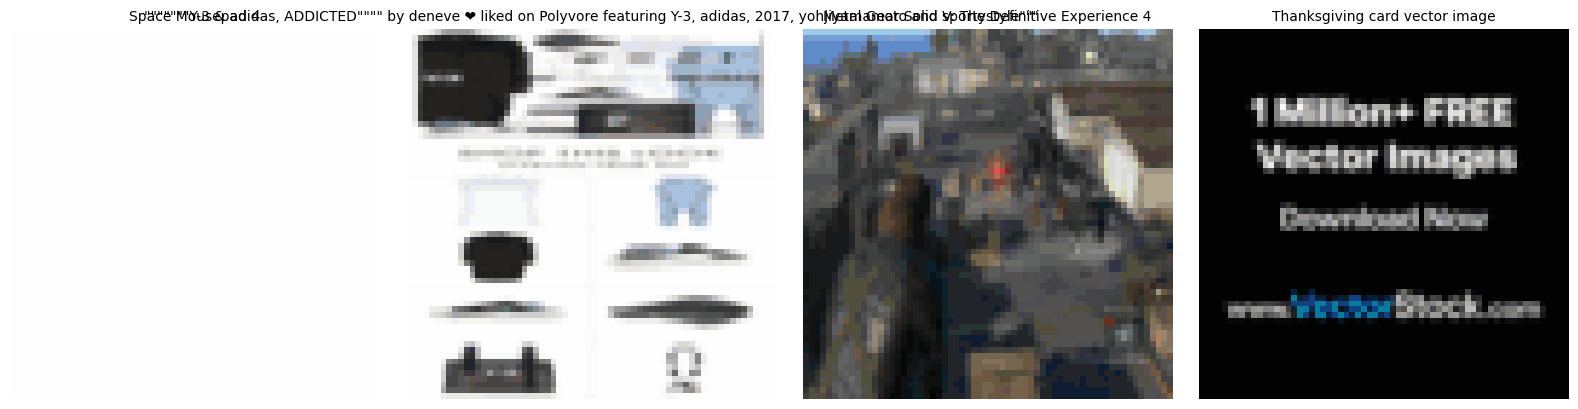

Predicting noise...
predicted noise
loss: 1.014538288116455


Epoch 1/1: 26it [02:24,  3.94s/it, Loss=1.0145, Total Images=832, Steps=26]

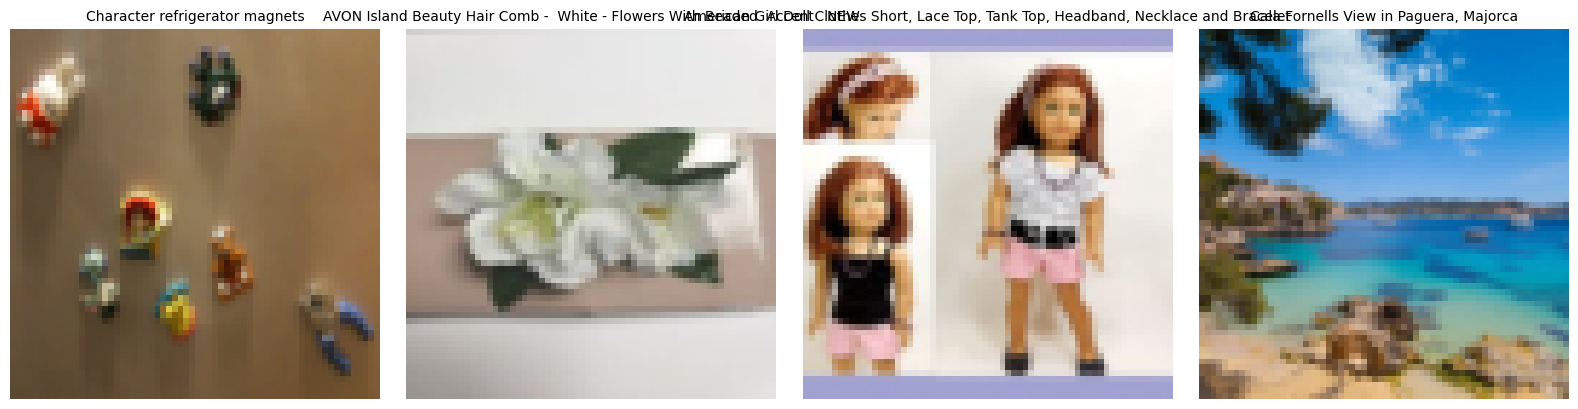

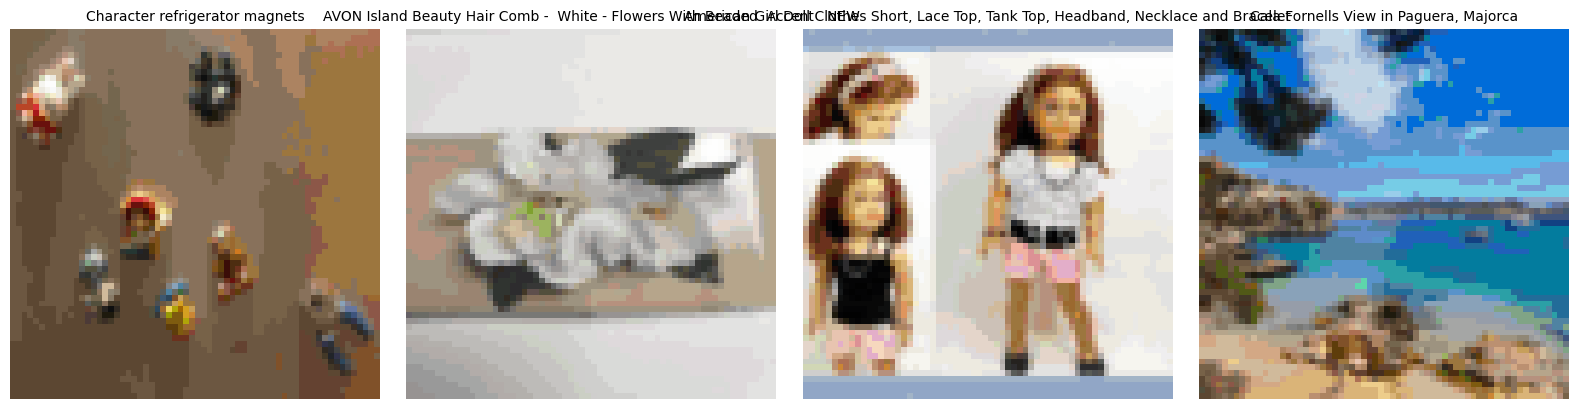

Predicting noise...
predicted noise
loss: 1.0160255432128906


Epoch 1/1: 27it [02:28,  3.88s/it, Loss=1.0160, Total Images=864, Steps=27]

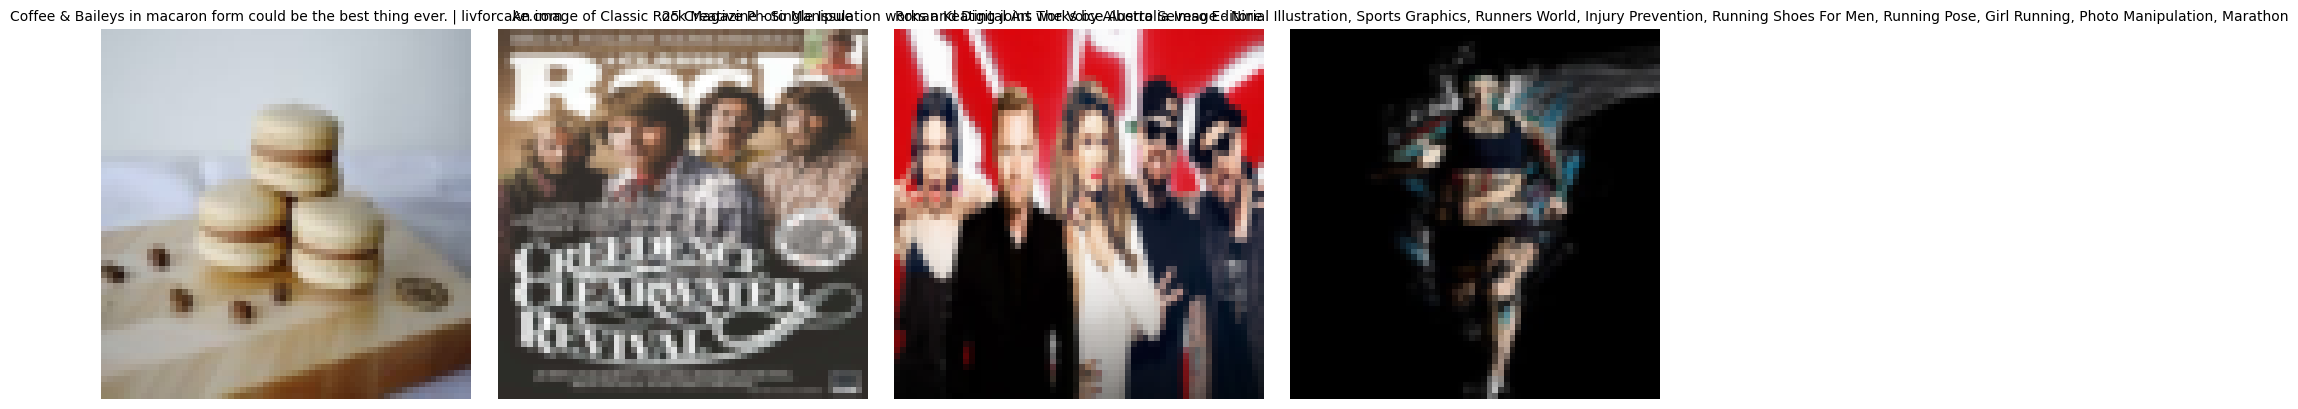

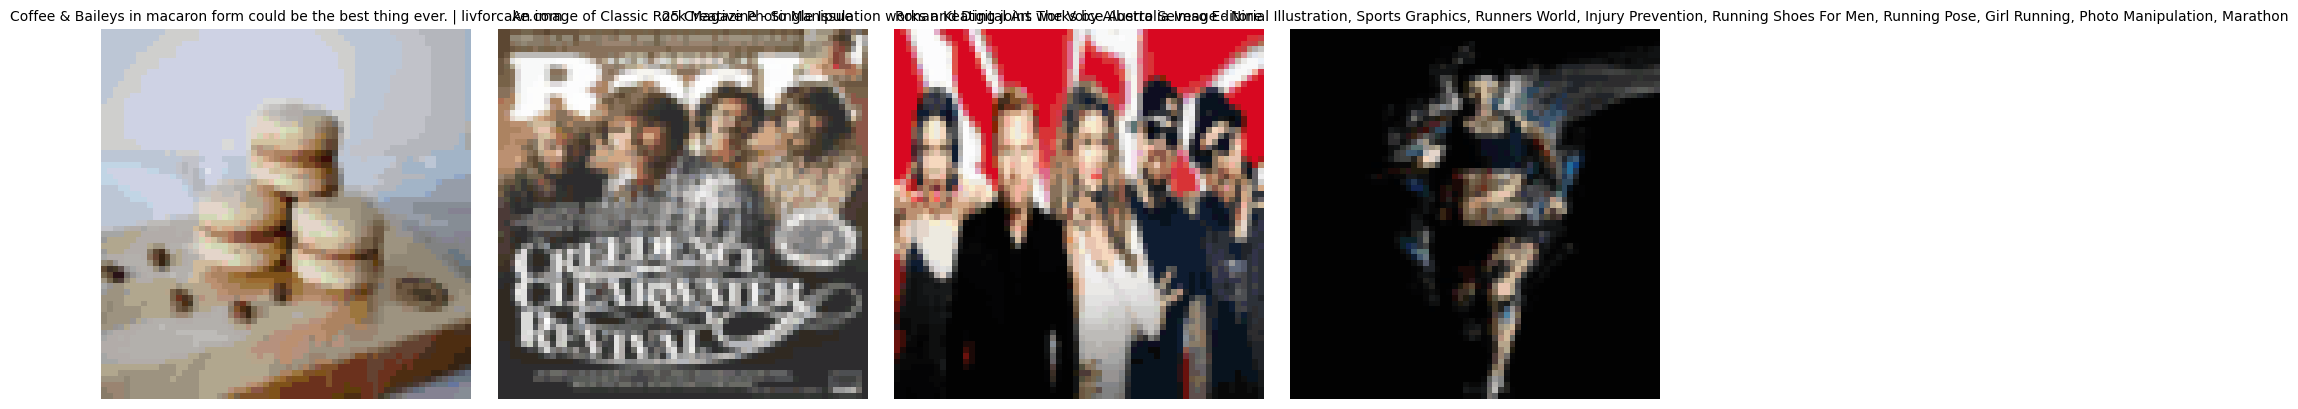

Predicting noise...
predicted noise
loss: 1.0210624933242798


Epoch 1/1: 28it [02:32,  3.86s/it, Loss=1.0211, Total Images=896, Steps=28]

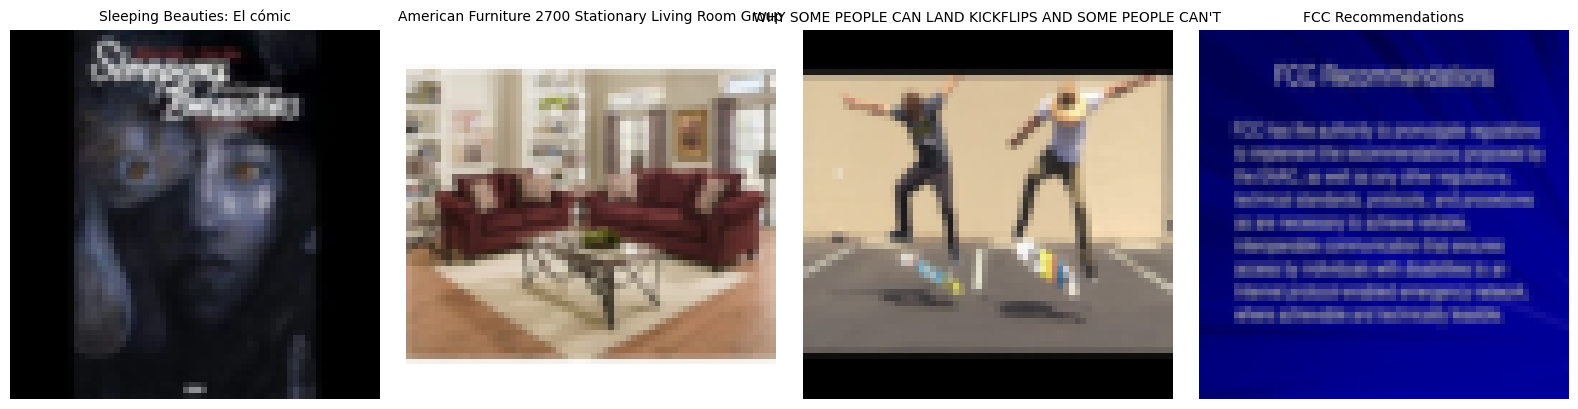

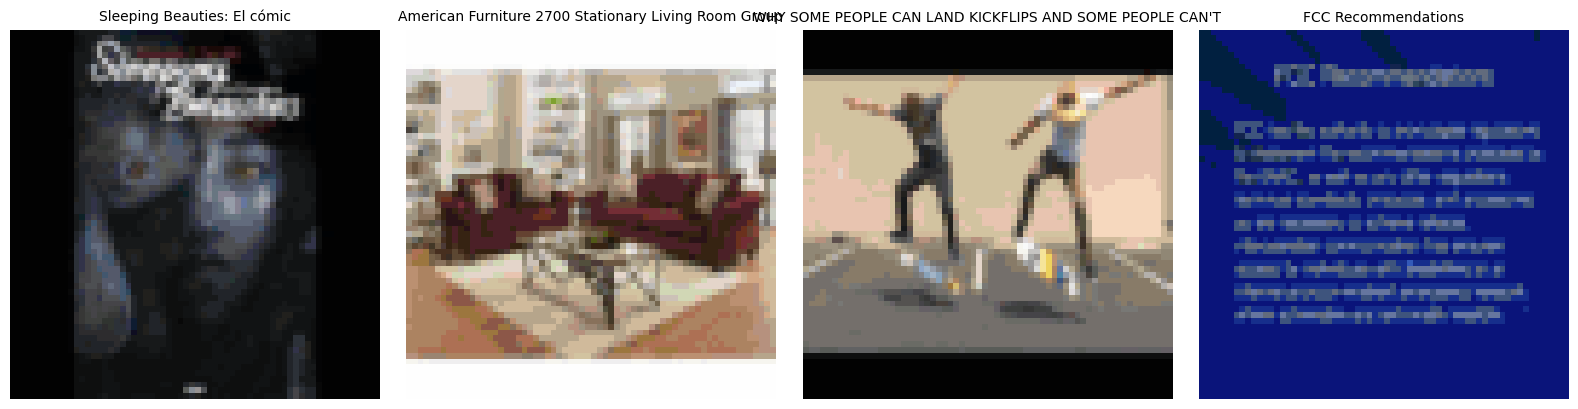

Predicting noise...
predicted noise
loss: 0.9969908595085144


Epoch 1/1: 29it [02:36,  3.82s/it, Loss=0.9970, Total Images=928, Steps=29]

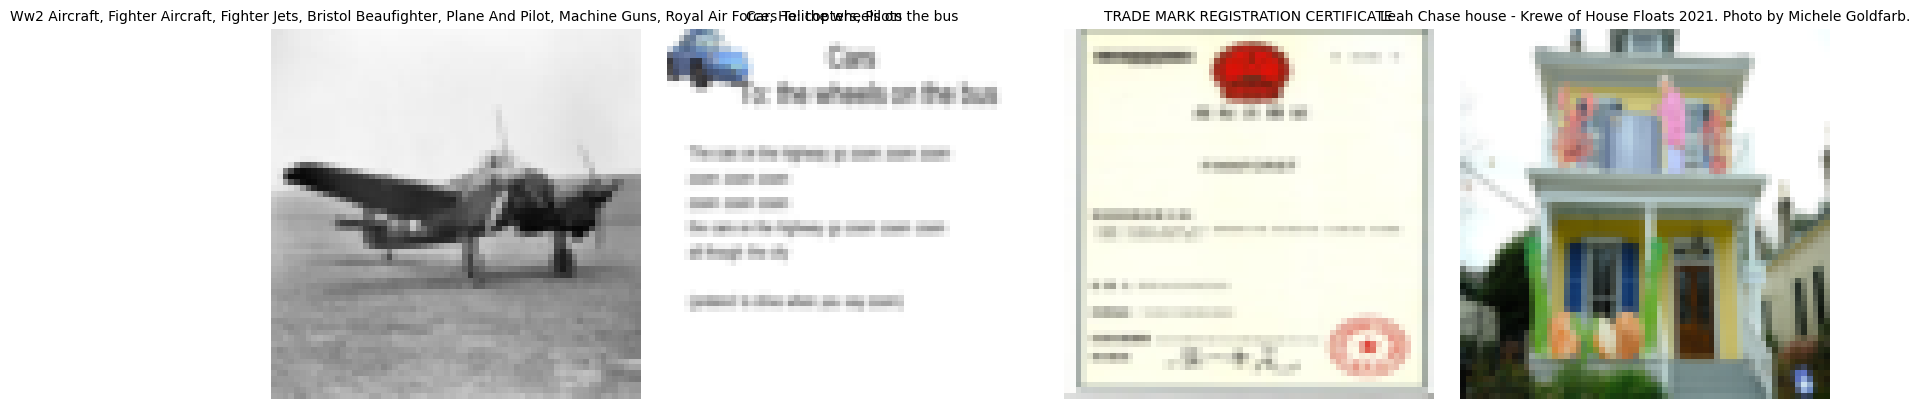

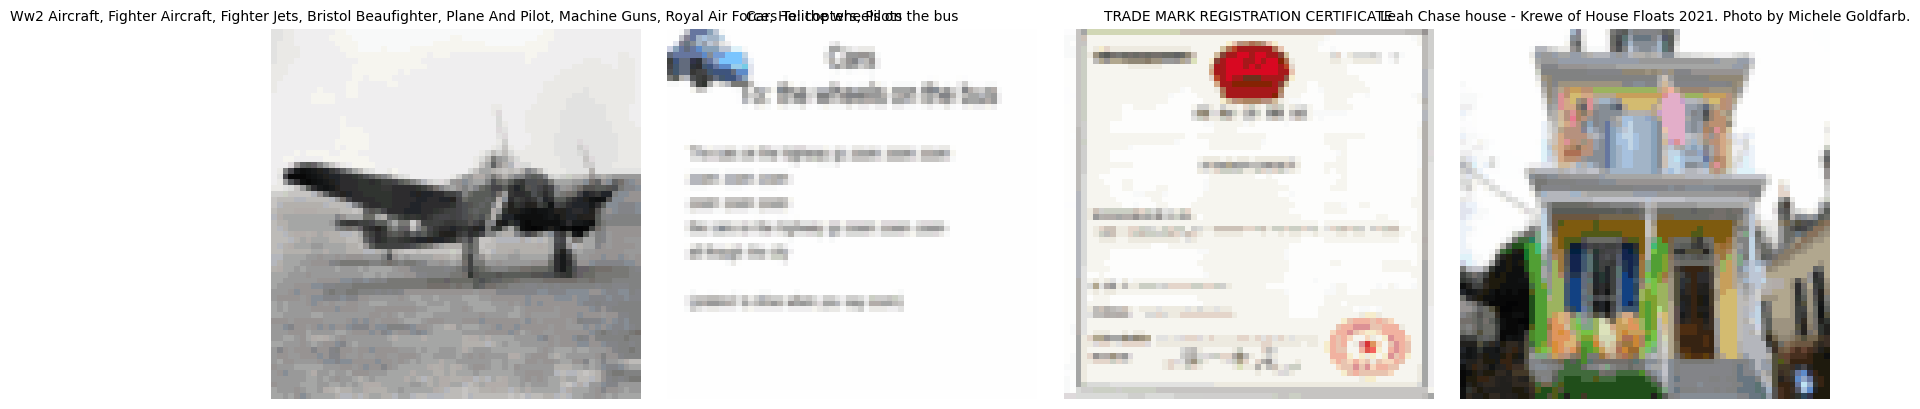

Predicting noise...
predicted noise
loss: 0.999833345413208


Epoch 1/1: 30it [02:40,  3.86s/it, Loss=0.9998, Total Images=960, Steps=30]

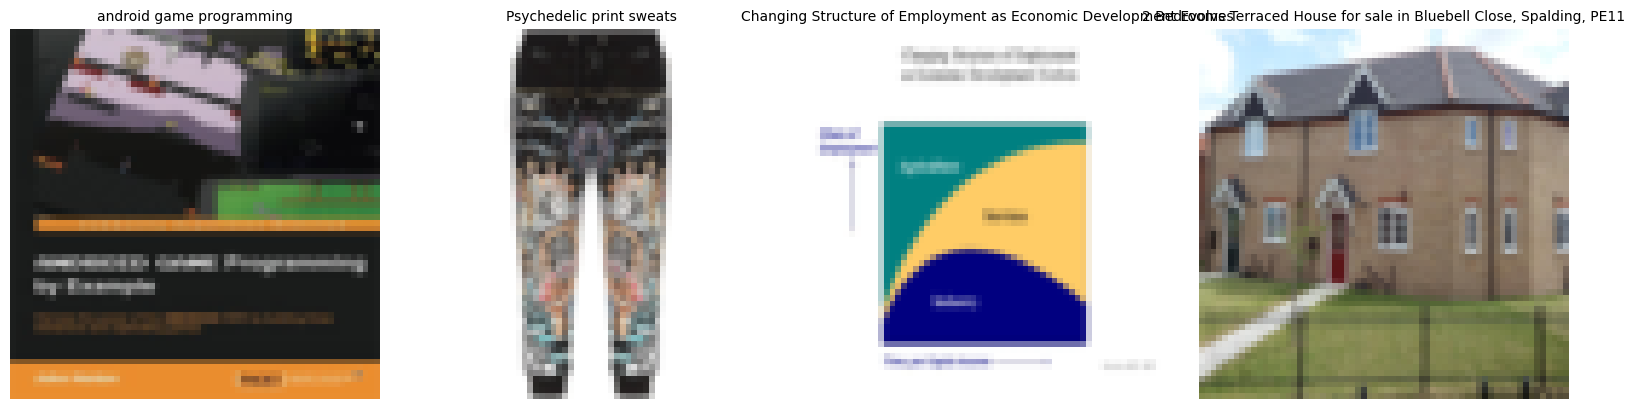

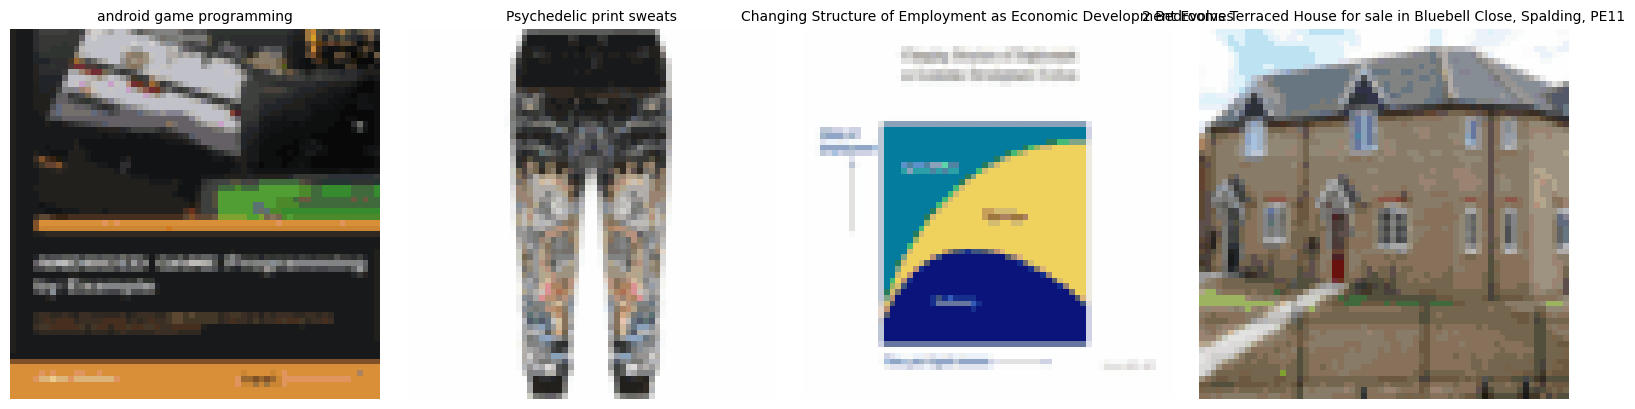

Predicting noise...
predicted noise
loss: 1.012851595878601


Epoch 1/1: 31it [02:43,  3.83s/it, Loss=1.0129, Total Images=992, Steps=31]

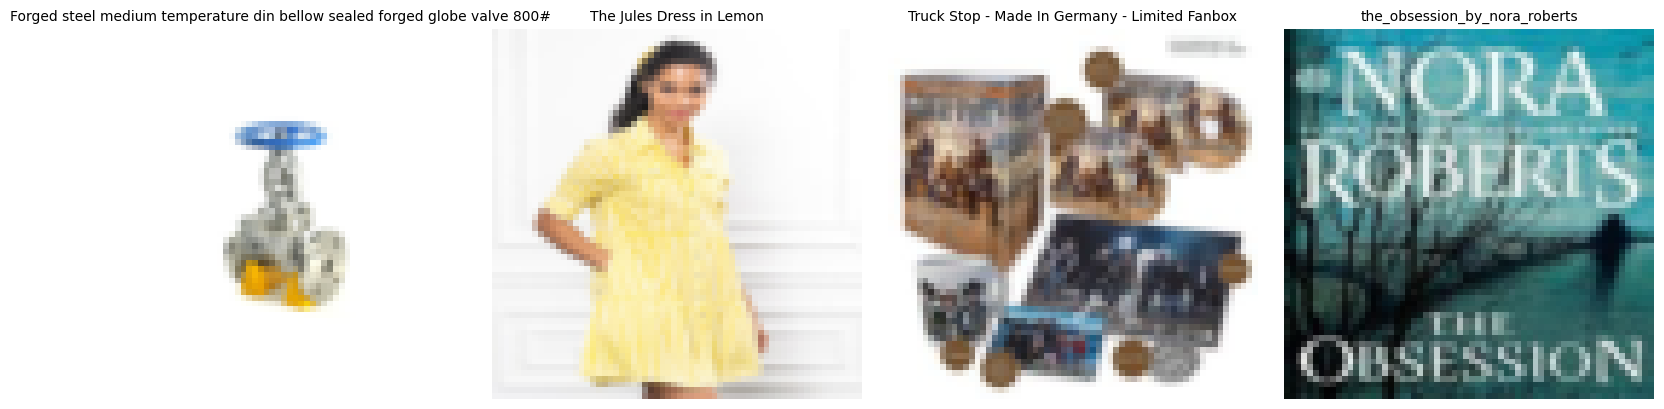

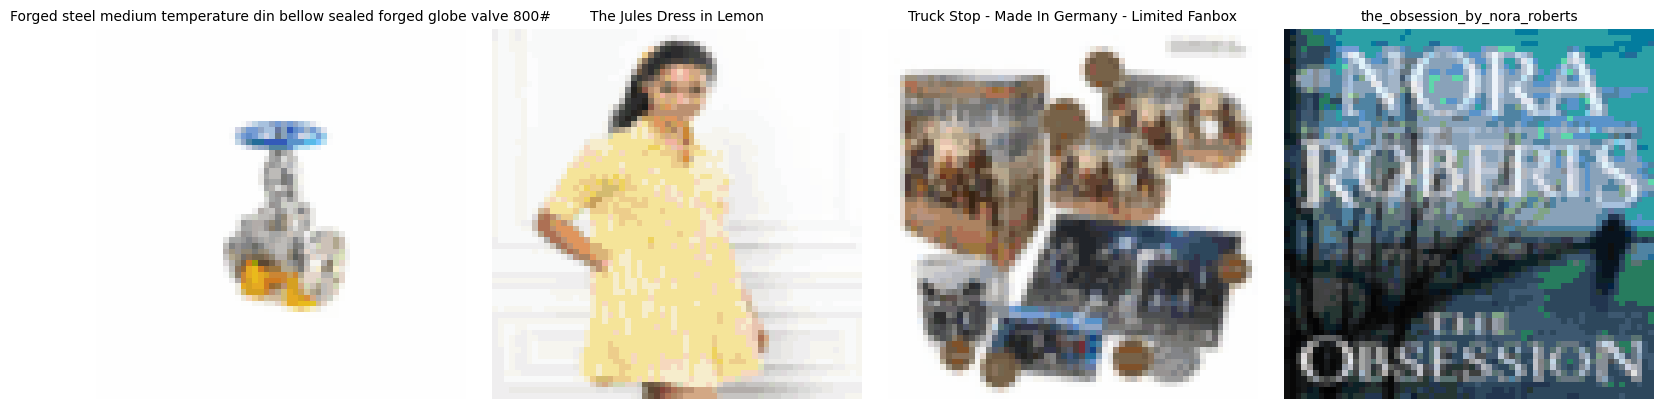

Predicting noise...
predicted noise
loss: 1.005029320716858


Epoch 1/1: 32it [02:47,  3.80s/it, Loss=1.0050, Total Images=1024, Steps=32]

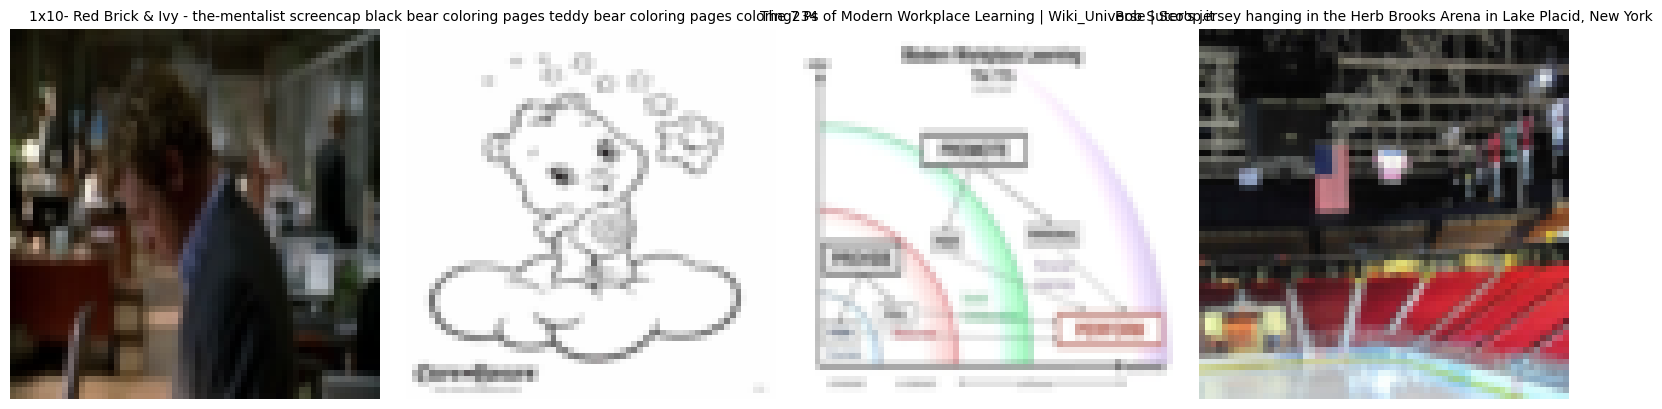

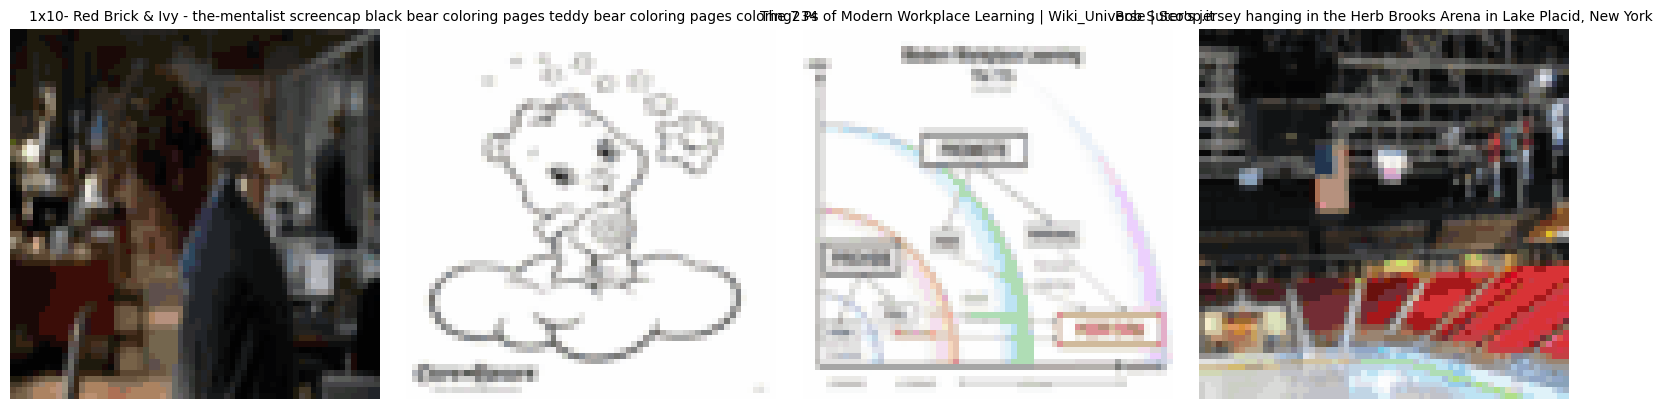

Predicting noise...
predicted noise
loss: 1.0018699169158936


Epoch 1/1: 33it [03:06,  8.26s/it, Loss=1.0019, Total Images=1056, Steps=33]

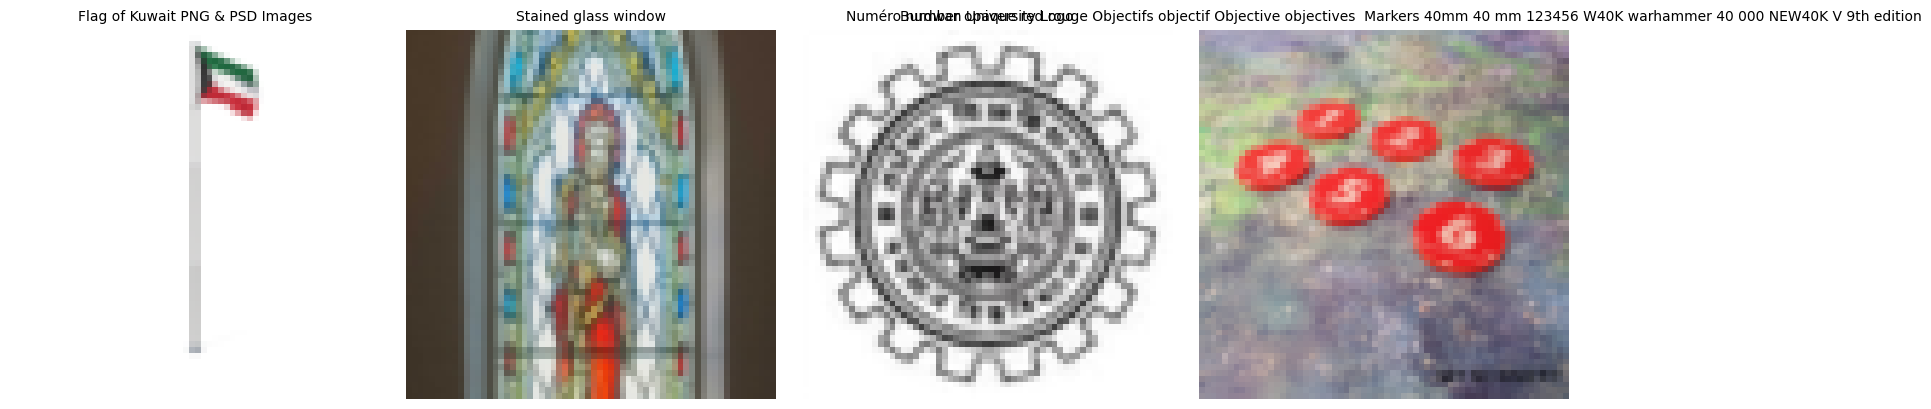

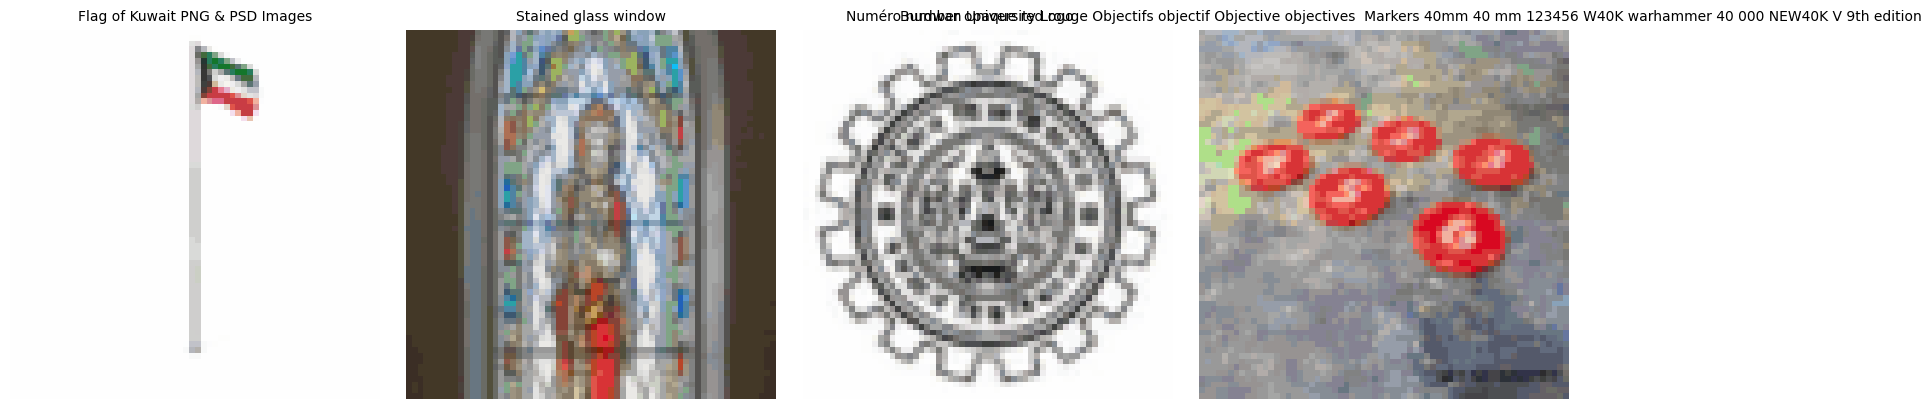

Predicting noise...
predicted noise
loss: 0.9995388984680176


Epoch 1/1: 34it [03:10,  6.90s/it, Loss=0.9995, Total Images=1088, Steps=34]

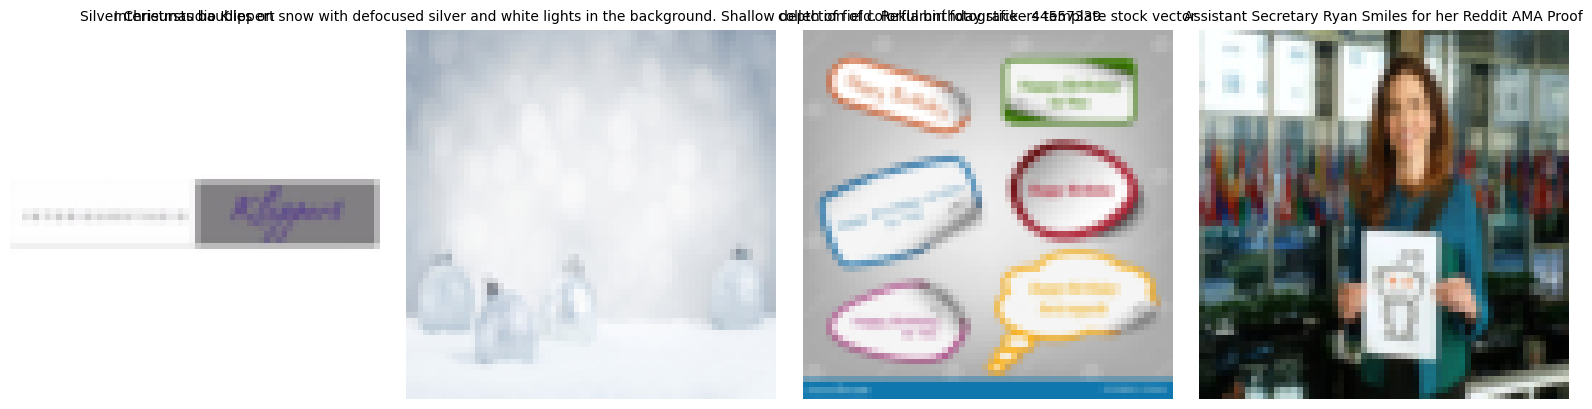

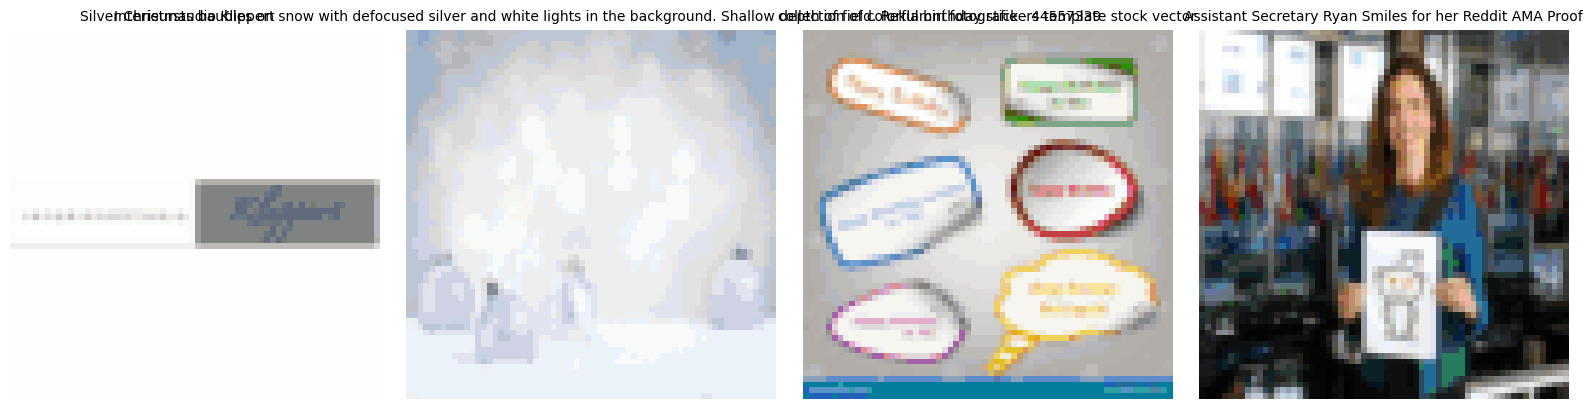

Predicting noise...
predicted noise
loss: 1.0073851346969604


Epoch 1/1: 35it [03:13,  5.96s/it, Loss=1.0074, Total Images=1120, Steps=35]

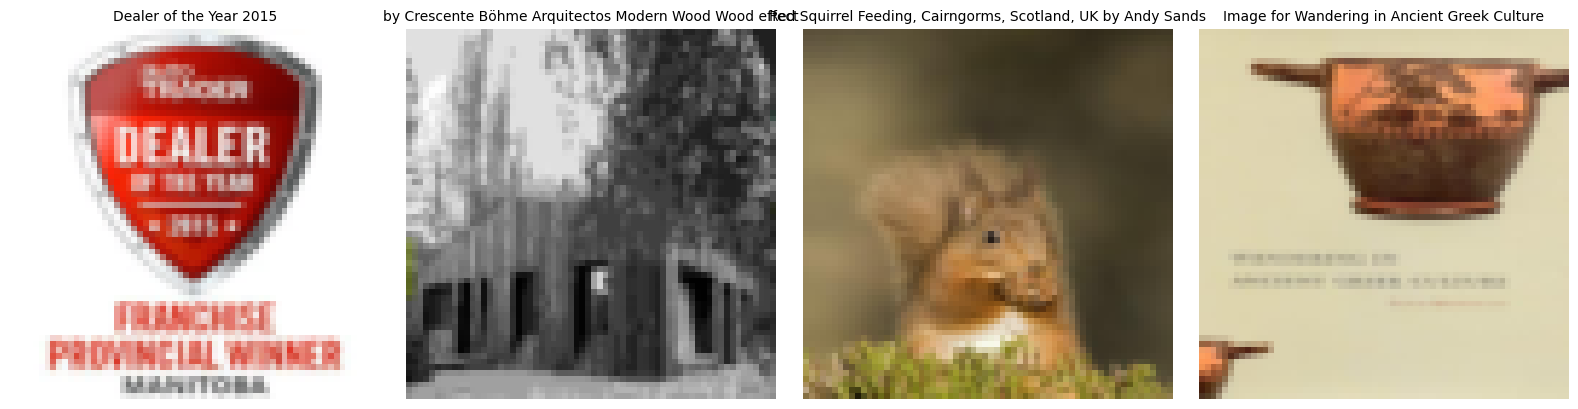

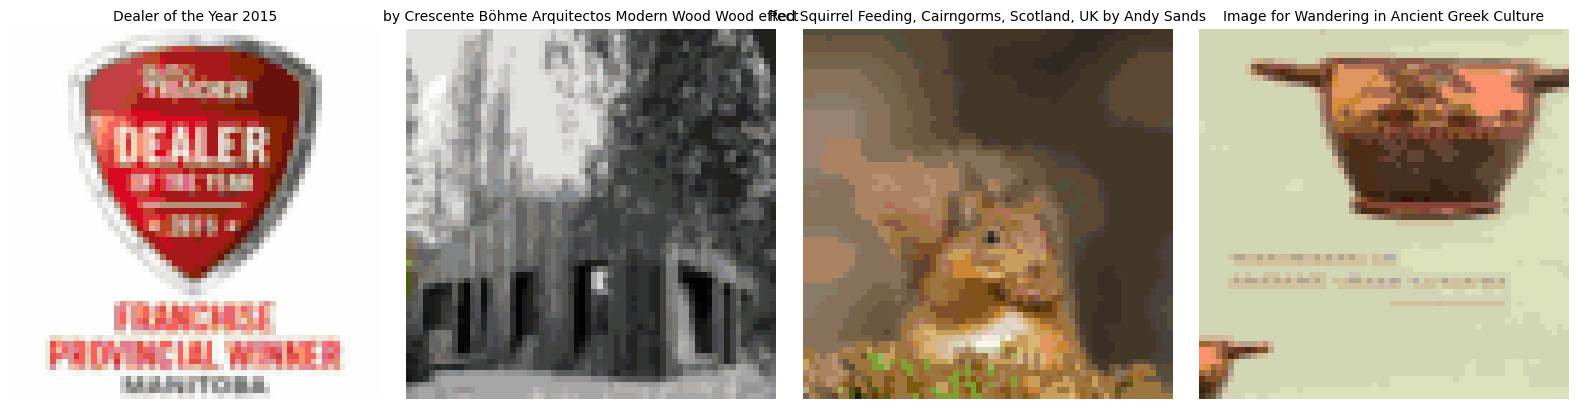

Predicting noise...
predicted noise
loss: 1.0056958198547363


Epoch 1/1: 36it [03:17,  5.30s/it, Loss=1.0057, Total Images=1152, Steps=36]

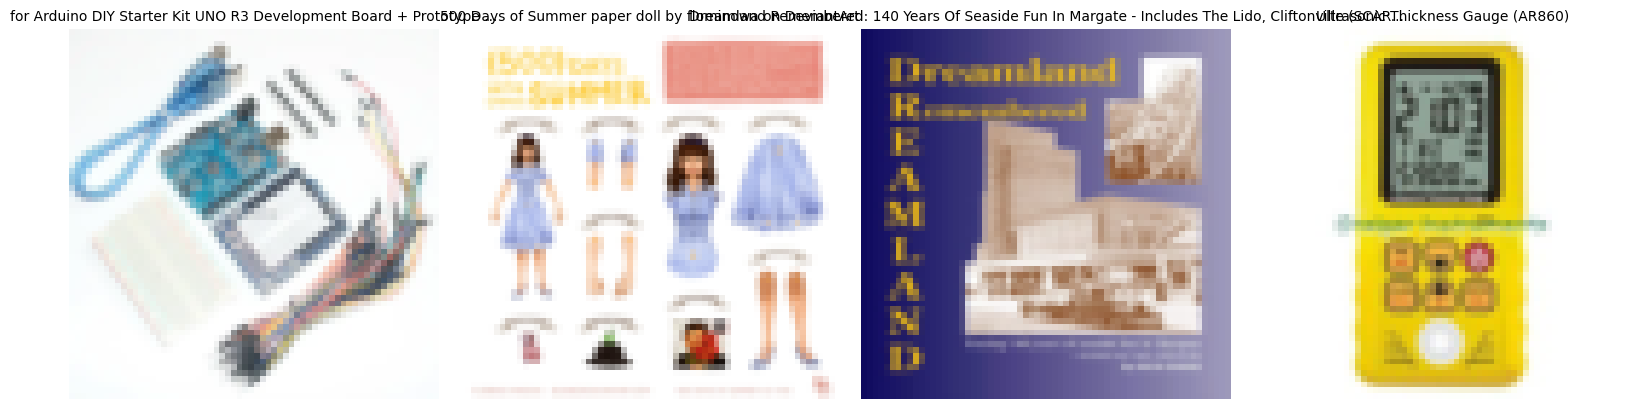

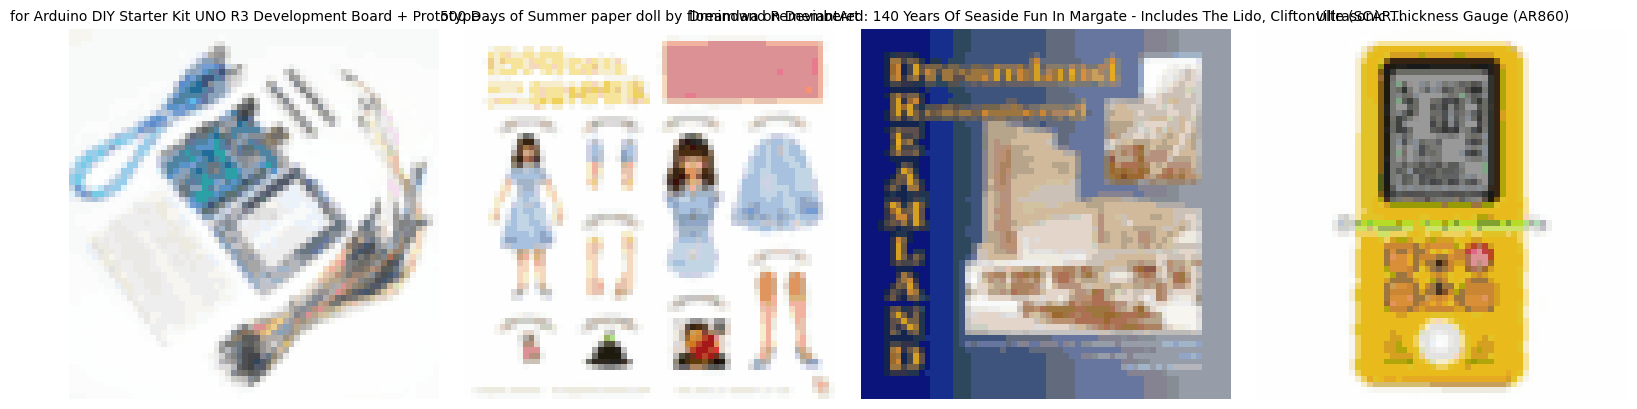

Predicting noise...
predicted noise
loss: 1.0083506107330322


Epoch 1/1: 37it [03:21,  4.84s/it, Loss=1.0084, Total Images=1184, Steps=37]

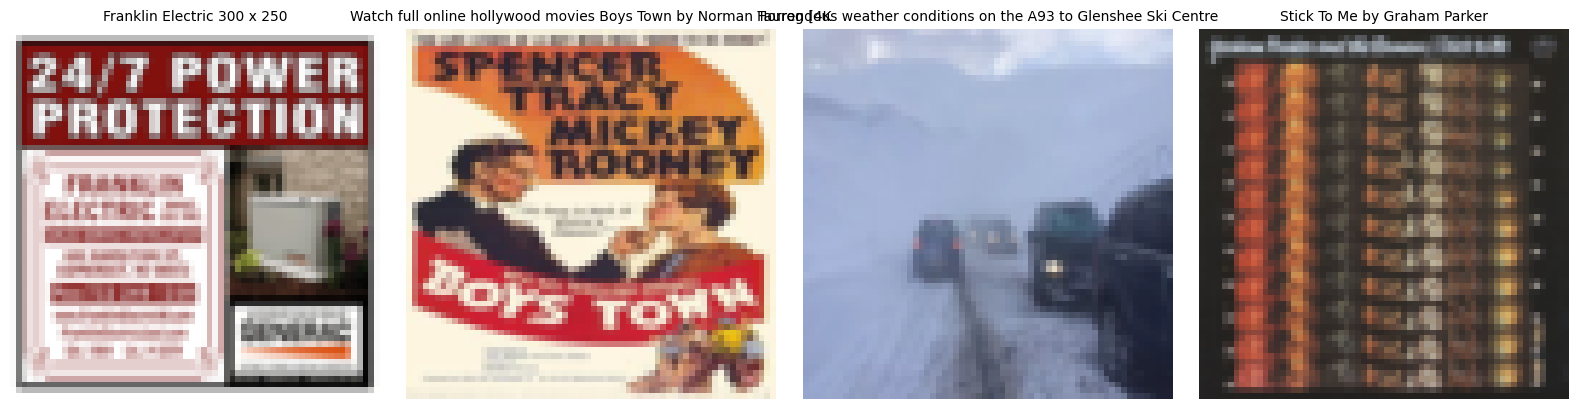

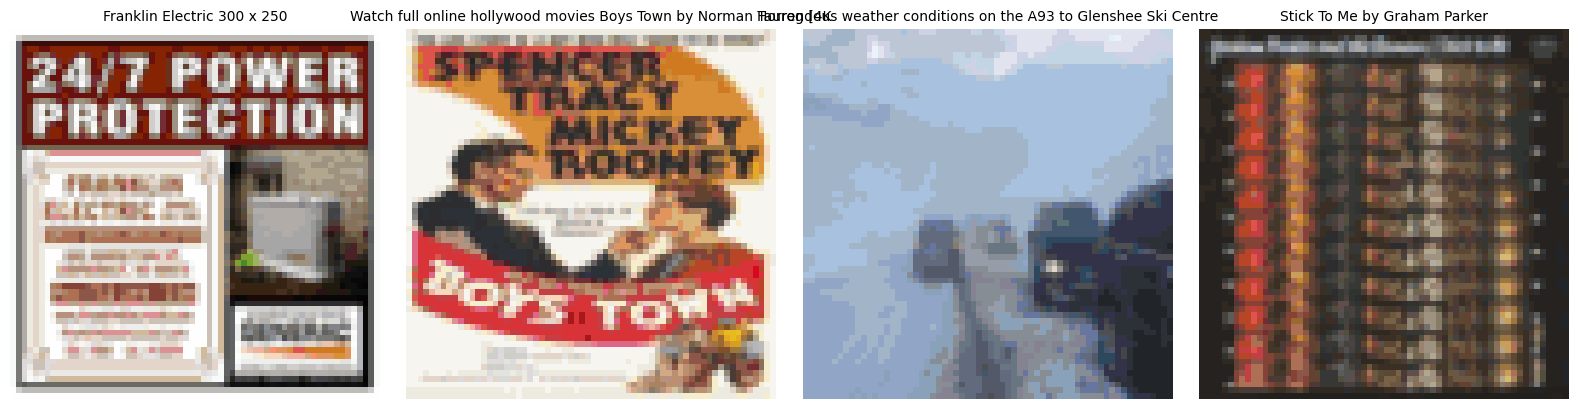

Predicting noise...
predicted noise
loss: 0.9980783462524414


Epoch 1/1: 38it [03:25,  4.56s/it, Loss=0.9981, Total Images=1216, Steps=38]

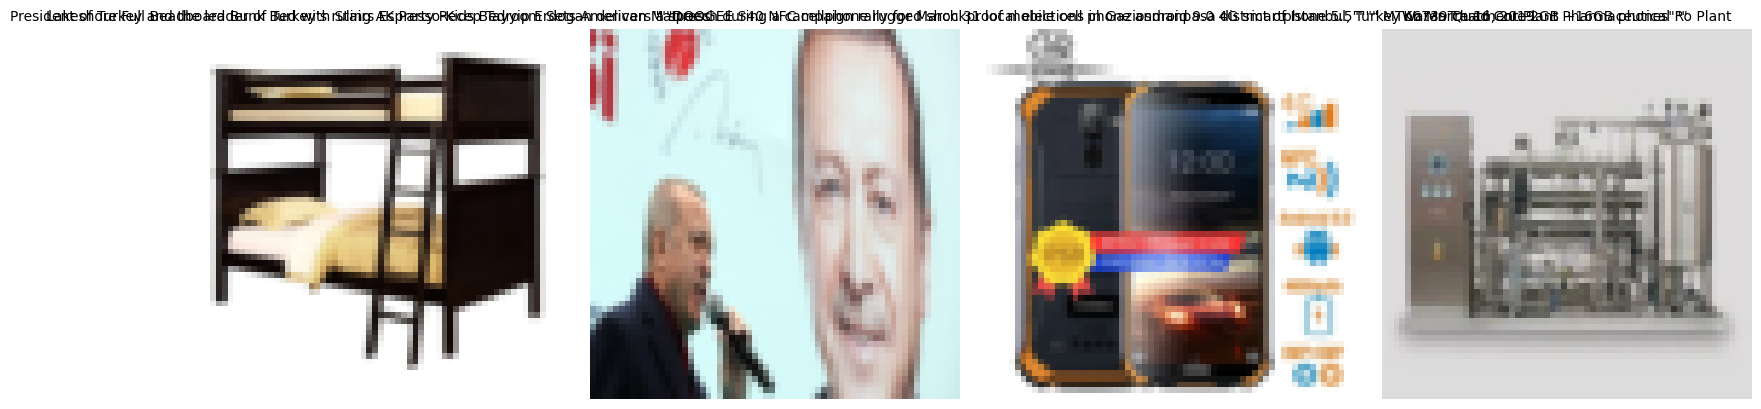

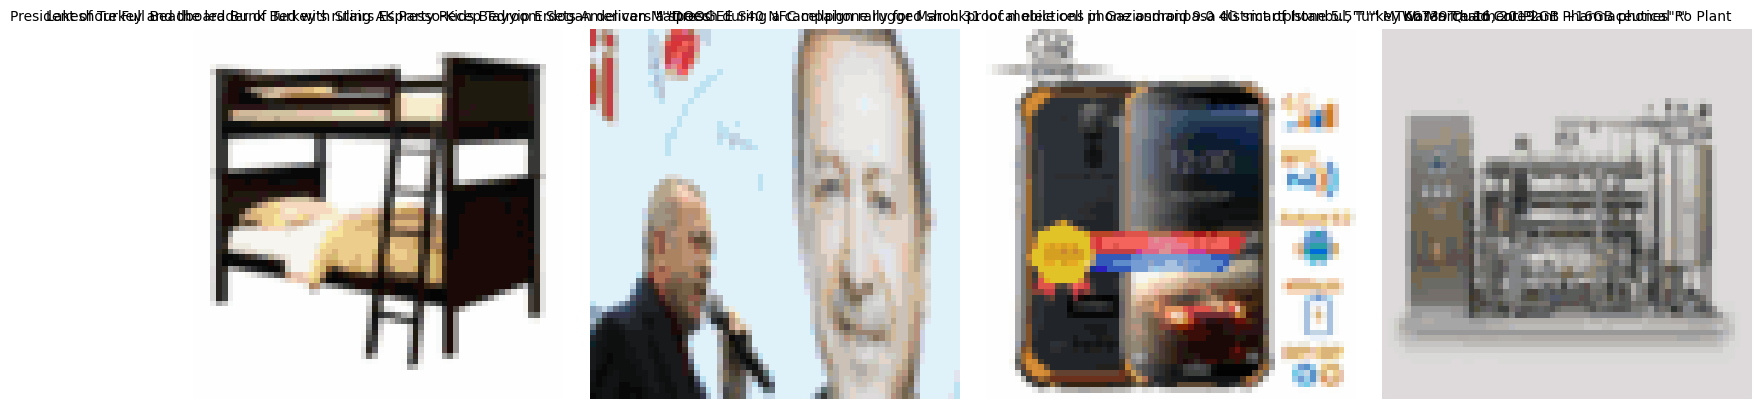

Predicting noise...
predicted noise
loss: 1.0010159015655518


Epoch 1/1: 39it [03:29,  4.35s/it, Loss=1.0010, Total Images=1248, Steps=39]

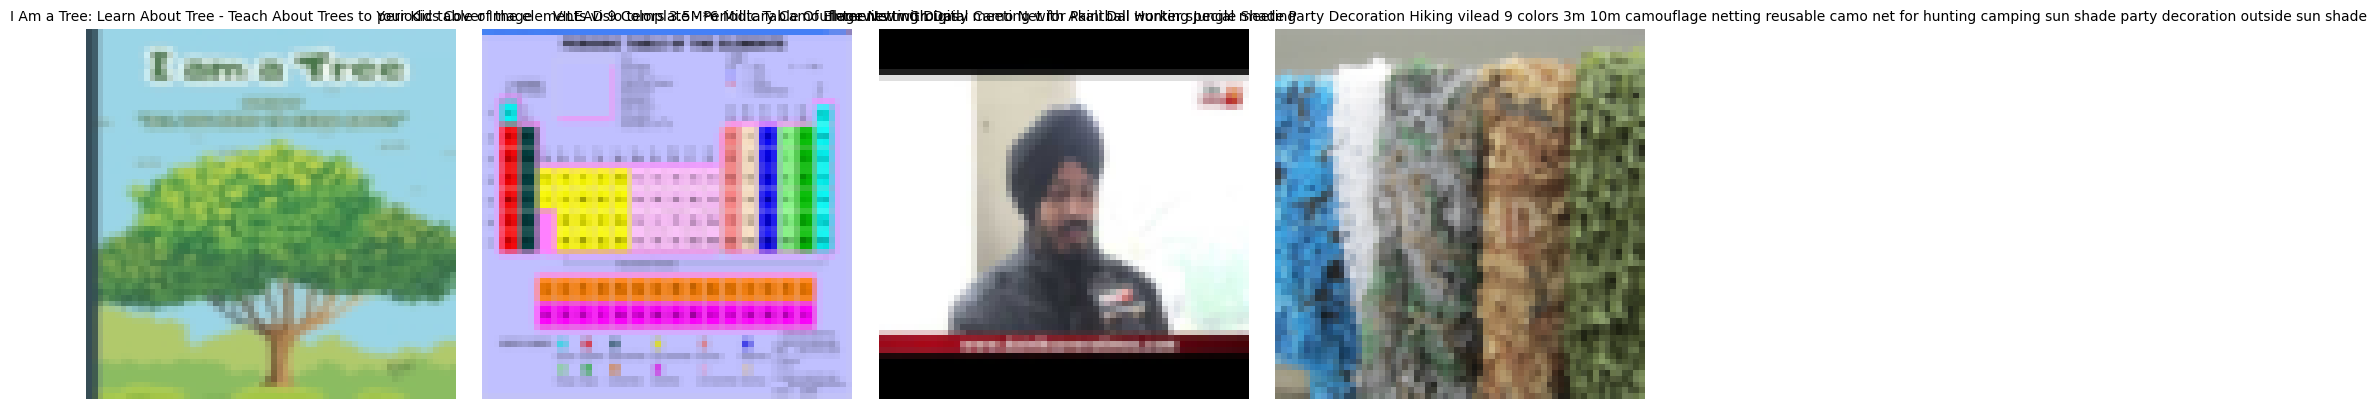

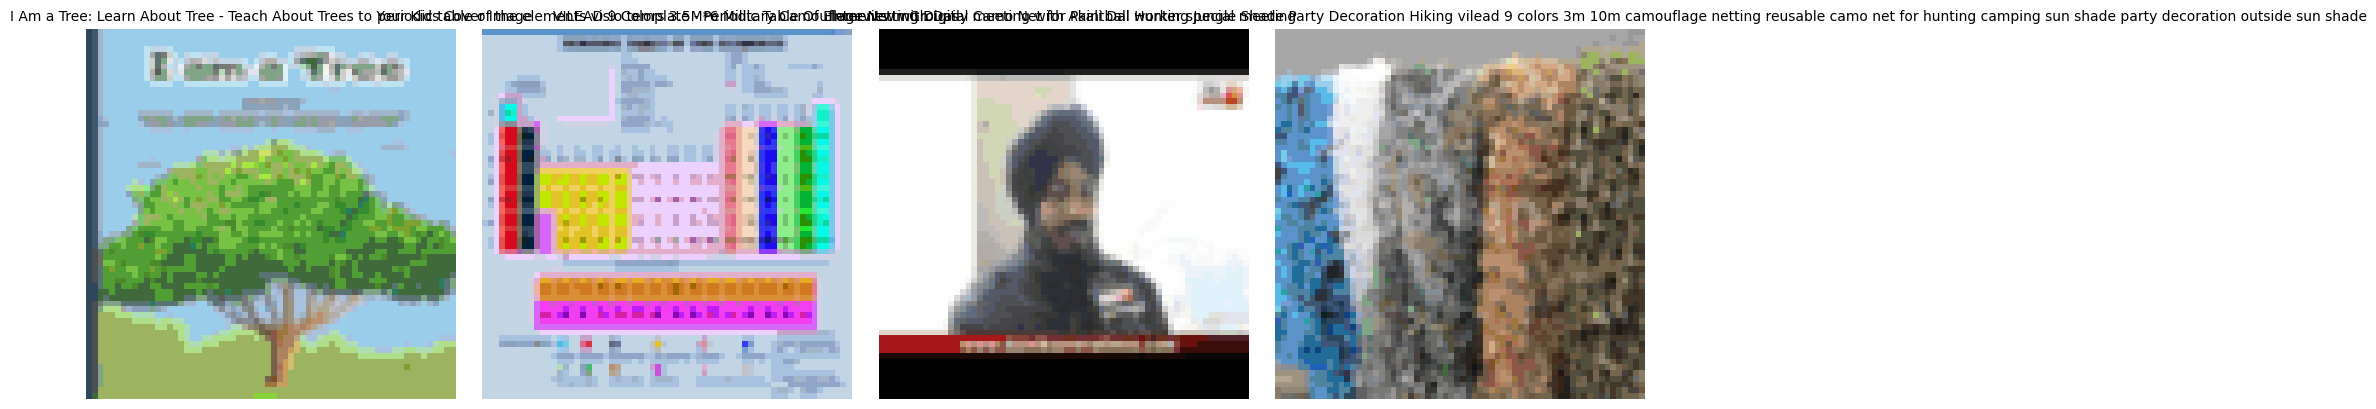

Predicting noise...
predicted noise
loss: 0.9979599714279175


Epoch 1/1: 40it [03:32,  4.21s/it, Loss=0.9980, Total Images=1280, Steps=40]

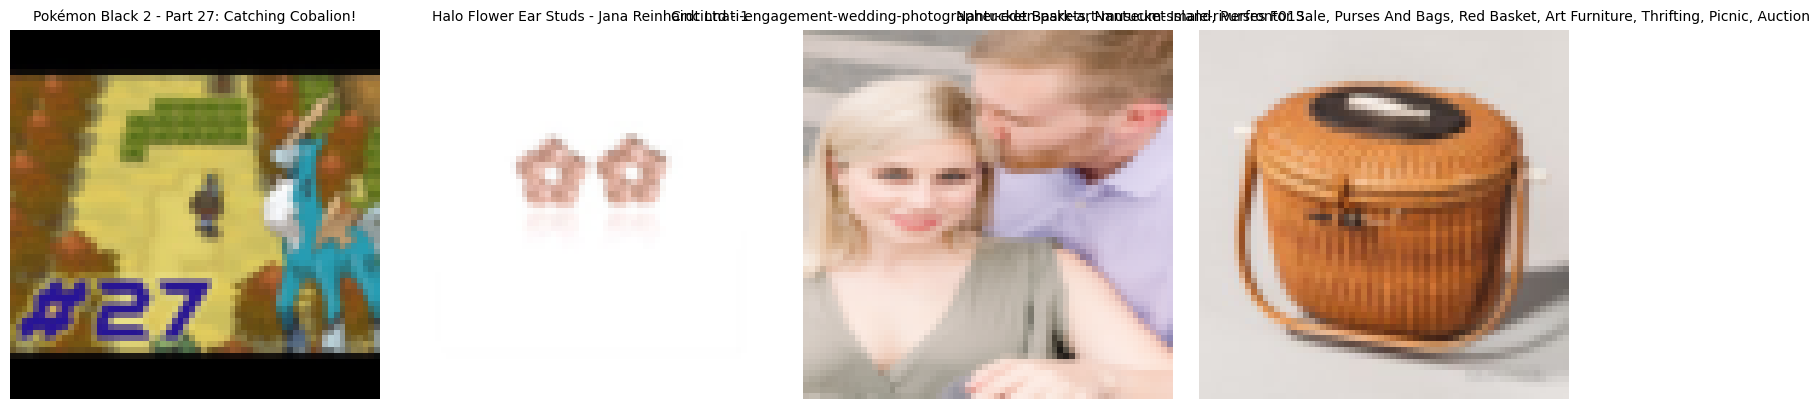

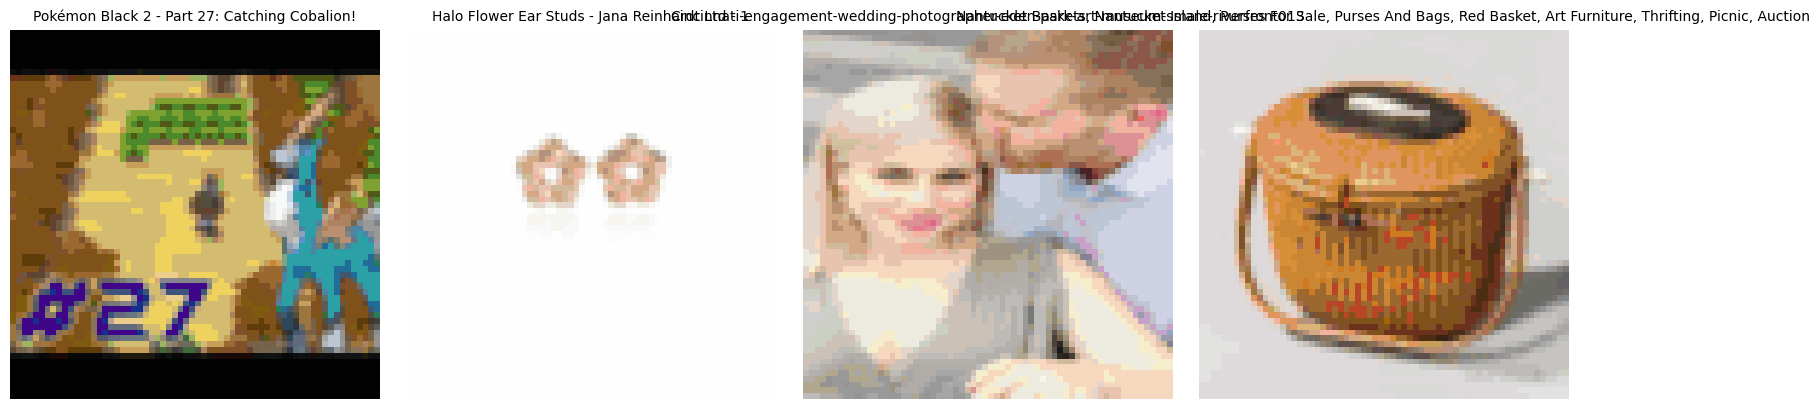

Predicting noise...
predicted noise
loss: 1.0035536289215088


Epoch 1/1: 41it [03:36,  4.09s/it, Loss=1.0036, Total Images=1312, Steps=41]

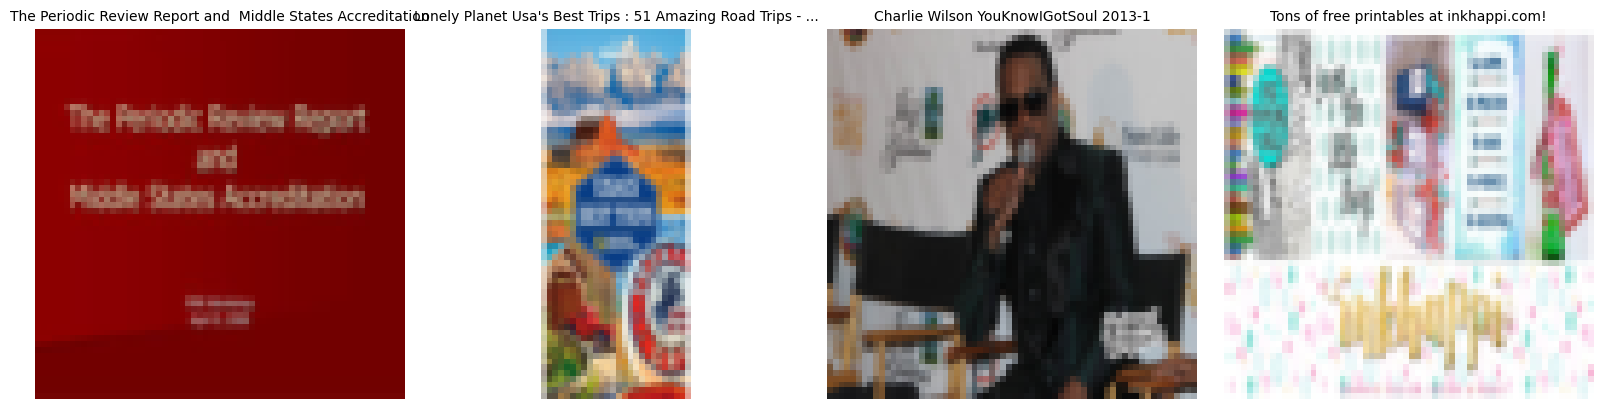

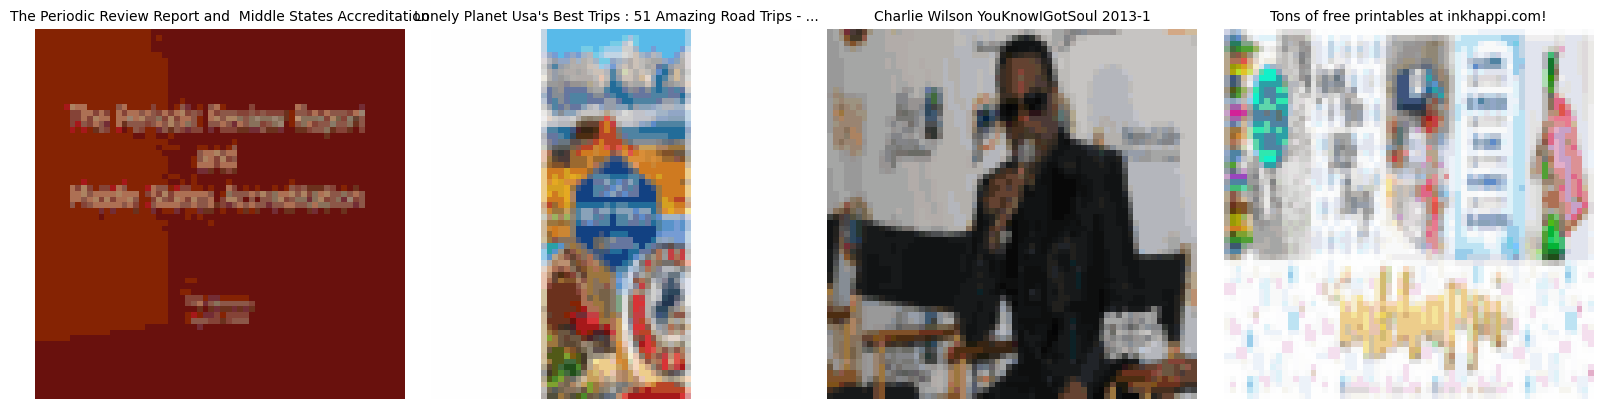

Predicting noise...
predicted noise
loss: 1.0052629709243774


Epoch 1/1: 42it [03:40,  3.99s/it, Loss=1.0053, Total Images=1344, Steps=42]/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/doshlom4/torch114/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


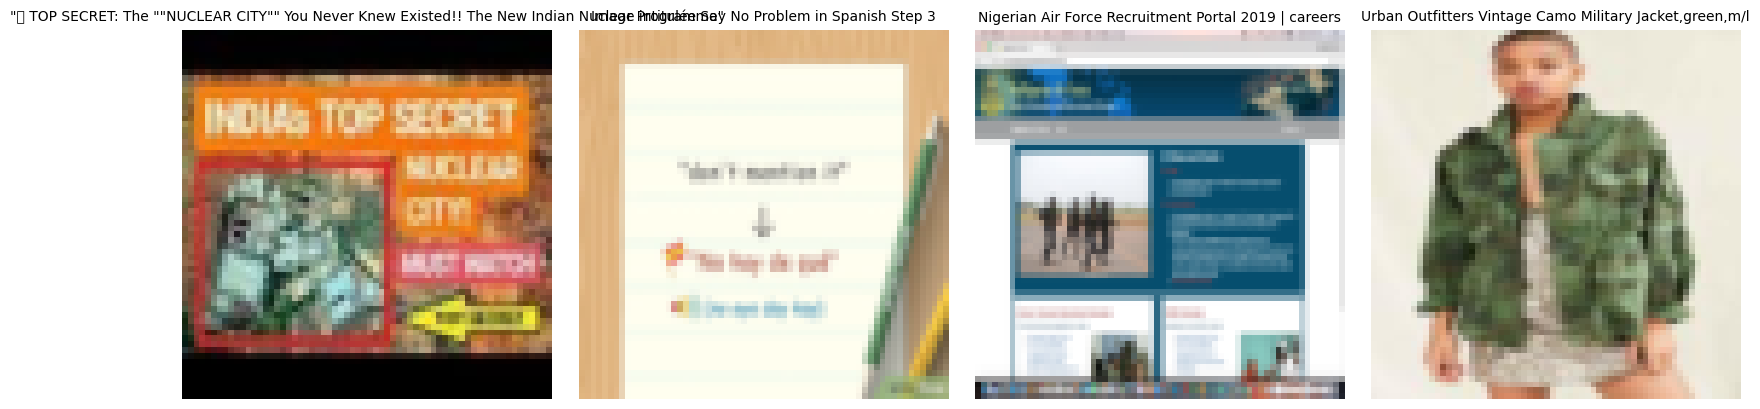

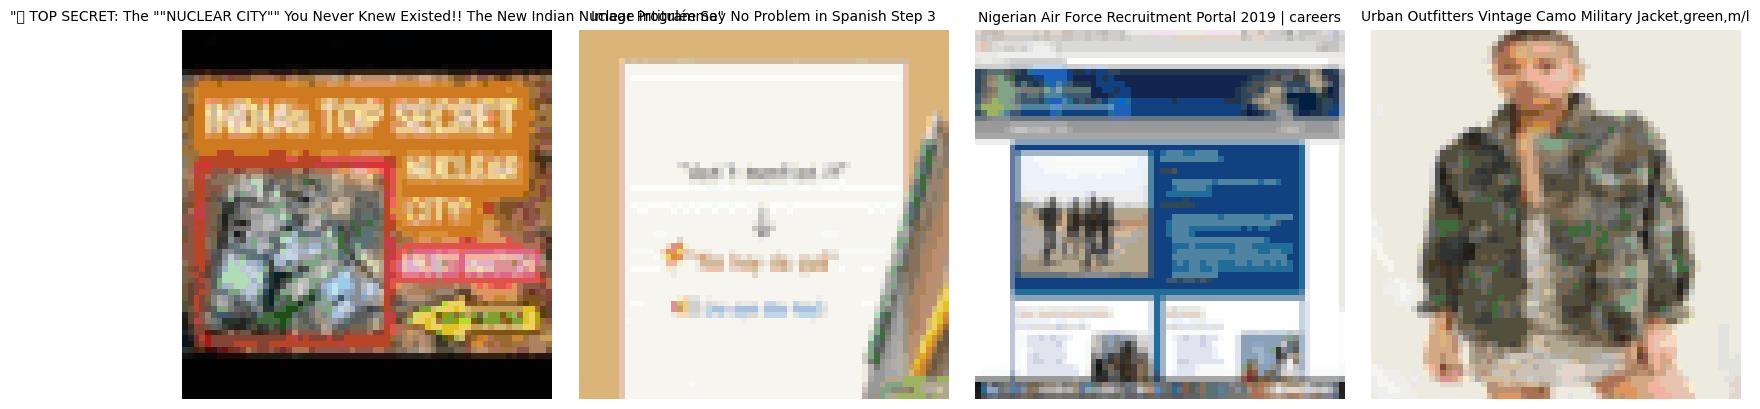

Predicting noise...
predicted noise
loss: 0.9993925094604492


Epoch 1/1: 43it [03:44,  3.91s/it, Loss=0.9994, Total Images=1376, Steps=43]/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 27927 (\N{CJK UNIFIED IDEOGRAPH-6D17}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 12358 (\N{HIRAGANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 12450 (\N{KATAKANA LETTER A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 12454 (\N{KATAKANA LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2536615/1505521953.py:36: Use

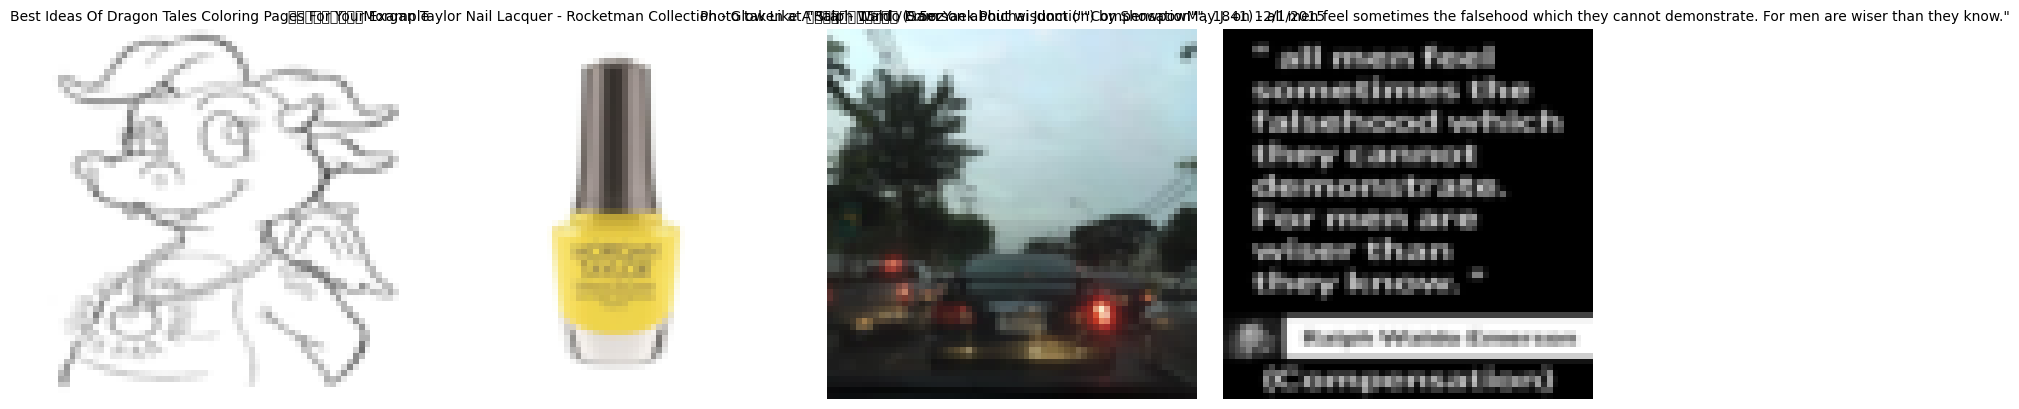

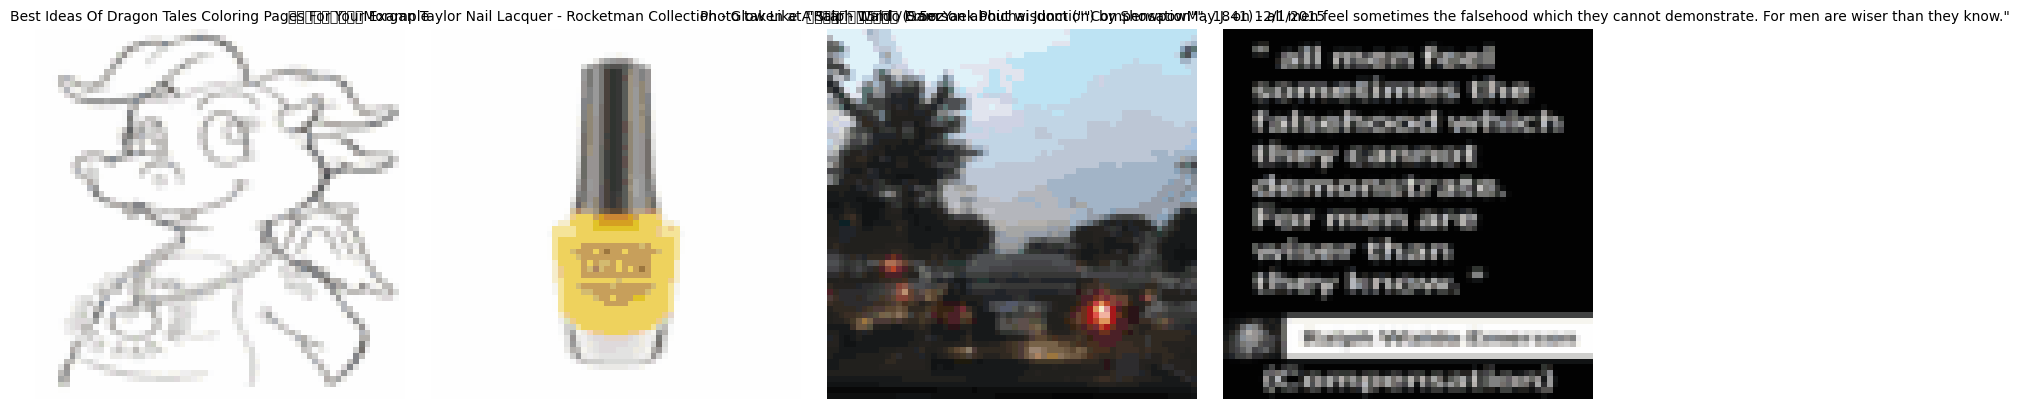

Predicting noise...
predicted noise
loss: 0.9977602958679199


Epoch 1/1: 44it [03:47,  3.86s/it, Loss=0.9978, Total Images=1408, Steps=44]

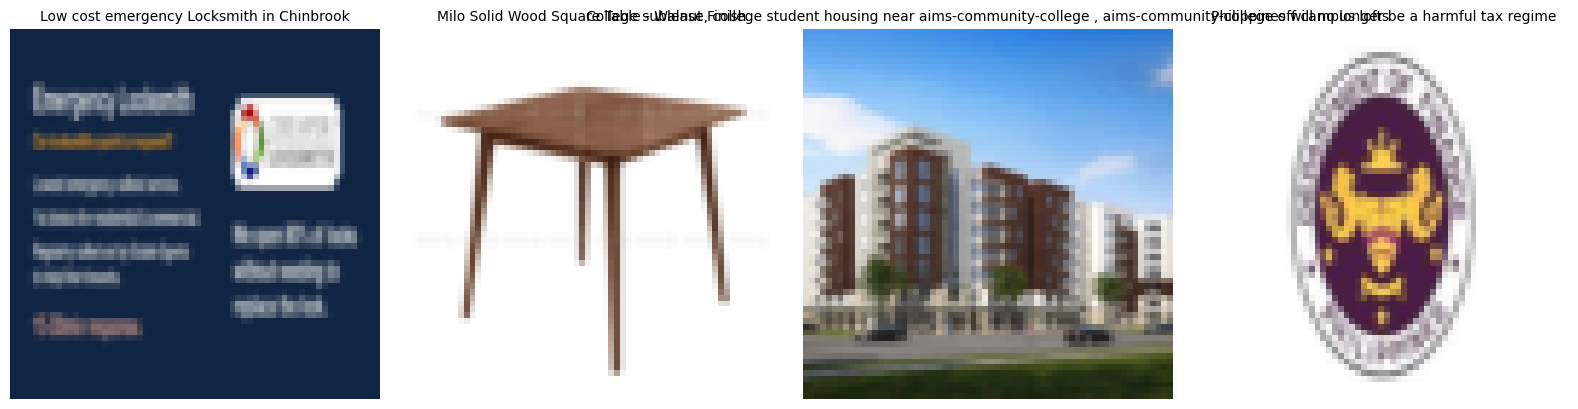

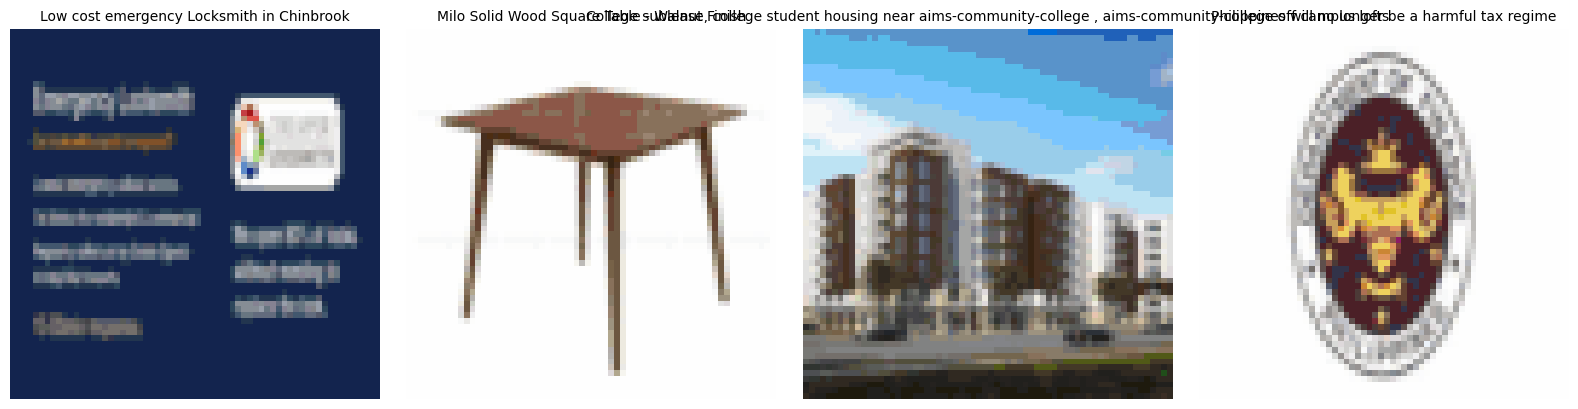

Predicting noise...
predicted noise
loss: 0.9935828447341919


Epoch 1/1: 45it [03:51,  3.81s/it, Loss=0.9936, Total Images=1440, Steps=45]

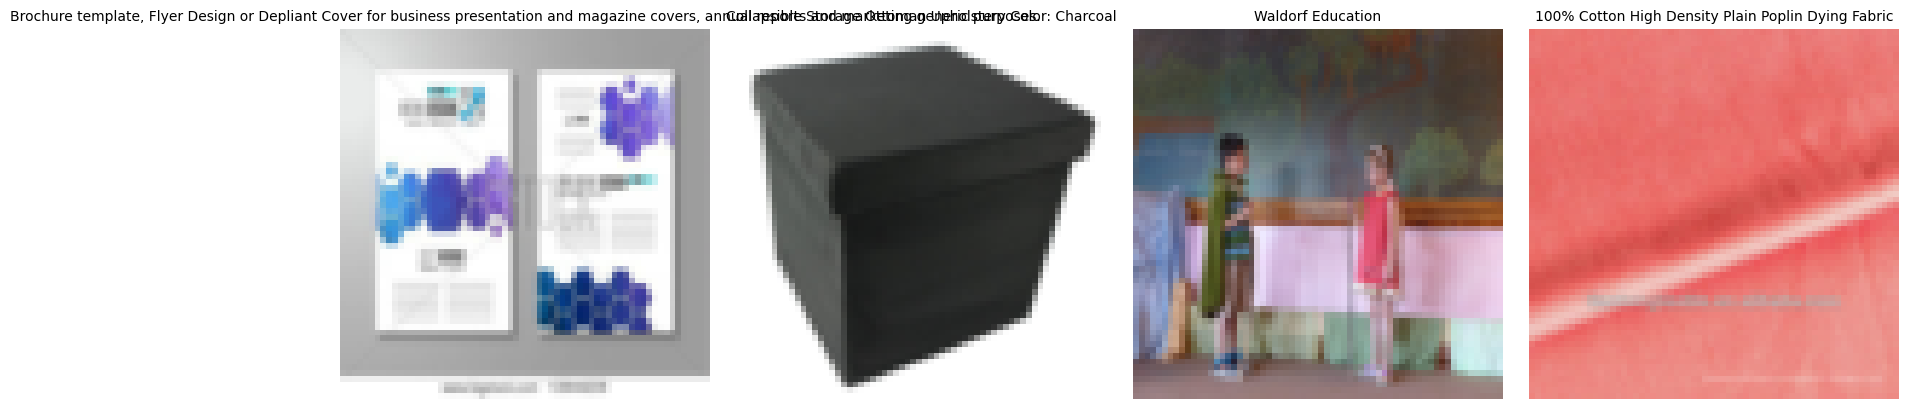

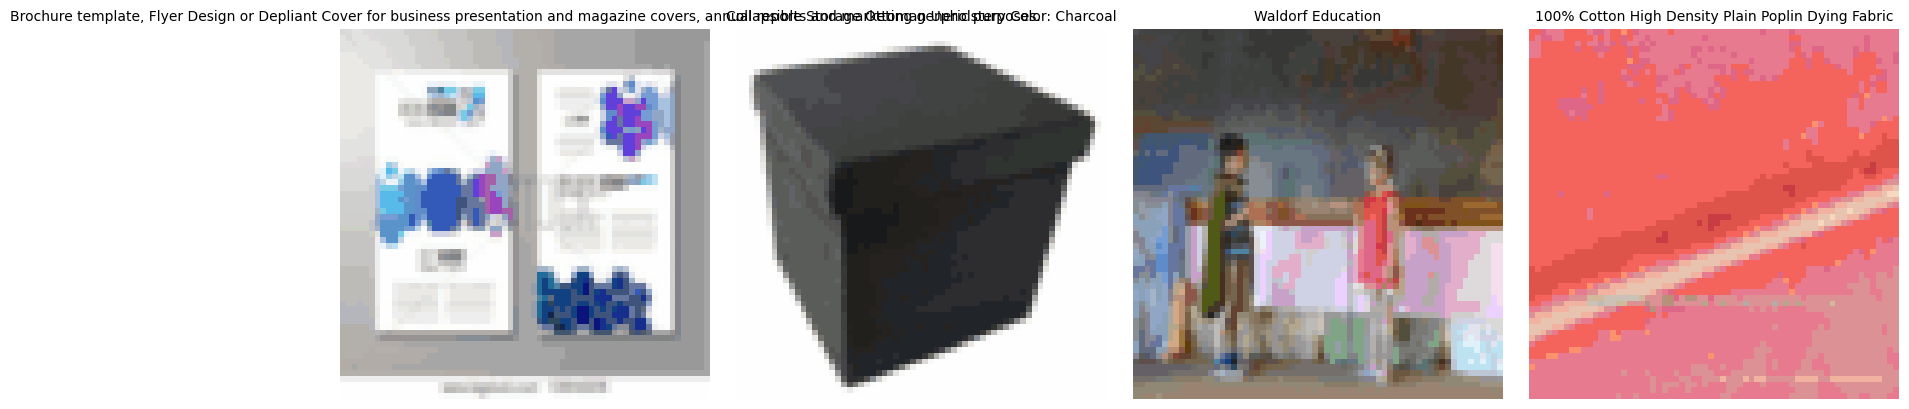

Predicting noise...
predicted noise
loss: 1.00533926486969


Epoch 1/1: 46it [03:55,  3.78s/it, Loss=1.0053, Total Images=1472, Steps=46]

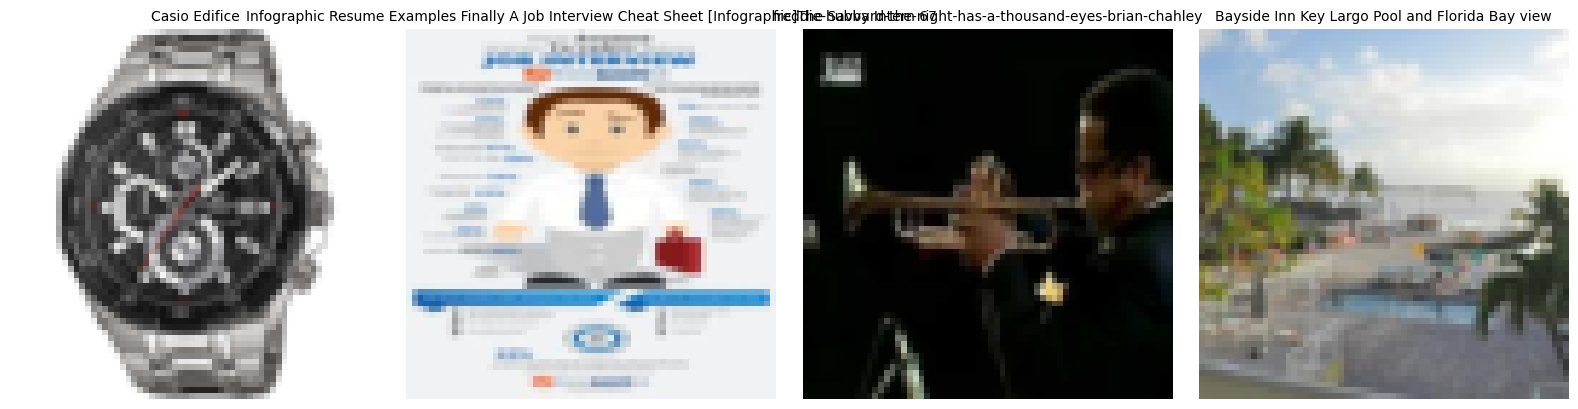

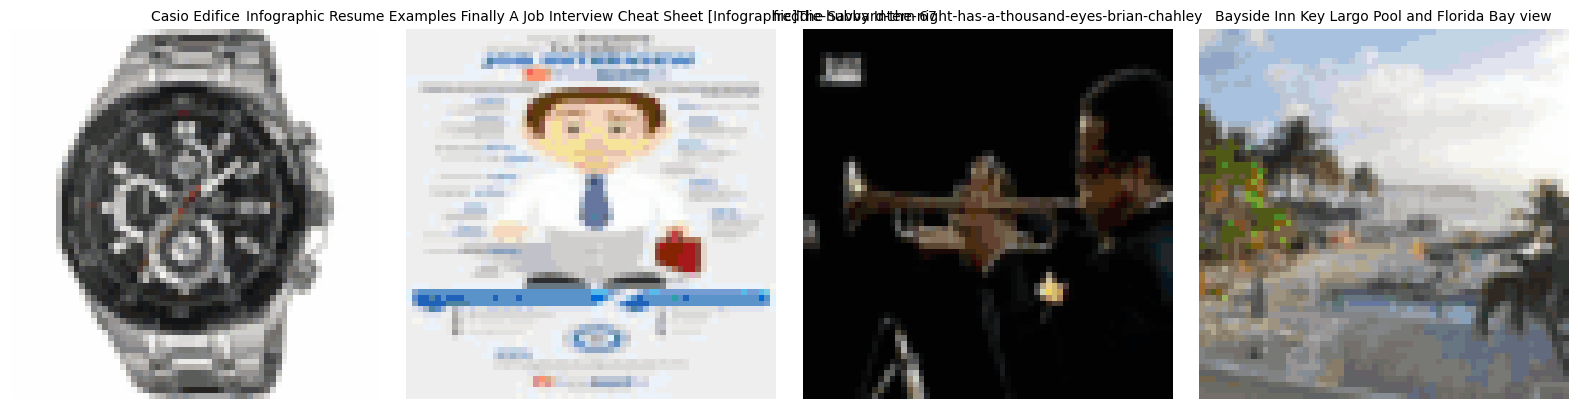

Predicting noise...
predicted noise
loss: 0.994480550289154


Epoch 1/1: 46it [03:59,  5.20s/it, Loss=1.0053, Total Images=1472, Steps=46]


KeyboardInterrupt: 

In [23]:
# Training parameters

# learning_rate = 1e-4
steps = 0
num_of_batches_per_epoch = [0] * num_epochs
total_images_processed = 0

# Training loop
for epoch in range(num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True)

    for batch_i, batch in enumerate(pbar):
        images, captions = batch # [B, 3, H, W]
        b, _, _, _ = images.shape

        # clear_output()

        # plot batch of images
        if (steps % 1024) == 0:
            plot_image_batch(images, captions, 4)

        # quantize
        images = quantize_batch_to_palette_indices(images, palette)
        images = images.unsqueeze(1).to(device) # [B, 1, H, W]

        # plot quantized images
        if (steps % 1024) == 0:
            rec_images = reconstruct_from_indices(images.squeeze(1), palette)
            plot_image_batch(rec_images, captions, 4)

        # Encode text
        text_input = tokenizer(captions, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
        text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

        # Convert to float32 for noise addition
        images = images.float() / 255.0  # Or normalize as needed

        # Add noise to latents
        noise = torch.randn_like(images)
        timesteps = torch.randint(0, 1000, (images.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(images, noise, timesteps)

        # plot noisy images
        if (steps % 1024) == 0:
            rec_noisy = reconstruct_from_indices(noisy_latents.squeeze(1), palette)
            plot_image_batch(rec_noisy, captions, 4)

        # Predict noise
        output = model(noisy_latents, timesteps, encoder_hidden_states=text_embeddings)
        noise_pred = output.sample  # now it's safe

        # Calculate loss
        loss = torch.nn.functional.mse_loss(noise_pred, noise)

        # Backpropagate and optimize
        accelerator.backward(loss) # accelerate
        optimizer.step()
        optimizer.zero_grad()

        # Update tracking
        total_images_processed += b
        steps += 1
        pbar.set_postfix({
            "Loss": f"{loss.item():.4f}",
            "Total Images": total_images_processed,
            "Steps": steps
        })
    
    num_of_batches_per_epoch[epoch] = batch_i

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
print(num_of_batches_per_epoch)

In [ ]:
# Set models to evaluation mode
# vae.eval()
text_encoder.eval()
model.eval()

# Inference parameters
num_inference_steps = 50
# guidance_scale = 100

@torch.no_grad()
def generate_image(prompt):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Initialize latents / create noisy image.
    torch.manual_seed(422)  # Set the seed
    latents = torch.randn((1, model.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    # Denoising loop
    for t in tqdm(scheduler.timesteps):
        # Prepare latent model input
        latent_model_input = scheduler.scale_model_input(latents, t)

        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image ## i.e reverse the normalization
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 4"
generated_image = generate_image(prompt)

# Display or save the image
image = generated_image[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()

In [ ]:
## save unet and text_encoder
# Save the trained model
# torch.save(unet.state_dict(), "./unet.pth")


In [ ]:
# Set models to evaluation mode
# vae.eval()
# text_encoder.eval()
unet.eval()

# Inference parameters
num_inference_steps = 50
guidance_scale = 8

@torch.no_grad()
def generate_image(prompt, num_images=1):
    # Tokenize and encode the text prompt
    text_input = tokenizer(prompt, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, truncation=True, return_tensors="pt")
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

    # Prepare unconditioned embeddings for classifier free guidance
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer([""] * num_images, padding="max_length", max_length=TOKENIZER_MAX_LENGTH, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

    # Concatenate text embeddings with unconditional embeddings
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Initialize latents
    latents = torch.randn((num_images, unet.in_channels, 28, 28)).to(device)

    # Denoise scheduler
    scheduler = DDPMScheduler(beta_schedule="squaredcos_cap_v2", num_train_timesteps=1000)
    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # Expand latents for classifier free guidance
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        # Predict noise residual
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Compute previous noisy sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    # # Decode latents to image
    # latents = 1 / 0.18215 * latents
    # image = vae.decode(latents).sample
    image=latents
    print (image.shape)
    # Post-process image
    image = (image / 2 + 0.5).clamp(0, 1)
    # image = image.cpu().permute(0, 2, 3, 1).numpy()
    # image = (image * 255).round().astype("uint8")
    return image

# Generate an image
prompt = "A handwritten digit 5"
generated_images = generate_image(prompt)

# Display or save the image
image = generated_images[0]  # Remove the extra dimension
image = image.squeeze(0)
image = image.detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
image = (image * 255).round().astype("uint8")
import matplotlib.pyplot as plt

# Assuming generated_image is the tensor you want to view
# image = generated_image[0].detach().cpu().numpy()  # Remove batch dimension
# image = image.unsqueeze(-1)  # Add a new dimension for color channels
plt.imshow(image, cmap='gray')  # Display as grayscale image
plt.show()


In [ ]:
# Define the guidance scale values
guidance_scales = [0, 5, 10, 20, 50, 100]

# Initialize a figure with a grid of subplots
fig, axs = plt.subplots(nrows=1, ncols=len(guidance_scales), figsize=(20, 4))

# Generate an image for each guidance scale value
for i, guidance_scale in enumerate(guidance_scales):
    # Set the guidance scale
    # global guidance_scale
    # guidance_scale = guidance_scale

    # Generate an image
    prompt = "A handwritten digit 0"
    generated_image = generate_image(prompt)

    # Display or save the image
    image = generated_image[0]  # Remove the extra dimension
    image = image.squeeze(0)
    image = image.detach().cpu().numpy()  # Remove batch dimension
    image = (image * 255).round().astype("uint8")

    # Display the image in the current subplot
    axs[i].imshow(image, cmap='gray')  # Display as grayscale image
    axs[i].set_title(f'Guidance Scale: {guidance_scale}')
    axs[i].axis('off')

# Layout so plots do not overlap
fig.tight_layout()

# Display the plot
plt.show()